This notebook is used to generate Fig S5 (and updated Fig 4), near-commensurate packings on a cylinder

---
022723 bennett contains 100 trials at 59deg for sector angle 0-30 with the intention of redoing fig 4 in the manuscript (fig7 notated in this file).

unfortunately since i am a silly person i made the reference figure scaling all with respect to a very specific trial. so i do have to rerun the notebook with old data (inpur_dir), and then separately import the new data (input_dir_c)...

output_dir -> old data used in paper

defect_density_collect -> defect info for CONES (old data);

output_dir_c -> new data used to generate replacement fig 4 

defect_density_collect_c -> defect info for CONES (new data);

fig7data -> defect info for CYLINDERS

In [1]:
## general pipeline: 
## 1) run simulations to generate .dat files (~3 days, cluster)
## 2) process first half of this notebook to check for basic bugs (~1 day, local)
## 3) run analysis cell in the middle of this notebook to generate data_collect.pkl (~2 days, cluster)
## 4) finish analysis (defect_density_collect.pkl, etc) in this notebook (~1 day, local)
## 5) reimport relevant .pkl files and proceed with analysis (???? days)

##on cluster:
##import pickle5-> import pickle
##make sure run_dir_list_npy is correct
##run_dir_list=run_dir_list_npy
##input_dir and output_dir-> change to current (/n/manoharan/jessicasun instead of /Volumes/manoharan_lab/jessicasun)
# run_dir_df_filtered=run_dir_df[((run_dir_df['trial']>=((jobnum-1)*20))&(run_dir_df['trial']<(jobnum*20)))]


def start_timer():
    start=time.time()
    return start
def stop_timer(start,label,thresh=0.001):
    stop=time.time()
    time_elapsed=stop-start
    if time_elapsed>thresh:
        print(label,time_elapsed)
    return stop

#start=start_timer()
#start=stop_timer(start,'label') #the stop of this timer is start of next timer
#start=stop_timer(start,'label')

In [2]:
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import sympy
import seaborn as sns
import time
from scipy.stats import circmean
import pickle5 as pickle
###from bennett_plotter.ipynb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import mpl_toolkits.mplot3d.art3d as art3d
from math import atan2, cos, sin

input_dir='/Volumes/manoharan_lab/jessicasun/Simulations/2022/022322 bennett simulation' #load data from groupshare
# input_dir='/Volumes/manoharan_lab/jessicasun/Simulations/011422 bennett simulation' #load data from groupshare
output_dir='/Volumes/manoharan_lab/jessicasun/Simulations/2022/022322 bennett simulation'
# output_dir='/Users/jessicasun/Documents/GitHub/cone-assembly-simulation/Code/jessica_bennett'
if not os.path.exists(output_dir+'/analysis'):
    os.mkdir(output_dir+'/analysis')
output_dir=output_dir+'/analysis'

# input_dir='/Users/jessicasun/Documents/GitHub/cone-assembly-simulation/Code/jessica_bennett'
os.chdir(input_dir)
# run_dir_list_npy=np.unique(np.load('run_dir_list_022322_0-99.npy'))
a=np.unique(np.load('run_dir_list_022322_0-99.npy'))
b= np.unique(np.load('run_dir_list_022322_0-99_cylinders0-5cinit.npy'))
run_dir_list_npy=np.unique(np.concatenate((a,b)))
run_dir_list=[]

####################
##DIRECT IMPORT######
####################

#if all files have been processed, you can directly set run_dir_list=run_dir_list_npy and comment out the below section

run_dir_list=run_dir_list_npy
# with open(output_dir+'/run_dir_list.pkl', "rb") as fh: #read binary = rb, #file handle = fh
#     run_dir_list = pickle.load(fh)
#

# #####################
# ###QUICK IMPORT######
# #####################
# ##direct set without checking if run_dir contains dat file... much, much faster

# # run_dir_list=os.listdir('datfiles/') 

# ####################
# ##THOROUGH IMPORT###
# ####################
# start=time.time()
# counter=0
# for run_dir in os.listdir('datfiles/'): #get directory names in datfiles
# #     if (os.path.exists('datfiles/'+run_dir+'/particles.dat'))&(os.path.exists('datfiles/'+run_dir+'/adj.dat')):    
#     if os.path.exists('datfiles/'+run_dir+'/particles.dat'):
#         run_dir_list+=[run_dir]
#         counter+=1
#         if counter%100==1:
#             print('.',end='')
# print('\n'+str(round(len(run_dir_list)/len(run_dir_list_npy)*100,2))+'%',end=' | ')
# print(str(len(run_dir_list))+' processed, '+str(len(run_dir_list_npy)-len(run_dir_list))+' remaining',end=' | ')
# print('load time: '+str(round((time.time()-start)/60,2))+'min\n')

# #### save as pickle and reimport so that we can work with this dataset snapshot####
# with open(output_dir+'/run_dir_list.pkl', 'wb') as f:
#     pickle.dump(run_dir_list, f)
# with open(output_dir+'/run_dir_list.pkl', "rb") as fh: #read binary = rb, #file handle = fh
#     run_dir_list = pickle.load(fh)

In [3]:
def get_params_dict(run_dir):
    keys=[]
    values=[]
    for params in run_dir.split('_'):
        key,value=params.split('-')
        keys+=[key]
        values+=[float(value)]
    params_dict=dict(zip(keys,values))
    if params_dict['cthetadeg']==0:
#         params_dict['cthetadeg']=(params_dict['cthetadeg']*np.pi/180+0.002)*180/np.pi #otherwise it'll break down (division by 0 later, etc)
        params_dict['run_dir']=run_dir
        params_dict['yinit']=params_dict['cinit']/(0.002) #from simulation definition
        params_dict['R']=params_dict['yinit']+20 #from simulation definition
        params_dict['thetadeg']=0
    else:
#         params_dict['cthetadeg']=params_dict['cthetadeg']
        params_dict['run_dir']=run_dir
        params_dict['yinit']=params_dict['cinit']/(params_dict['cthetadeg']*np.pi/180) #from simulation definition
        params_dict['R']=params_dict['yinit']+20 #from simulation definition
        params_dict['thetadeg']=2*ctheta_to_alpha(params_dict['cthetadeg']*np.pi/180)*180/np.pi
    return params_dict
def get_run_dir_df(run_dir_list):
#     run_dir_df=pd.DataFrame() #DO NOT GROW A DATAFRAME!!!! grow a list of small df instead
    run_dir_df_list=[]
    for run_dir in run_dir_list:
        params_dict=get_params_dict(run_dir)
        run_dir_df_list+=[pd.DataFrame([params_dict])]
#         run_dir_df=run_dir_df.append(pd.DataFrame([params_dict]))
    run_dir_df=pd.concat(run_dir_df_list,axis=0)
    return run_dir_df
def run_dir_df_info(run_dir_df,input_dir=input_dir,output_dir=output_dir):
    print('input_dir','\n',input_dir)
    print('\noutput_dir','\n',output_dir,'\n')
    info_list=[]
    for item in run_dir_df.columns[-1:]:
        print(item,'\n',np.unique(run_dir_df[item]),'\n')
        info_list+=[str(item)+'-'+str(int(np.min(np.unique(run_dir_df[item]))))+'-'+str(int(np.max(np.unique(run_dir_df[item]))))]
    for item in run_dir_df.columns[:5]:
        print(item,'\n',np.unique(run_dir_df[item]),'\n')
        info_list+=[str(item)+'-'+str(int(np.min(np.unique(run_dir_df[item]))))+'-'+str(int(np.max(np.unique(run_dir_df[item]))))]
    info_tag='_'.join(info_list)
    print('info_tag','\n',info_tag,'\n')
    return info_tag
def ctheta_to_alpha(cthetarad):
    # alpha=theta/2=arcsin(phi/(2pi)), theta=full cone angle, alpha=half cone angle, phi=sector angle
    alpharad=np.arcsin(cthetarad/(2*np.pi))
    return alpharad
def load_dat(run_dir):
#     particles=np.loadtxt('datfiles/'+run_dir+'/particles.dat')
    particles=pd.read_csv('datfiles/'+run_dir+'/particles.dat', sep=' ', header=None).to_numpy()
#     adj=np.loadtxt('datfiles/'+run_dir+'/adj.dat')
    adj=pd.read_csv('datfiles/'+run_dir+'/adj.dat', sep=' ', header=None).to_numpy()
    return particles,adj
def find_coordnum(particles,adj):
    energy_list=[]
    for particle_idx in range(len(particles)):
        energy=sum(adj[:,particle_idx])
        energy_list+=[energy]
    data=pd.concat([pd.DataFrame(particles,columns=['x','y']),pd.DataFrame(energy_list,columns=['coordnum'])],axis=1)    
    return data,adj
def load_data(run_dir,shifted=True): #shifted moves the seed to the side so that seam is likely at center
    particles,adj=load_dat(run_dir)
    data,adj=find_coordnum(particles,adj)
    if shifted:
        data=get_data_shifted(data,4/3,params_dict['cthetadeg'])        
    return data,adj
def load_data_slice(run_dir,n,shifted=True): #number of particles to load (indices are in order of placement)
    #this is ok if just loading a few slices, but if you're going to load ALL slices, then it's better to not use this function
    #because this function forces load_dat for EACH slice which is unnecessary.
    #instead,load_dat first, then loop through particles=particles[:n],and then find_coordnum.
    particles,adj=load_dat(run_dir)    
    particles,adj=particles[:n],adj[:n]
    data_slice,adj=find_coordnum(particles,adj)
    if shifted:
        data_slice=get_data_shifted(data_slice,4/3,params_dict['cthetadeg'])        
    return data_slice,adj

def rotate_point_shift(r,theta,rotatethetadeg):
    rotated_theta=theta+rotatethetadeg*np.pi/180
    y=r*np.sin(rotated_theta)
    x=r*np.cos(rotated_theta)
    return x,y,rotated_theta
def plot_data_shifted(data_shifted):
    fig=plt.figure(figsize=(15,15))
    ax=fig.add_subplot(131)
    ax.scatter(data_shifted['x'],data_shifted['y'])
    ax.scatter(data_shifted['x'][:3],data_shifted['y'][:3])
    ax.set_aspect('equal')
    ax.invert_yaxis()    
    ax.set_title('unshifted data')

    ax=fig.add_subplot(132)
    ax.scatter(data_shifted['x_rotated'],data_shifted['y_rotated'])
    ax.scatter(data_shifted['x_rotated'][:3],data_shifted['y_rotated'][:3])
    ax.set_aspect('equal')
    ax.invert_yaxis()    
    ax.set_title('rotated data')

    ax=fig.add_subplot(133)
    ax.scatter(data_shifted['x_final'],data_shifted['y_final'])
    ax.scatter(data_shifted['x_final'][:3],data_shifted['y_final'][:3])
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title('final shifted data')
def get_data_shifted(data, distfromedge,cthetadeg,plot_data_shifted_bool=False):
    if params_dict['cthetadeg']!=0:
        rotatethetadeg=(params_dict['cthetadeg']/2)-((distfromedge)/(params_dict['cinit']/(params_dict['cthetadeg']*np.pi/180)))*180/np.pi #(4/3)/(cinit/(cthetadeg*np.pi/180)) ->4/3 is arclength distance from edge, can be adjusted for display purposes
        data_shifted=pd.DataFrame([])
        data_shifted['x']=data['x']
        data_shifted['y']=data['y']
        data_shifted['r']=np.sqrt(data_shifted['x']**2+data_shifted['y']**2)
        data_shifted['theta']=np.arctan2(data_shifted['y'],data_shifted['x'])

        ctheta=cthetadeg*np.pi/180
        data_shifted['x_rotated'],data_shifted['y_rotated'],data_shifted['theta_rotated']=rotate_point_shift(data_shifted['r'],data_shifted['theta'],rotatethetadeg)

        data_shifted['theta_final']=np.zeros(len(data_shifted['theta_rotated'])) #initialize column
        data_shifted['x_final']=np.zeros(len(data_shifted['theta_rotated'])) #initialize column
        data_shifted['y_final']=np.zeros(len(data_shifted['theta_rotated'])) #initialize column
        #   apply pbc. include the RHS in the domain
        for idx in range(len(data_shifted)):
            angle=data_shifted['theta_rotated'][idx]
            r=data_shifted['r'][idx]
            #include the RHS in the domain
            if angle>(-np.pi/2.0+ctheta/2.0):
                angle=angle-np.floor((np.abs(angle-(-np.pi/2))+ctheta*0.5)/ctheta)*ctheta
            if angle<=(-np.pi/2.0-ctheta/2.0):
                angle=angle+np.floor((np.abs(angle-(-np.pi/2))+ctheta*0.5)/ctheta)*ctheta
            data_shifted['theta_final'][idx]=angle
            data_shifted['x_final'][idx]=r*cos(angle)
            data_shifted['y_final'][idx]=r*sin(angle)

        #plot to make sure everything looks ok
        if plot_data_shifted_bool:
            plot_data_shifted(data_shifted)

        #transfer extra info over, reformat to match original 'data'
        data_shifted_reformat=pd.DataFrame([])
        data_shifted_reformat['x']=data_shifted['x_final']
        data_shifted_reformat['y']=data_shifted['y_final']
        data_shifted_reformat['coordnum']=data['coordnum']
    if params_dict['cthetadeg']==0:
        Lx=params_dict['cinit']
        rotatethetadeg=(Lx/2)-(distfromedge)
        data_shifted=pd.DataFrame([])
        data_shifted['x']=data['x']
        data_shifted['y']=data['y']

        data_shifted['x_rotated']=data_shifted['x']+rotatethetadeg
        data_shifted['y_rotated']=data_shifted['y']

        data_shifted['x_final']=np.zeros(len(data_shifted['x'])) #initialize column
        data_shifted['y_final']=np.zeros(len(data_shifted['x'])) #initialize column
        #   apply pbc. include the RHS in the domain
        for idx in range(len(data_shifted)):            
            x,y=data_shifted['x_rotated'][idx],data_shifted['y_rotated'][idx]
            if x>Lx/2.0:
                x=x-np.floor((x+Lx*0.5)/(Lx))*Lx
            if x<=-Lx/2.0:
                x=x+np.floor(abs(x-Lx*0.5)/Lx)*Lx   

            data_shifted['x_final'][idx]=x
            data_shifted['y_final'][idx]=y

        #plot to make sure everything looks ok
        if plot_data_shifted_bool:
            plot_data_shifted(data_shifted)

        #transfer extra info over, reformat to match original 'data'
        data_shifted_reformat=pd.DataFrame([])
        data_shifted_reformat['x']=data_shifted['x_final']
        data_shifted_reformat['y']=data_shifted['y_final']
        data_shifted_reformat['coordnum']=data['coordnum']        
    return data_shifted_reformat

print('get run_dir_df...')
run_dir_df=get_run_dir_df(run_dir_list)
run_dir_df_info(run_dir_df)
run_dir_df.head()

print('done!')

get run_dir_df...
input_dir 
 /Volumes/manoharan_lab/jessicasun/Simulations/2022/022322 bennett simulation

output_dir 
 /Volumes/manoharan_lab/jessicasun/Simulations/2022/022322 bennett simulation/analysis 

thetadeg 
 [ 0.          1.5916006   3.18350835  4.77603093  6.36947707  7.96415716
  9.56038369 11.15847194 12.75874042 14.36151156 15.96711229 17.57587465
 19.18813645] 

cthetadeg 
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60.] 

cinit 
 [ 0.          0.90689968  1.          1.04719755  1.73205081  1.81379936
  2.          2.0943951   2.72069905  3.          3.14159265  3.46410162
  3.62759873  4.          4.1887902   4.53449841  5.          5.19615242
  5.23598776  5.44139809  6.          6.28318531  6.34829777  6.92820323
  7.          7.25519746  7.33038286  8.          8.16209714  8.37758041
  8.66025404  9.          9.06899682  9.42477796  9.9758965  10.
 10.39230485 10.47197551 10.88279619 11.         11.51917306 11.78969587
 12.        ] 

ithetadeg 
 [ 0. 10. 20

In [5]:
###### NEW CYLINDER DATA IMPORT ###### for cylinders, directly specify the file path. don't change directories
input_dir_c='/Volumes/manoharan_lab/jessicasun/Simulations/022723 bennett' #load data from groupshare
# input_dir='/Volumes/manoharan_lab/jessicasun/Simulations/011422 bennett simulation' #load data from groupshare
output_dir_c='/Volumes/manoharan_lab/jessicasun/Simulations/022723 bennett'
# output_dir='/Users/jessicasun/Documents/GitHub/cone-assembly-simulation/Code/jessica_bennett'
if not os.path.exists(output_dir_c+'/analysis'):
    os.mkdir(output_dir_c+'/analysis')
output_dir_c=output_dir_c+'/analysis' #output_dir_c is analysis folder; input_dir_c is a directory above that

# input_dir='/Users/jessicasun/Documents/GitHub/cone-assembly-simulation/Code/jessica_bennett'
# os.chdir(input_dir)
# run_dir_list_npy=np.unique(np.load('run_dir_list_022322_0-99.npy'))
a=np.unique(np.load(input_dir_c+'/run_dir_list_022723_0-99.npy'))
b= np.unique(np.load(input_dir_c+'/run_dir_list_022723_0-99.npy'))
run_dir_list_npy_c=np.unique(np.concatenate((a,b)))
run_dir_list_c=[]

# ####################
# ##DIRECT IMPORT######
# ####################

# #if all files have been processed, you can directly set run_dir_list=run_dir_list_npy and comment out the below section

# run_dir_list_c=run_dir_list_npy_c
# # with open(output_dir+'/run_dir_list.pkl', "rb") as fh: #read binary = rb, #file handle = fh
# #     run_dir_list_c = pickle.load(fh)

# # #####################
# # ###QUICK IMPORT######
# # #####################
# # ##direct set without checking if run_dir contains dat file... much, much faster

# # # run_dir_list_c=os.listdir('datfiles/') 

####################
##THOROUGH IMPORT###
####################
start=time.time()
counter=0
for run_dir_c in os.listdir(input_dir_c+'/'+'datfiles/'): #get directory names in datfiles
#     if (os.path.exists('datfiles/'+run_dir+'/particles.dat'))&(os.path.exists('datfiles/'+run_dir+'/adj.dat')):    
    if os.path.exists(input_dir_c+'/'+'datfiles/'+run_dir_c+'/particles.dat'):
        run_dir_list_c+=[run_dir_c]
        counter+=1
        if counter%100==1:
            print('.',end='')
print('\n'+str(round(len(run_dir_list_c)/len(run_dir_list_npy_c)*100,2))+'%',end=' | ')
print(str(len(run_dir_list_c))+' processed, '+str(len(run_dir_list_npy_c)-len(run_dir_list_c))+' remaining',end=' | ')
print('load time: '+str(round((time.time()-start)/60,2))+'min\n')

#### save as pickle and reimport so that we can work with this dataset snapshot####
with open(output_dir_c+'/run_dir_list.pkl', 'wb') as f:
    pickle.dump(run_dir_list_c, f)
with open(output_dir_c+'/run_dir_list.pkl', "rb") as fh: #read binary = rb, #file handle = fh
    run_dir_list_c = pickle.load(fh)

.......................................................................................................................................................................................................................................................................................................................................................
100.0% | 34300 processed, 0 remaining | load time: 7.04min



In [6]:
print('get run_dir_df_c...') # separately import the new cylinder data which is in a different directory. note that run_dir is the full direct path for the cylinder df
run_dir_df_c=get_run_dir_df(run_dir_list_c)
run_dir_df_info(run_dir_df_c,input_dir=input_dir_c,output_dir=output_dir_c)
run_dir_df_c.head()

print('done!')

get run_dir_df_c...
input_dir 
 /Volumes/manoharan_lab/jessicasun/Simulations/022723 bennett

output_dir 
 /Volumes/manoharan_lab/jessicasun/Simulations/022723 bennett/analysis 

thetadeg 
 [0.         1.5916006  3.18350835 4.77603093 6.36947707 7.96415716
 9.56038369] 

cthetadeg 
 [ 0.  5. 10. 15. 20. 25. 30.] 

cinit 
 [ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.  ] 

ithetadeg 
 [59.] 

Nmax 
 [1000.] 

trial 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 

In [7]:
# # run import modules and this cell at beginning of new session

# ##########
# ##### takes around 1 hr (6min if you're lucky)
print('opening defect_density_collect.pkl...')
start=time.time()
with open(output_dir+'/defect_density_collect.pkl', "rb") as fh:
    defect_density_collect=pickle.load(fh)
print('done!',round((time.time()-start)/60,2),'min import')

# print('opening defect_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_count_collect.pkl', "rb") as fh:
#     defect_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening data_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/data_count_collect.pkl', "rb") as fh:
#     data_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')
# ##########
# ##### takes around 6hr (30min if you're lucky)
# print('opening data_collect_compiled.pkl...')
# start=time.time()
# with open(output_dir+'/data_collect_compiled.pkl', "rb") as fh:
#     data_collect_compiled=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

opening defect_density_collect.pkl...
done! 1.53 min import


In [8]:
# # run import modules and this cell at beginning of new session
print('for output_dir_c...get defect_density_collect_c')
# ##########
# ##### takes around 1 hr (6min if you're lucky)
print('opening defect_density_collect.pkl...')
start=time.time()
with open(output_dir_c+'/defect_density_collect_c.pkl', "rb") as fh:
    defect_density_collect_c=pickle.load(fh)
print('done!',round((time.time()-start)/60,2),'min import')

# print('opening defect_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_count_collect.pkl', "rb") as fh:
#     defect_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening data_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/data_count_collect.pkl', "rb") as fh:
#     data_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')
# ##########
# ##### takes around 6hr (30min if you're lucky)
# print('opening data_collect_compiled.pkl...')
# start=time.time()
# with open(output_dir+'/data_collect_compiled.pkl', "rb") as fh:
#     data_collect_compiled=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

for output_dir_c...get defect_density_collect_c
opening defect_density_collect.pkl...
done! 0.01 min import


Fig. 1: Geometric frustration schemes - 3D, 2D, 2D curved surface in 3D.

Fig. 2: Unwrapping into 2D. UV mapping procedure. Maybe there’s a more technical way of doing this.

Fig. 3: magic cone, varying cinit. cthetadeg=60, ithetadeg=30, trial=0. cinit=7, 7.225…, 7.330…

Fig. 4: magic cone, varying ithetadeg. cthetadeg=60, ithetadeg=0,10,20, trial=0. cinit=7.225…

Fig 5. different kinds of defect structures. stacking faults and pure disorder. cinit=7/itheta=20; cinit=6.35, itheta=60 (ideally for consistency, find one for cinit=7-7.330 range, even if it’s a diff trial)… color coded by psi6. 

Fig 6. magic cone. average psi6 vs ithetadeg 0-60. cinit=7, cinit=7.225, cinit=7.330.

Fig 7. Defect density vs cinit. plot of defect density vs cinit

Fig 8. Finite size effects appear for small circumferences. cylinder, itheta=30deg. Plot of defect density vs cinit for cylinders.

Fig 9. Large circ cone initialize vs small circ cone initialize

Fig 10. defect density vs r and defect density vs circ. only show range 5-30degrees, at enlarge cinit.

Fig 11. Large cinit vs small cinit: same plot just with dip

In [9]:
#############
####FIG 1####
#############

#make separately

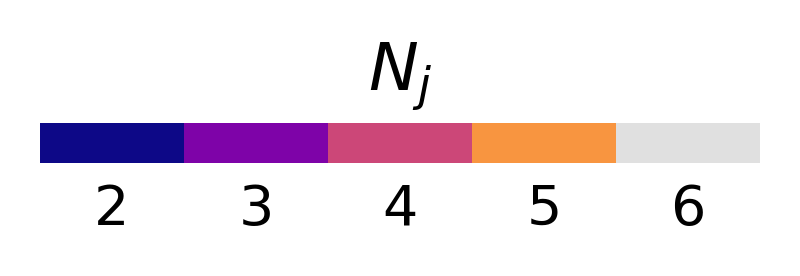

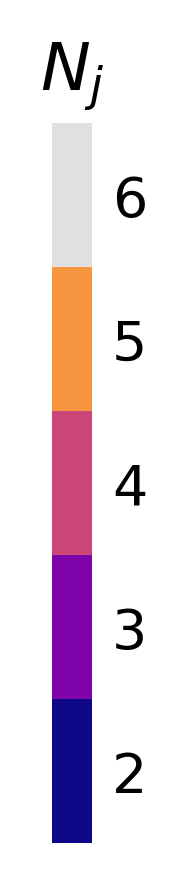

In [10]:
def get_newcmp(origcmap='plasma',newcmapname='newcmp',cyclic=False,crop=False,bottom=0,top=245,replace=True,r=100,g=100,b=100,a=1):
    newcolors = cm.get_cmap(origcmap, 256)(np.linspace(0, 1, 256))
    if crop:
        newcolors=newcolors[bottom:top,:]
    if replace:
        if not cyclic:
            newcolors[-25:, :] = np.array([r/256, g/256, b/256, a]) #165, 140, 0, 0.8
        if cyclic:
            newcolors[-25:, :] = np.array([r/256, g/256, b/256, a]) #165, 140, 0, 0.8
            newcolors[:25, :] = np.array([r/256, g/256, b/256, a]) #165, 140, 0, 0.8        
    newcmp = ListedColormap(newcolors)
    plt.register_cmap(name=newcmapname,cmap=newcmp)    
    return newcmp
def standalone_cbar(cmap='RdBu',orientation='vertical',discrete=False,n_clusters=5,vmin=0,vmax=6,title='title'):
    fig = plt.figure(figsize=(2,2),dpi=400)
    if orientation=='vertical':
        ax = fig.add_axes([0.05, 0.80, 0.05, 0.9]) #vertical [left bottom width height]
    if orientation=='horizontal':
        ax = fig.add_axes([0.05, 0.80, 0.9, 0.05]) #horizontal [left bottom width height]   
    
    if not discrete:
        cmap=plt.get_cmap(cmap)
        
        cb = mpl.colorbar.ColorbarBase(ax, orientation=orientation, 
                                       cmap=cmap,norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    if discrete:
        n_clusters=(vmax-vmin)+1
        cmap=plt.get_cmap(cmap, n_clusters)
        
        
        cb = mpl.colorbar.ColorbarBase(ax, orientation=orientation, 
                                       cmap=cmap,norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
                
        # tick_locs = (np.arange(vmin,vmax+1,(vmax-vmin)/n_clusters))+0.5*((vmax-vmin)/n_clusters)
        tick_locs = (np.arange(vmin,vmax,(vmax-vmin)/n_clusters))+0.5*((vmax-vmin)/n_clusters) #tick_locs def changed upon update, so dont include last point
        cb.set_ticks(tick_locs)
        cb.set_ticklabels(np.arange(vmin,vmax+1,1))
    cb.outline.set_visible(False)
    cb.ax.tick_params(size=0)
    cb.ax.set_title(title)
    return cb.get_ticks()
#     plt.savefig(output_dir+'/cbar'+'.png',bbox_inches='tight')  

# if c=='coordnum':
#     vmin,vmax=2,6
# if c=='psi6':
#     vmin,vmax=0,1
# if c=='theta6':
#     vmin,vmax=0,60

newcmp=get_newcmp(origcmap='plasma',newcmapname='newcmp',cyclic=False,r=180,g=180,b=180,a=0.4) #for sector plots
# get_newcmp(origcmap='plasma',newcmapname='newplasma',cyclic=False,crop=True,bottom=0,top=225,replace=False,r=100,g=100,b=100,a=1) #for line plots
get_newcmp(origcmap='viridis',newcmapname='newviridis',cyclic=False,crop=True,bottom=0,top=225,replace=False,r=100,g=100,b=100,a=1) #for line plots
# get_newcmp(origcmap='twilight',newcmapname='newtwilight',cyclic=True,crop=True,bottom=30,top=225,replace=False,r=100,g=100,b=100,a=1) #for line plots
get_newcmp(origcmap='cividis',newcmapname='newcividis',cyclic=False,crop=True,bottom=0,top=225,replace=False,r=100,g=100,b=100,a=1) #for line plots

# standalone_cbar(cmap='newcmp',orientation='horizontal',discrete=False,vmin=2,vmax=6,title='newcmp')
# standalone_cbar(cmap='newplasma',orientation='horizontal',discrete=False,vmin=2,vmax=6,title='newplasma')
# standalone_cbar(cmap='newviridis',orientation='horizontal',discrete=False,vmin=2,vmax=6,title='newviridis')
# standalone_cbar(cmap='newtwilight',orientation='horizontal',discrete=False,vmin=2,vmax=6,title='newtwilight')
# standalone_cbar(cmap='newcividis',orientation='horizontal',discrete=False,vmin=2,vmax=6,title='newcividis')

standalone_cbar(cmap='newcmp',orientation='horizontal',discrete=True,vmin=2,vmax=6,title=r'$N_{j}$')
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/newcmp_horizontal.svg',bbox_inches = "tight")
standalone_cbar(cmap='newcmp',orientation='vertical',discrete=True,vmin=2,vmax=6,title=r'$N_{j}$')
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/newcmp_vertical.svg',bbox_inches = "tight")
# standalone_cbar(cmap='viridis',orientation='vertical',discrete=True,vmin=2,vmax=6,title=r'$N_{ij}$')
# standalone_cbar(cmap='plasma',orientation='horizontal',discrete=False,vmin=0,vmax=1,title=r'$\psi_6$')
# standalone_cbar(cmap='hsv',orientation='horizontal',discrete=False,vmin=0,vmax=60,title=r'$\theta$')

In [11]:
def get_dark_palette(cmp_str,index,ref_n,new_n,reverse): #ref_n is number of discrete colors in reference colormap. new_n is number of new colors in new colormap.
    palette=sns.color_palette(
            sns.dark_palette(
                mpl.colors.to_hex(cm.get_cmap(cmp_str,ref_n)(index)),new_n,reverse=reverse
            )[:new_n]
        )
    return palette
def get_light_palette(cmp_str,index,ref_n,new_n,reverse): #ref_n is number of discrete colors in reference colormap. new_n is number of new colors in new colormap.
    palette=sns.color_palette(
            sns.light_palette(
                mpl.colors.to_hex(cm.get_cmap(cmp_str,ref_n)(index)),new_n,reverse=reverse
            )[:new_n]
        )
    return palette
# phi_palette=get_dark_palette('newcmp',0,5,n)
# theta_palette=get_dark_palette('newcmp',1,5,n)
# c_palette=get_dark_palette('newcmp',2,5,n)

new_n=7
ref_n=5
theta_palette=sns.color_palette((get_dark_palette('newcmp',0,ref_n,new_n,False)[:-1]+get_light_palette('newcmp',0,ref_n,new_n,True))[::-1])
phi_palette=sns.color_palette((get_dark_palette('newcmp',1,ref_n,new_n,False)[:-1]+get_light_palette('newcmp',1,ref_n,new_n,True))[::-1])
c_palette=sns.color_palette((get_dark_palette('newcmp',2,ref_n,new_n,False)[:-1]+get_light_palette('newcmp',2,ref_n,new_n,True)))
psi_palette=sns.color_palette((get_dark_palette('newcmp',3,ref_n,new_n,False)[:-1]+get_light_palette('newcmp',3,ref_n,new_n,True)))


In [12]:
phi_palette

[(0.9471162970700641, 0.9415428442145225, 0.9519250214458869),
 (0.8725047547152716, 0.7884029155480475, 0.9036494815814432),
 (0.7961167470663172, 0.6316167981037992, 0.8542245241011794),
 (0.7215052047115247, 0.47847686943732437, 0.8059489842367358),
 (0.6451171970625704, 0.3216907519930761, 0.7565240267564721),
 (0.5687291894136162, 0.16490463454882792, 0.7070990692762084),
 (0.49411764705882355, 0.011764705882352941, 0.6588235294117647),
 (0.43937457666548785, 0.03282392496085758, 0.5797756052708787),
 (0.38332809983421556, 0.05438455401742187, 0.49884558769806675),
 (0.32858502944087986, 0.07544377309592651, 0.4197976635571808),
 (0.2725385526096075, 0.0970044021524908, 0.3388676459843689),
 (0.21649207577833524, 0.11856503120905508, 0.25793762841155704),
 (0.1617490053849995, 0.13962425028755973, 0.17888970427067105)]

In [13]:
theta_palette

[(0.9428705659152788, 0.9428421564820569, 0.9516094133795071),
 (0.7959710078844809, 0.7927177505470654, 0.8820709771273807),
 (0.6455738413291401, 0.6390189539945739, 0.8108768638216322),
 (0.4986742832983422, 0.48889454805958227, 0.7413384275695057),
 (0.3482771167430014, 0.33519575150709086, 0.6701443142637573),
 (0.1978799501876607, 0.18149695495459944, 0.5989502009580088),
 (0.050980392156862744, 0.03137254901960784, 0.5294117647058824),
 (0.06621902953362095, 0.049771275382849464, 0.4746015521136939),
 (0.0818204916098258, 0.0686080666595016, 0.41848633445978667),
 (0.097059128986584, 0.08700679302274322, 0.36367612186759823),
 (0.11266059106278883, 0.10584358429939536, 0.30756090421369103),
 (0.12826205313899366, 0.12468037557604748, 0.25144568655978383),
 (0.14350069051575187, 0.1430791019392891, 0.1966354739675954)]

In [14]:
c_palette

[(0.17299525674106353, 0.1392887272482819, 0.14775194163408217),
 (0.276266626219006, 0.16220633941546223, 0.20092497823691155),
 (0.3819968378273757, 0.18566960901519447, 0.25536403952076064),
 (0.4877270494357454, 0.20913287861492671, 0.30980310080460977),
 (0.5909984189136879, 0.23205049078210704, 0.36297613740743917),
 (0.6967286305220576, 0.25551376038183926, 0.4174151986912883),
 (0.8, 0.2784313725490196, 0.47058823529411764),
 (0.824602035734818, 0.3876815317308513, 0.5484612958471458),
 (0.849789834225227, 0.49953288517891703, 0.6281884768895317),
 (0.8749776327156359, 0.6113842386269828, 0.7079156579319177),
 (0.8995796684504539, 0.7206343978088146, 0.7857887184849459),
 (0.9247674669408629, 0.8324857512568803, 0.8655158995273319),
 (0.9493695026756809, 0.941735910438712, 0.94338896008036)]

In [15]:
psi_palette

[(0.16463600412169105, 0.1436099681105527, 0.13446128155758122),
 (0.29770403020176317, 0.21619646932602338, 0.15365266447981582),
 (0.43394034261707504, 0.2905112205704338, 0.17330098509067504),
 (0.570176655032387, 0.36482597181484433, 0.1929493057015343),
 (0.7032446811124591, 0.43741247303031494, 0.2121406886237689),
 (0.839480993527771, 0.5117272242747255, 0.23178900923462814),
 (0.9725490196078431, 0.5843137254901961, 0.25098039215686274),
 (0.9690462769558228, 0.6431809836329266, 0.3641063918776156),
 (0.9654601356692305, 0.7034498431600079, 0.4799258677821959),
 (0.9618739943826383, 0.7637187026870892, 0.5957453436867762),
 (0.958371251730618, 0.8225859608298197, 0.7088713434075291),
 (0.9547851104440257, 0.882854820356901, 0.8246908193121094),
 (0.9512823677920054, 0.9417220784996315, 0.9378168190328623)]

In [22]:
os.chdir(input_dir)
#############
####FIG 2####
#############
def uv_wrap(x2D,y2D,ctheta_rad):
    if ctheta_rad!=0:
        x3D=[]
        y3D=[]
        z3D=[]
        for x,y in zip(x2D,y2D): #x,y describe coordinates of flat net of particles
            u,v=[(atan2(y,x)-np.pi/2+ctheta_rad/2)*(2*np.pi/ctheta_rad),np.sqrt(x**2+y**2)] #theta from (0 to +ctheta) then normalized and mapped onto 2pi, r distance from origin
            arclength=v*ctheta_rad #s=r*theta. arclength of sector is circumference of wrapped cone at given point
            cone_r=(arclength/np.pi)/2.0 #radius of 3D CONE, not the radial coord of flat net sector.
            cone_alpha=np.arcsin(ctheta_rad/(2*np.pi)) #alpha is half cone angle (angle of slant from cone vertical). use cone equation from first slide of prof nelson's pdf.
            cone_z=cone_r/np.tan(cone_alpha) #find height of cone. cone_r is radius, v is slant length.             
            x3D+=[cone_r*np.cos(u)] #convert u,v to x,y,z.
            y3D+=[cone_r*np.sin(u)] #convert u,v to x,y,z.
            z3D+=[cone_z] #convert u,v to x,y,z.
    if ctheta_rad==0:
        Lx=params_dict['cinit']
        x3D=[]
        y3D=[]
        z3D=[]
        for x,y in zip(x2D,y2D): #x,y describe coordinates of flat net of particles
            u=(x/Lx)*2*np.pi-np.pi/2
            v=-y            
            #######
            arclength=Lx #s=r*theta. arclength of sector is circumference of wrapped cone at given point
            cone_r=(arclength/np.pi)/2.0 #radius of 3D CONE, not the radial coord of flat net sector.
#             cone_alpha=np.arcsin(ctheta_rad/(2*np.pi)) #alpha is half cone angle (angle of slant from cone vertical). use cone equation from first slide of prof nelson's pdf.
            cone_z=v #find height of cone. cone_r is radius, v is slant length.             
            x3D+=[cone_r*np.cos(u)] #convert u,v to x,y,z.
            y3D+=[cone_r*np.sin(u)] #convert u,v to x,y,z.
            z3D+=[cone_z] #convert u,v to x,y,z.        
    return x3D,y3D,z3D
def plot_sector(data,params_dict,ax,alpha=1,c='coordnum',cmap='viridis'):
    if c=='coordnum':
        vmin,vmax=2,6
    if c=='psi6':
        vmin,vmax=0,1
    if c=='theta6':
        vmin,vmax=0,60
    c=data[c]
    
    # fig=plt.figure(figsize=(5,5),dpi=400)
    if params_dict['cthetadeg']!=0:
        ax.add_patch(patches.Wedge((0,0), -params_dict['R'], 90-params_dict['cthetadeg']/2, 90+params_dict['cthetadeg']/2,fill=False,edgecolor='black',linewidth=0.25))
    if params_dict['cthetadeg']==0:
        Lx=params_dict['cinit']
        Ly=params_dict['R']
        ax.add_patch(patches.Rectangle((-Lx/2,0),Lx,-params_dict['R'],fill=False,edgecolor='black',linewidth=0.25))        
    ax.scatter(data['x'],data['y'],c=c,s=1,alpha=alpha,cmap=cmap,vmin=vmin,vmax=vmax) #plot points
    try:
        ax.scatter(data.loc[0]['x'],data.loc[0]['y'],color='black',s=1,alpha=alpha,zorder=200) #plot seed
        ax.scatter(data.loc[1]['x'],data.loc[1]['y'],color='black',s=1,alpha=alpha,zorder=200) #plot seed
        ax.scatter(data.loc[2]['x'],data.loc[2]['y'],color='black',s=1,alpha=alpha,zorder=200) #plot seed    
    except:
        pass
    ax.set_xlim((np.min(data['x'])-10,np.max(data['x'])+10))
    ax.set_ylim((np.min(data['y'])-10,np.max(data['y'])+10))
    ax.set_aspect('equal')
    ax.set_title(run_dir+'\n'+'thetadeg-'+str(round(params_dict['thetadeg'],1))+'_yinit-'+str(round(params_dict['yinit'],1))+'_R-'+str(round(params_dict['R'],1)),fontsize=5)
    ax.axis('off')
    ax.invert_yaxis()
def plot_cone(data,params_dict,ax,planealpha=0.85,elev_val=0,azim_val=180,alpha=1,cmap='viridis'):
    #plot semitransparent plane. we do this instead of setting alpha of point markers because matplotlib does a weird gradient for transparent markers
    zz,yy = np.meshgrid(range(int(np.min(data['z3D'])-10),int(np.max(data['z3D'])+10)), range(int(np.min(data['y3D'])-10),int(np.max(data['y3D'])+10)))
    xx = yy*0
    ax.plot_surface(xx, yy, zz,alpha=planealpha,color='w',shade=False,antialiased=False,linewidth=0,edgecolor=None,rstride=100,cstride=100) #if the alpha set for overall figure is 1, have a semitransparent plane. otherwise set the plane alpha value to half of that of the datapoint alpha value (input).
        
    #set axis limits based on data bounds
    ax.set_xlim((np.min(data['x3D'])-2,np.max(data['x3D'])+2))
    ax.set_ylim((np.min(data['y3D'])-2,np.max(data['y3D'])+2))
    ax.set_zlim((np.min(data['z3D'])-2,np.max(data['z3D'])+2))    

    #     ax.set_aspect('equal')
    ax.set_box_aspect((ax.get_xlim()[1]-ax.get_xlim()[0],ax.get_ylim()[1]-ax.get_ylim()[0],ax.get_zlim()[1]-ax.get_zlim()[0]))

    
    #filter points based on front or back
    data_back=data[data['x3D']>=0] #back of 3D cone
    data_front=data[data['x3D']<0] #front of 3D cone
    data=data_back #i use data.loc which is label-based later, so it won't plot seeds if it's not in the range
    # fig=plt.figure(figsize=(4,4),dpi=400)
    #     ax.add_patch(patches.Wedge((0,0), -params_dict['R'], 90-params_dict['cthetadeg']/2, 90+params_dict['cthetadeg']/2,fill=False,edgecolor='black',linewidth=0.25))
    data_list=[(data_back,alpha*1), (data_front,alpha)] #alpha controls POINTS alpha
    
    #plot points based on front or back
    for data,alpha in data_list:
        try:
            #plot datapoints
            ax.scatter3D(data.loc[3:]['x3D'],data.loc[3:]['y3D'],data.loc[3:]['z3D'],c=data.loc[3:]['coordnum'],s=1,alpha=alpha,cmap=cmap) #plot points
            ax.scatter3D(data.loc[0:2]['x3D'],data.loc[0:2]['y3D'],data.loc[0:2]['z3D'],color='black',s=1,alpha=alpha) #plot seed               
        except:
            continue
    ax.set_title(run_dir+'\n'+'thetadeg-'+str(round(params_dict['thetadeg'],1))+'_yinit-'+str(round(params_dict['yinit'],1))+'_R-'+str(round(params_dict['R'],1)),fontsize=5)
    ax.axis('off')
    ax.invert_yaxis()
    ax.invert_xaxis()
    
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')    
#     ax.set_zlabel('z')    
    ax.view_init(elev=elev_val,azim=azim_val)      
def plot_seed(data,params_dict,alpha=1,c='coordnum',cmap='viridis'):
    fig=plt.figure(figsize=(1.5,1.5),dpi=400)
    ax=fig.add_subplot(111)    
    #seed vectors
    data=data[:3] #take only seeds of the dataset
    seed0x, seed0y=data.loc[0]['x'],data.loc[0]['y']
    seed1x, seed1y=data.loc[1]['x'],data.loc[1]['y']
    seed2x, seed2y=data.loc[2]['x'],data.loc[2]['y']
    
    if c=='coordnum':
        vmin,vmax=2,6
    if c=='psi6':
        vmin,vmax=0,1
    if c=='theta6':
        vmin,vmax=0,60
    c=data[c]
    seedR=np.sqrt(seed0x**2+seed0y**2)
    # fig=plt.figure(figsize=(5,5),dpi=400)
#     if params_dict['cthetadeg']!=0:
# #         ax.add_patch(patches.Wedge((0,0), -seedR, 90-params_dict['cthetadeg']/2, 90+params_dict['cthetadeg']/2,fill=False,edgecolor='black',linewidth=0.25))
#         ax.add_patch(patches.Arc((0,0), -2*seedR,-2*seedR, angle=0,theta1=90-params_dict['cthetadeg']/2-10, theta2=90+params_dict['cthetadeg']/2+10,fill=False,edgecolor='black',linestyle='--',linewidth=0.25))
#     if params_dict['cthetadeg']==0:
#         Lx=params_dict['cinit']
#         Ly=params_dict['R']
#         ax.add_patch(patches.Rectangle((-Lx/2,0),Lx,-params_dict['R'],fill=False,edgecolor='black',linewidth=0.25))
#     ax.scatter(data['x'],data['y'],c=c,s=1,alpha=alpha,cmap=cmap,vmin=vmin,vmax=vmax) #plot points
    try:
        ax.scatter(seed0x,seed0y,color='black',s=50,alpha=alpha) #plot seed
        ax.scatter(seed1x,seed1y,color='black',s=50,alpha=alpha) #plot seed
        ax.scatter(seed2x,seed2y,color='black',s=50,alpha=alpha) #plot seed    

#         ax.annotate("", xy=(2*(seed1x-seed0x)+seed0x,seed0y), xytext=(-2*(seed1x-seed0x)+seed0x, seed0y),arrowprops=dict(arrowstyle="-",color='0.3'),zorder=0) #plot ref line        
        ellipsewidth=5*(seed1x-seed0x)
        ellipseheight=0.5
        ellipse=mpl.patches.Ellipse((seed0x,seed0y-ellipseheight/2),ellipsewidth,ellipseheight, angle=0,zorder=0,edgecolor='0.3',linewidth=1,facecolor='none')        
        ax.add_patch(ellipse)
        ax.annotate("", xy=(2*(seed1x-seed0x)+seed0x,2*(seed1y-seed0y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow
        ax.annotate("", xy=(-2*(seed1x-seed0x)+seed0x,-2*(seed1y-seed0y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow        
        
        ax.annotate("", xy=(2*(seed2x-seed0x)+seed0x,2*(seed2y-seed0y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow
        ax.annotate("", xy=(-2*(seed2x-seed0x)+seed0x,-2*(seed2y-seed0y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow        

        ax.annotate("", xy=(2*(seed2x-seed1x)+seed0x,2*(seed2y-seed1y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow
        ax.annotate("", xy=(-2*(seed2x-seed1x)+seed0x,-2*(seed2y-seed1y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",linewidth=0.5)) #plot arrow                
#     #rotate vector to find the reference line
#     initx=seed1x - seed0x
#     inity=seed1y - seed0y
#     refx, refy = initx*np.cos(params_dict['ithetadeg']) - inity*np.sin(params_dict['ithetadeg']), initx*np.sin(params_dict['ithetadeg']) + inity*np.cos(params_dict['ithetadeg'])    
#     refx, refy = refx+seed0x, refy+seed0y
        
#         ax.annotate("", xy=(2*(refx-seed0x)+seed0x,2*(refy-seed0y)+seed0y), xytext=(seed0x, seed0y),arrowprops=dict(arrowstyle="->",color='grey')) #plot arrow        
    except:
        pass
    ax.set_xlim(seed0x-3,seed0x+3)
    ax.set_ylim((seed0y-3),seed0y+3)
    ax.set_aspect('equal')
    ax.set_title(run_dir+'\n'+'thetadeg-'+str(round(params_dict['thetadeg'],1))+'_yinit-'+str(round(params_dict['yinit'],1))+'_R-'+str(round(params_dict['R'],1)),fontsize=5)
    ax.axis('off')
    ax.invert_yaxis()
    
cthetadeg=10
cinit=12
ithetadeg=40
trial=0

run_dir_df_filtered=run_dir_df[
    (run_dir_df['cthetadeg']==cthetadeg)
    &(run_dir_df['cinit']==cinit)
    &(run_dir_df['ithetadeg']==ithetadeg)
    &(run_dir_df['trial']==trial)]

run_dir=run_dir_df_filtered['run_dir'].iloc[0]
params_dict=get_params_dict(run_dir)
data,adj=load_data(run_dir)
data['x3D'],data['y3D'],data['z3D']=uv_wrap(data['x'],data['y'],params_dict['cthetadeg']*np.pi/180)

In [23]:
cmap=newcmp

# ############
# ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# dataslice,adj=load_data_slice(run_dir,4)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_sector(dataslice[:3],params_dict,ax,alpha=1,cmap=cmap)
# plot_sector(data,params_dict,ax,alpha=0) #set bounds
# Nactual=len(dataslice[:3])
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(4,4),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# dataslice,adj=load_data_slice(run_dir,4)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_cone(dataslice[:3],params_dict,ax,azim_val=180,alpha=1,planealpha=0,cmap=cmap) #planealpha controls the white separator between frnot and back of cone
# plot_cone(data,params_dict,ax,alpha=0,planealpha=0,azim_val=180) #set bounds
# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')

# # ############
# # ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# dataslice,adj=load_data_slice(run_dir,100)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_sector(dataslice[:100],params_dict,ax,alpha=1,cmap=cmap)
# plot_sector(data,params_dict,ax,alpha=0) #set bounds
# Nactual=len(dataslice[:100])
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(4,4),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# dataslice,adj=load_data_slice(run_dir,100)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_cone(dataslice[:100],params_dict,ax,azim_val=180,alpha=1,cmap=cmap)
# plot_cone(data,params_dict,ax,alpha=0,planealpha=0,azim_val=180) #set bounds
# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')
# ############
# ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# dataslice,adj=load_data_slice(run_dir,200)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_sector(dataslice[:200],params_dict,ax,alpha=1,cmap=cmap)
# plot_sector(data,params_dict,ax,alpha=0) #set bounds
# Nactual=len(dataslice[:200])
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(4,4),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# dataslice,adj=load_data_slice(run_dir,200)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_cone(dataslice[:200],params_dict,ax,azim_val=180,alpha=1,cmap=cmap)
# plot_cone(data,params_dict,ax,alpha=0,planealpha=0,azim_val=180) #set bounds
# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')
# ############
# ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# dataslice,adj=load_data_slice(run_dir,400)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_sector(dataslice[:400],params_dict,ax,alpha=1,cmap=cmap)
# plot_sector(data,params_dict,ax,alpha=0) #set bounds
# Nactual=len(dataslice[:400])
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(4,4),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# dataslice,adj=load_data_slice(run_dir,400)
# dataslice['x3D'],dataslice['y3D'],dataslice['z3D']=uv_wrap(dataslice['x'],dataslice['y'],params_dict['cthetadeg']*np.pi/180)
# plot_cone(dataslice[:400],params_dict,ax,azim_val=180,alpha=1,cmap=cmap)
# plot_cone(data,params_dict,ax,alpha=0,planealpha=0,azim_val=180) #set bounds
# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')
# ############
# ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,cmap=cmap)
# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(4,4),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# plot_cone(data,params_dict,ax,azim_val=180,cmap=cmap)
# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')

# ############
# fig=plt.figure(figsize=(1.5,1.5),dpi=400)
# ax=fig.add_subplot(111)
# plot_seed(data,params_dict,ax)
# ############

In [26]:
def get_reference_range(cthetadeg=0,cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0],ithetadeg=30,trial=0):
    #get reference dimensions
#     cthetadeg=0
#     cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0] #5qsrt3
#     ithetadeg=30
#     trial=0

    run_dir_df_filtered=run_dir_df[
        (run_dir_df['cthetadeg']==cthetadeg)
        &(run_dir_df['cinit']==cinit)
        &(run_dir_df['ithetadeg']==ithetadeg)
        &(run_dir_df['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)
    #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
    #             fig8_data=pd.DataFrame([fig8_dict])
    #             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='viridis')

    datarange=max(data['y'])-min(data['y'])
#     ax.set_ylim((max(data['y'])-datarange)-10,(max(data['y']))+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..

#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    #     plt.show()
#     plt.savefig(output_dir+'/fig8b_cylinder_'+info_tag+'.png')
    return datarange

#set consistent ylim so that the points are scaled the same way
reference_range=get_reference_range(cthetadeg=0,cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0],ithetadeg=30,trial=0)
print('reference_range set')

def plot_arc(data,params_dict,ax,alpha=1,c='coordnum',cmap='viridis'):
    #seed vectors
    data=data[:3] #take only seeds of the dataset
    seed0x, seed0y=data.loc[0]['x'],data.loc[0]['y']
    seed1x, seed1y=data.loc[1]['x'],data.loc[1]['y']
    seed2x, seed2y=data.loc[2]['x'],data.loc[2]['y']
    
    if c=='coordnum':
        vmin,vmax=2,6
    if c=='psi6':
        vmin,vmax=0,1
    if c=='theta6':
        vmin,vmax=0,60
    c=data[c]
    seedR=np.sqrt(seed0x**2+seed0y**2)
    ax.add_patch(patches.Arc((0,0), -2*seedR,-2*seedR, angle=0,theta1=90-params_dict['cthetadeg']/2, theta2=90+params_dict['cthetadeg']/2,fill=False,edgecolor='0.3',linestyle='-',linewidth=1))
def plot_circ(data,params_dict,ax,alpha=1,c='coordnum',cmap='viridis'): #don't know why this doesn't work
    #seed vectors
    data=data[:3] #take only seeds of the dataset
    seed0x, seed0y=data.loc[0]['x'],data.loc[0]['y']
    seed1x, seed1y=data.loc[1]['x'],data.loc[1]['y']
    seed2x, seed2y=data.loc[2]['x'],data.loc[2]['y']
    
    if c=='coordnum':
        vmin,vmax=2,6
    if c=='psi6':
        vmin,vmax=0,1
    if c=='theta6':
        vmin,vmax=0,60
    c=data[c]
    seedR=np.sqrt(seed0x**2+seed0y**2)
    cone_r=(params_dict['cinit']/(2*np.pi))
# #     circle=patches.Circle((0,0),params_dict['cinit']/(2*np.pi),fill=False,edgecolor='black',linestyle='-',linewidth=1)
#     circle=patches.Circle((0,0),cone_r,facecolor='k',linewidth=100)
#     ax.add_patch(circle)
    
#     #convert to 3D patch
    ctheta_rad=params_dict['cthetadeg']*np.pi/180

    cone_alpha=np.arcsin(ctheta_rad/(2*np.pi)) #alpha is half cone angle (angle of slant from cone vertical). use cone equation from first slide of prof nelson's pdf.
    cone_z=cone_r/np.tan(cone_alpha)
    
    circle_theta=np.linspace(-3*np.pi/2,-np.pi/2,100)
    circle_x=cone_r*np.cos(circle_theta)
    circle_y=cone_r*np.sin(circle_theta)
    circle_z=np.repeat(cone_z,len(circle_theta))
    ax.plot(circle_x,circle_y,circle_z,color='0.3',zorder=15,linewidth=0.8) #circumference circle

    circle_theta=np.linspace(-np.pi/2,np.pi/2,100)
    circle_x=cone_r*np.cos(circle_theta)
    circle_y=cone_r*np.sin(circle_theta)
    circle_z=np.repeat(cone_z,len(circle_theta))
    ax.plot(circle_x,circle_y,circle_z,color='0.3',zorder=15,linewidth=0.8,alpha=0.73) #circumference circle
    
    
    ax.plot(data.loc[0:2]['x3D'],data.loc[0:2]['y3D'],data.loc[0:2]['z3D'],markersize=1,color='black',alpha=alpha,zorder=15) #plot seed                   
# #     circle=patches.Circle((0,0),params_dict['cinit']/(2*np.pi),fill=False,edgecolor='black',linestyle='-',linewidth=1)
#     circle=patches.Circle((0,0),cone_r,facecolor='k',linewidth=100)
# #     ax.add_patch(circle)        
#     art3d.pathpatch_2d_to_3d(circle, z=cone_z, zdir='z')    

# cthetadeg=60 #magic angle
# cinit_options=np.unique(run_dir_df['cinit'])
# cinit=cinit_options[-3]
# ithetadeg=30
# trial=0

# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']==cthetadeg)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==ithetadeg)
#     &(run_dir_df['trial']==trial)]

# run_dir=run_dir_df_filtered['run_dir'].iloc[0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir,shifted=False)
# data['x3D'],data['y3D'],data['z3D']=uv_wrap(data['x'],data['y'],params_dict['cthetadeg']*np.pi/180)

# ############
# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,cmap=cmap)
# plot_arc(data,params_dict,ax,cmap=cmap)
# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10)
# ax.invert_yaxis()
# plt.savefig(output_dir+'/fig2a'+info_tag+'.png')

# fig=plt.figure(figsize=(2,2),dpi=400)
# ax=fig.add_subplot(111,projection='3d')
# plot_cone(data,params_dict,ax,azim_val=180,elev_val=7,cmap=cmap)
# plot_circ(data,params_dict,ax,alpha=1,c='coordnum',cmap='viridis')

# plt.savefig(output_dir+'/fig2b'+info_tag+'.png')

# ############
# plot_seed(data,params_dict)
# ############

reference_range set


reference_range set


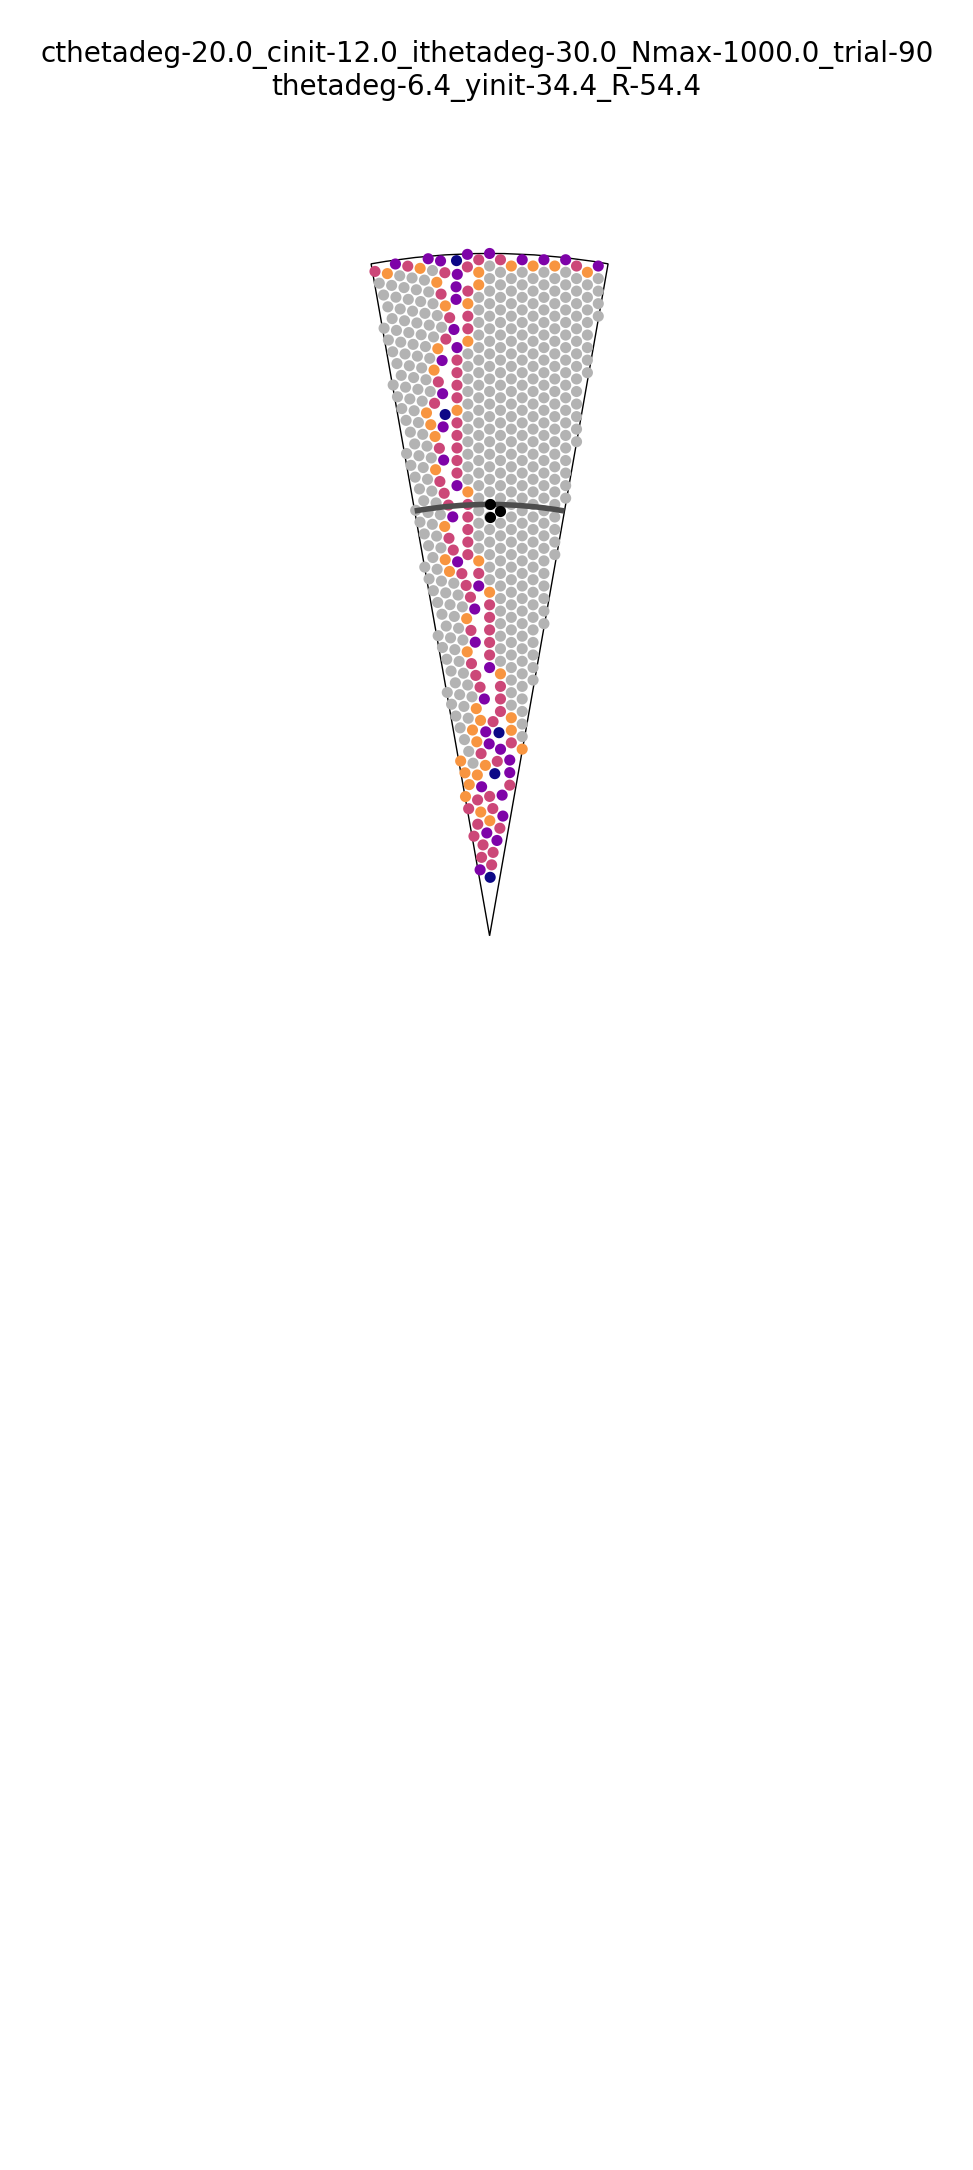

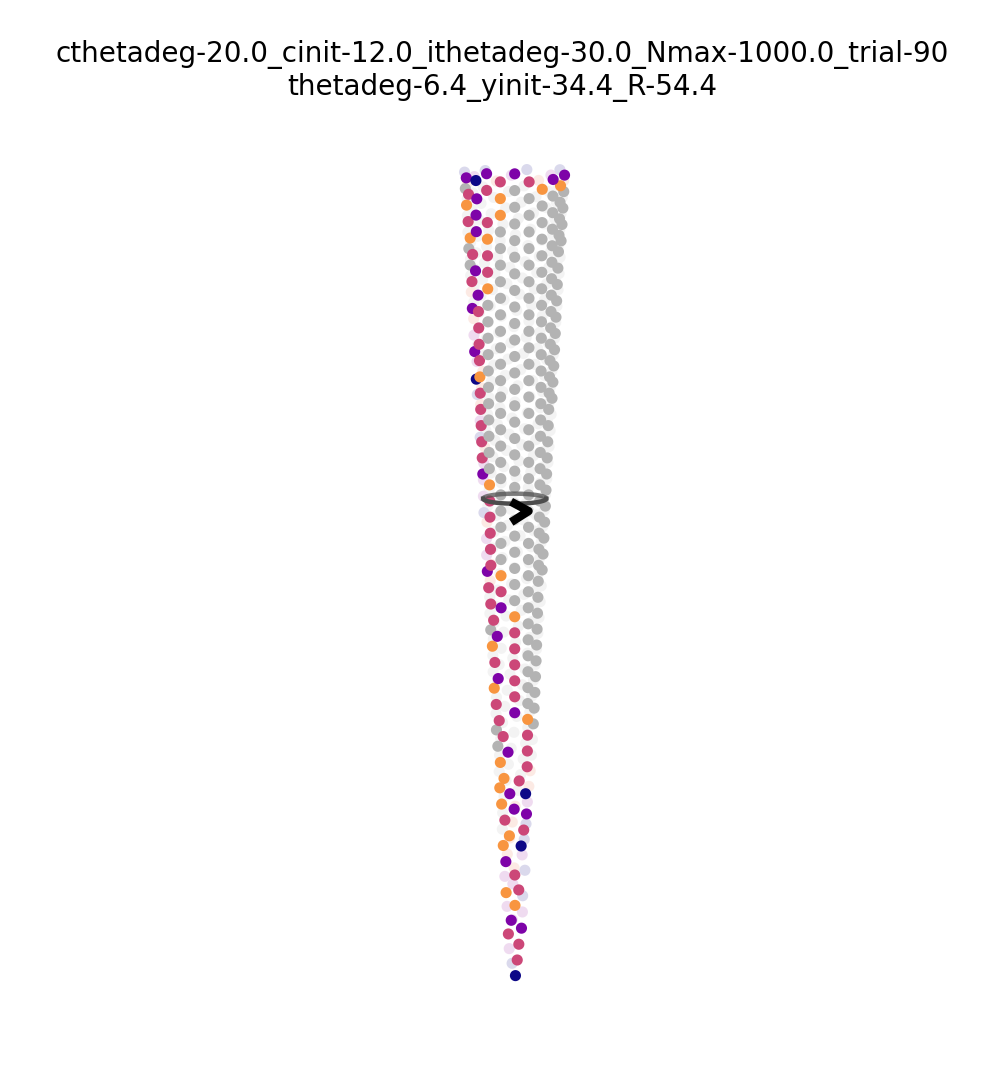

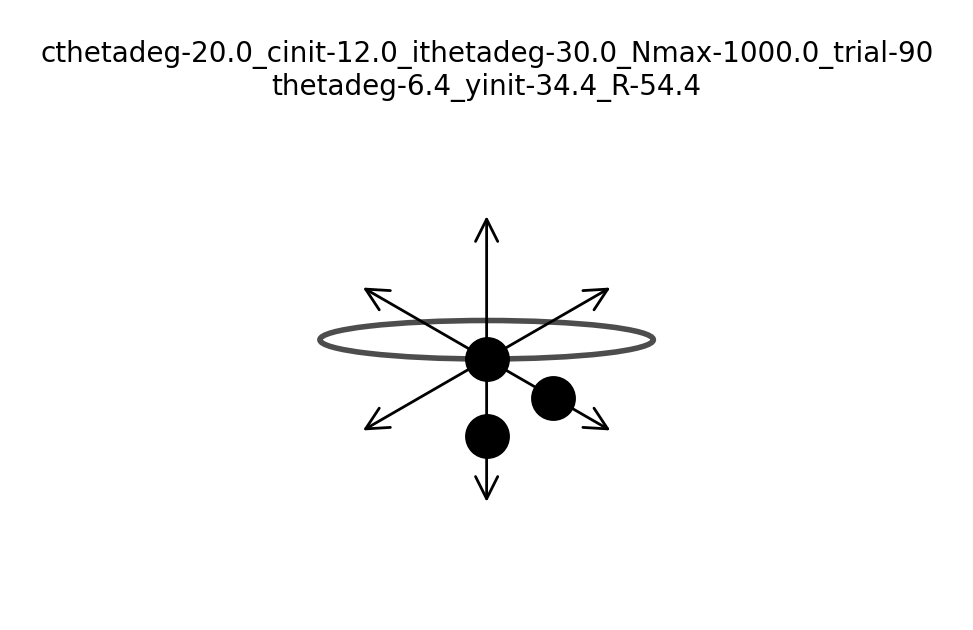

In [27]:
reference_range=get_reference_range(cthetadeg=0,cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0],ithetadeg=30,trial=0)
print('reference_range set')
# trial_list=[12,17,23,33,56,79,90]
trial_list=[90]
for trial in trial_list:
    cthetadeg=20
    cinit=12
    ithetadeg=30
    trial=trial

    run_dir_df_filtered=run_dir_df[
        (run_dir_df['cthetadeg']==cthetadeg)
        &(run_dir_df['cinit']==cinit)
        &(run_dir_df['ithetadeg']==ithetadeg)
        &(run_dir_df['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'].iloc[0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir,shifted=False)
    data['x3D'],data['y3D'],data['z3D']=uv_wrap(data['x'],data['y'],params_dict['cthetadeg']*np.pi/180)

    ############
    fig=plt.figure(figsize=(6.5,6.5),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,cmap=cmap)
    plot_arc(data,params_dict,ax,cmap=cmap)
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50)
    ax.invert_yaxis()
    # plt.savefig(output_dir+'/fig2a'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig1sector.svg',bbox_inches = "tight")

    fig=plt.figure(figsize=(3,3),dpi=400)
    ax=fig.add_subplot(111,projection='3d')
    plot_cone(data,params_dict,ax,azim_val=180,cmap=cmap)
    plot_circ(data,params_dict,ax,alpha=1,c='coordnum',cmap='viridis')
    plot_cone(data,params_dict,ax,alpha=0,planealpha=0,azim_val=180,elev_val=10) #set bounds
#     plt.savefig(output_dir+'/fig2b'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig1cone.svg',bbox_inches = "tight")

    ###########
    plot_seed(data,params_dict)
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig1seed.svg',bbox_inches = "tight")
    ############
    plt.show()

In [28]:
#############
####FIG 3####
#############
def rotate_point(r,theta,rotatethetadeg):
    y=r*np.sin(theta+rotatethetadeg*np.pi/180)
    x=r*np.cos(theta+rotatethetadeg*np.pi/180)
    return x,y
def find_images(data,params_dict):
    #find image particles in order to find theta6, psi6, and grain size later
    data['r']=np.sqrt(data['x']**2+data['y']**2)
    data['theta']=np.arctan2(data['y'],data['x'])
    if params_dict['cthetadeg']!=0:
        data['circ']=data['r']*params_dict['cthetadeg']*np.pi/180
        data['x_left'],data['y_left']=rotate_point(data['r'],data['theta'],-params_dict['cthetadeg'])
        data['x_right'],data['y_right']=rotate_point(data['r'],data['theta'],+params_dict['cthetadeg'])
    if params_dict['cthetadeg']==0:
        Lx=params_dict['cinit']
        data['circ']=Lx
        data['x_left'],data['y_left']=data['x']-Lx,data['y']
        data['x_right'],data['y_right']=data['x']+Lx,data['y']
    return data
def select_image(particle, neighbor):
    #find distances between particle of interest and its neighbors, checking the neighbor images as well
    distsquared=(neighbor['x']-particle['x'])**2+(neighbor['y']-particle['y'])**2
    distsquared_left=(neighbor['x_left']-particle['x'])**2+(neighbor['y_left']-particle['y'])**2
    distsquared_right=(neighbor['x_right']-particle['x'])**2+(neighbor['y_right']-particle['y'])**2
    distsquared_list=[distsquared,distsquared_left,distsquared_right]
    distsquared_min=min(distsquared_list)
    if distsquared_list.index(distsquared_min)==0:
        return neighbor['x'],neighbor['y']
    if distsquared_list.index(distsquared_min)==1:
        return neighbor['x_left'],neighbor['y_left']
    if distsquared_list.index(distsquared_min)==2:
        return neighbor['x_right'],neighbor['y_right']
def get_data_neighbors(particle_idx,data,adj,run_dir):
    particle=data.loc[particle_idx,:]
    neighbor_idx_list=np.nonzero(adj[particle_idx])[0]
    # data_neighbors=pd.DataFrame(columns=data.columns) #don't grow a dataframe....
    data_neighbors_list=[]
    for neighbor_idx in neighbor_idx_list:
        neighbor=data.loc[neighbor_idx,:].copy()
        neighbor['select_x'],neighbor['select_y']=select_image(particle,neighbor)
        # data_neighbors=data_neighbors.append(neighbor) #deprecated, but also, don't grow a dataframe ...
        data_neighbors_list+=[neighbor]
    data_neighbors=pd.concat(data_neighbors_list,axis=1).T.reset_index()
    # data_neighbors=pd.concat(data_neighbors_list,ignore_index=True)    
    return data_neighbors
def get_theta6_psi6(data,adj,run_dir):
    for particle_idx in range(len(data)):
        angle_deg_list=[]
        psi6_list=[]
        vector_list=[]
        data_neighbors=get_data_neighbors(particle_idx,data,adj,run_dir) #find positions of neighboring particles (including the image position)
        particle=data.loc[particle_idx,:]
        for neighbor_idx in range(len(data_neighbors)):
            neighbor=data_neighbors.iloc[neighbor_idx,:] #select by row number not actual index label
            x,y=particle['x'],particle['y']
            i,j=neighbor['select_x'],neighbor['select_y']
            vector=(i-x,j-y) #vector for (x,y) point to (i,j) neighbor
            angle=np.arctan2(vector[1],vector[0])
            angle_deg_list+=[(angle*180/np.pi)%(60)] #account for 6-fold symmetry
            psi6_list+=[np.exp(complex(0,6*angle))] #in rad. psi6 just converts angle to number from 0 to 1, accounting for 6-fold symmetry
        data.loc[particle_idx,'theta6']=circmean(angle_deg_list,high=60,low=0) #circular mean
        data.loc[particle_idx,'psi6']=abs(np.mean(psi6_list))
    return data
def find_defect_density(data,bin_parameter,params_dict,psi6cutoff=0.7): #doesn't work on cylinders bc pure cylinders can't be parametrized by r (distance from vertex)
    if bin_parameter=='r': #it makes sense to discretize bins based on r=a0=1, in this case binwidth=1
        bins=np.arange(0,np.max(abs(data['r'])),1)
    if bin_parameter=='circ': #based on r binning
        if params_dict['cthetadeg']!=0:
            bins=np.arange(0,np.max(abs(data['r'])),1)*params_dict['cthetadeg']*np.pi/180
        if params_dict['cthetadeg']==0:
            bins=np.arange(0,np.max(abs(data['circ'])),1)
    data_count,bin_edges=np.histogram(abs(data[bin_parameter]), bins=bins)
    defect_count,bin_edges=np.histogram(abs(data[data['psi6']<psi6cutoff][bin_parameter]), bins=bins)
    data_count[np.where(data_count==0)]=-1 #gets rid of division by 0 errors, since in defect_density 0/-1=0
    defect_density=defect_count/data_count
    return defect_count,data_count,defect_density,bin_edges,psi6cutoff
def plot_defect_density(defect_density,bin_edges,bin_parameter,title,ax,psi6cutoff):
    midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum
    ax.bar(bin_edges[:-1]+midpoint, defect_density, width = 1)
    ax.set_xlim(min(bin_edges), max(bin_edges))
    ax.set_ylim(0,1.05)
    ax.set_xlabel(bin_parameter)
    ax.set_ylabel('Defect density ('+r'$\psi_6$'+'<'+str(psi6cutoff)+')')
    ax.set_title(title+'\n')
#     plt.show()
def plot_defect_count(defect_count,bin_edges,bin_parameter,title,ax,psi6cutoff):
    midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum    
    ax.bar(bin_edges[:-1]+midpoint, defect_count, width = 1)
    ax.set_xlim(min(bin_edges), max(bin_edges))
    ax.set_ylim(0,10)
    ax.set_xlabel(bin_parameter)
    ax.set_ylabel('Defect count ('+r'$\psi_6$'+'<'+str(psi6cutoff)+')')
    ax.set_title(title+'\n')
#     plt.show()    
def plot_gaussiankde(data,bin_parameter,ax,psi6cutoff=0.7): #plot_defect_density and plot_defect_count are manual binning histograms. the pandas implementation of gaussian KDE is an automatic method
    data[data['psi6']<psi6cutoff][bin_parameter].plot.kde(ax=ax,label=r'$\psi_6$'+'<'+str(psi6cutoff),bw_method=0.1)
    #     ## scipy implementation
    #     gkde=stats.gaussian_kde(data[data['psi6']<psi6cutoff]['circ'].tolist())
    #     ind=np.linspace(0,15,10)
    #     kdepdf = gkde.evaluate(ind)
    #     plt.plot(ind, kdepdf, label='kde', color="g",alpha=0.5,zorder=1)
def psi6cutoff_kde(data,psi6cutoff_list=np.linspace(0.5,0.9,5)):    
    figKDE=plt.figure(figsize=(10,5),dpi=400)
    axKDE_r=figKDE.add_subplot(121)
    axKDE_r.set_xlabel('r')
    axKDE_r.set_title('KDE of defects by '+r'$\psi_6$'+' cutoff, binned by r')
    
    axKDE_circ=figKDE.add_subplot(122)    
    axKDE_circ.set_xlabel('circ')
    axKDE_cir
    c.set_title('KDE of defects by '+r'$\psi_6$'+' cutoff, binned by circ')

    for psi6cutoff in psi6cutoff_list:
        #plot KDE of defects binned by r and circ
        plot_gaussiankde(data,'r',axKDE_r,psi6cutoff)
        plot_gaussiankde(data,'circ',axKDE_circ,psi6cutoff) 
    axKDE_r.legend()
    axKDE_circ.legend()
    plt.savefig(output_dir+'/fig_3c_psi6cutoffkde.png')    
    

In [29]:
# #############
# ####FIG 4####
# #############
# cthetadeg=60
# ithetadeg_list=[0,10,20]
# trial=0

# cinit_options=np.unique(run_dir_df['cinit'])
# cinit=cinit_options[np.where((cinit_options>=7.2)&(cinit_options<7.3))][0]

# for ithetadeg in ithetadeg_list:
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==trial)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    
#     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='theta6',cmap='hsv')
#     plt.savefig(output_dir+'/fig4b'+info_tag+'.png')

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='viridis')
#     plt.savefig(output_dir+'/fig4c'+info_tag+'.png')

In [30]:
# #############
# ####FIG 5####
# #############
# cthetadeg=60
# ithetadeg=20
# trial=0
# cinit=7

# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']==cthetadeg)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==ithetadeg)
#     &(run_dir_df['trial']==trial)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)

# plt.savefig(output_dir+'/fig5a'+info_tag+'.png')

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='theta6',cmap='hsv')
# plt.savefig(output_dir+'/fig5b'+info_tag+'.png')

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='coordnum',cmap='viridis')
# plt.savefig(output_dir+'/fig5c'+info_tag+'.png')
# ####
# cthetadeg=60
# ithetadeg=60
# trial=0
# cinit_options=np.unique(run_dir_df['cinit'])
# cinit=cinit_options[np.where((cinit_options>=6.3)&(cinit_options<6.4))][0]

# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']==cthetadeg)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==ithetadeg)
#     &(run_dir_df['trial']==trial)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)

# plt.savefig(output_dir+'/fig5a'+info_tag+'.png')

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='theta6',cmap='hsv')
# plt.savefig(output_dir+'/fig5b'+info_tag+'.png')

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='coordnum',cmap='viridis')
# plt.savefig(output_dir+'/fig5c'+info_tag+'.png')

In [31]:
#############
####FIG 6####
#############
def magic_cinit_list(cinit_min=5,cinit_max=12):
#     #cinit range
#     cinit_min=5
#     cinit_max=12

    #for magic cylinders
    magic_cinit_list=np.arange(0,cinit_max+10,np.sqrt(3))
    
    sympy_key=[]
    sympy_val=[]
    for num in range(len(magic_cinit_list)):
        sympy_key+=[num*np.sqrt(3)]
        sympy_val+=[num*sympy.sqrt(3)]

    magic_cinit_list=np.append(magic_cinit_list,np.arange(0,cinit_max+10,1))
    for num in range(cinit_max+10):
        sympy_key+=[num]
        sympy_val+=[num] 
        
    magic_cinit_list=np.unique(magic_cinit_list)
    magic_cinit_dict=dict(zip(sympy_key,sympy_val))
#     #for magic cones - note that yinit changes with cone angle (i.e. low cone angles will initialize at very large yinit for a fixed circumference)
#     magic_yinit_list=np.arange(0,cinit_max+10,np.sqrt(3)/2)
#     magic_yinit_list=np.append(magic_yinit_list,np.arange(0,cinit_max+10,1))
#     magic_yinit_list=np.unique(magic_yinit_list)

#     #convert yinit_list to cinit_list for cthetadeg=60, since that's the magic cone angle that yinit concerns, then append to list.
#     magic_cinit_list=np.append(magic_cinit_list,magic_yinit_list*(60/180*np.pi))

    #filter based on cinit range
    magic_cinit_list=magic_cinit_list[np.where((magic_cinit_list<=cinit_max)&(magic_cinit_list>=cinit_min))]
    magic_cinit_list=np.unique(magic_cinit_list)

    if 5*np.sqrt(3) in magic_cinit_list: #ithetadeg=60 magic cylinder case
        print('#ithetadeg=60 magic cylinder case included')
    if 5 in magic_cinit_list: #ithetadeg=0 magic cylinder case
        print('#ithetadeg=0 magic cylinder case included')
    if 7*np.sqrt(3)/2*(60/180*np.pi) in magic_cinit_list: #ithetadeg=0 magic cone case
        print('#ithetadeg=0 magic cone case included')
    if 7*(60/180*np.pi) in magic_cinit_list: #ithetadeg=60 magic cone case
        print('#ithetadeg=60 magic cone case included')
    return magic_cinit_list,magic_cinit_dict
magic_cinit_list,magic_cinit_dict=magic_cinit_list()
print('\n\nmagic_cinit_dict is a dictionary of np value: sympy value for finding increments of sqrt(3)','\n\n',magic_cinit_dict,'\n\nmagic_yinit_list currently not supported - edit this function later')

#ithetadeg=60 magic cylinder case included
#ithetadeg=0 magic cylinder case included


magic_cinit_dict is a dictionary of np value: sympy value for finding increments of sqrt(3) 

 {0.0: 0, 1.7320508075688772: sqrt(3), 3.4641016151377544: 2*sqrt(3), 5.196152422706632: 3*sqrt(3), 6.928203230275509: 4*sqrt(3), 8.660254037844386: 5*sqrt(3), 10.392304845413264: 6*sqrt(3), 12.12435565298214: 7*sqrt(3), 13.856406460551018: 8*sqrt(3), 15.588457268119894: 9*sqrt(3), 17.32050807568877: 10*sqrt(3), 19.05255888325765: 11*sqrt(3), 20.784609690826528: 12*sqrt(3), 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21} 

magic_yinit_list currently not supported - edit this function later


In [32]:
# ####
# # find fig6_data
# #### (might take a long time... <4 hours though)
# # fig6_data_list=[]
# # counter=0
# # start=time.time()

# # cthetadeg=60
# # ithetadeg_list=np.unique(run_dir_df['ithetadeg'])
# # trials_list=np.unique(run_dir_df['trial'])

# # cinit_options=np.unique(run_dir_df['cinit'])
# # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]
# # for cinit in cinit_list:
# #     counter+=1
# #     print(counter,'/',len(cinit_list),end='...')
    
# #     for trial in trials_list:
# #         for ithetadeg in ithetadeg_list:
# #             run_dir_df_filtered=run_dir_df[
# #                 (run_dir_df['cthetadeg']==cthetadeg)
# #                 &(run_dir_df['cinit']==cinit)
# #                 &(run_dir_df['ithetadeg']==ithetadeg)
# #                 &(run_dir_df['trial']==trial)]

# #             run_dir=run_dir_df_filtered['run_dir'][0]
# #             params_dict=get_params_dict(run_dir)
# #             data,adj=load_data(run_dir)
# #             data=find_images(data,params_dict)
# #             data=get_theta6_psi6(data,adj,run_dir)

# #             fig6_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig6_data=pd.DataFrame([fig6_dict])
# #             fig6_data_list+=[fig6_data]    

# #     #         fig=plt.figure(figsize=(5,5),dpi=400)
# #     #         ax=fig.add_subplot(111)
# #     #         plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# #     #         Nactual=len(data)
# #     #         info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     #         plt.show()
# #         #     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')
# # fig6_data=pd.concat(fig6_data_list)
# # print('done!',round((time.time()-start)/60,2),'min to process')

# # #######
# # # export fig6_data
# # ########
# # print('exporting fig6_data.pkl...')
# # start=time.time()
# # fig6_data.to_pickle(output_dir+'/fig6_data.pkl')
# # print('done!',round((time.time()-start)/60,2),'min export')

# #######
# # import fig6_data
# ########
# print('opening fig6_data.pkl...')
# start=time.time()
# with open(output_dir+'/fig6_data.pkl', "rb") as fh:
#     fig6_data=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)

# sns.lineplot(x=fig6_data['ithetadeg'],y=fig6_data['avg_psi6'],hue=fig6_data['cinit'],palette='deep',ax=ax,ci=False);
# # sns.scatterplot(x=fig6_data['ithetadeg'],y=fig6_data['avg_psi6'],hue=fig6_data['cinit'],palette='deep',s=1,alpha=1,ax=ax);
# ax.set_xlabel('ithetadeg')
# ax.set_ylabel('|'+r'$\psi_6}$'+'|')
# ax.set_title('avg_psi6 vs ithetadeg for cthetadeg=60')
# ax.set_xlim(0,60)
# ax.set_ylim(0.95,1)
# ax.legend(loc="lower right")

# info_tag='_cthetadeg-'+str(min(np.unique(fig6_data['cthetadeg'])))+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig6a'+info_tag+'.png')

In [33]:
# # #############
# # ####FIG 6_cylinder####
# # ############# 

# # # ###
# # # find fig6_data_cylinder
# # # ### (might take a long time... <4 hours though) JK IT TOOK 12 HOURS (737.8min to process)
# # fig6_data_list=[]
# # counter=0
# # start=time.time()

# # cthetadeg=0
# # ithetadeg_list=np.unique(run_dir_df['ithetadeg'])
# # trials_list=np.unique(run_dir_df['trial'])

# # cinit_options=np.unique(run_dir_df['cinit'])
# # cinit_list=cinit_options[np.where((cinit_options>=8)&(cinit_options<9))]
# # for cinit in cinit_list:
# #     counter+=1
# #     print(counter,'/',len(cinit_list),end='...')
    
# #     for trial in trials_list:
# #         for ithetadeg in ithetadeg_list:
# #             run_dir_df_filtered=run_dir_df[
# #                 (run_dir_df['cthetadeg']==cthetadeg)
# #                 &(run_dir_df['cinit']==cinit)
# #                 &(run_dir_df['ithetadeg']==ithetadeg)
# #                 &(run_dir_df['trial']==trial)]

# #             run_dir=run_dir_df_filtered['run_dir'][0]
# #             params_dict=get_params_dict(run_dir)
# #             data,adj=load_data(run_dir)
# #             data=find_images(data,params_dict)
# #             data=get_theta6_psi6(data,adj,run_dir)

# #             fig6_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig6_data=pd.DataFrame([fig6_dict])
# #             fig6_data_list+=[fig6_data]    

# #     #         fig=plt.figure(figsize=(5,5),dpi=400)
# #     #         ax=fig.add_subplot(111)
# #     #         plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# #     #         Nactual=len(data)
# #     #         info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     #         plt.show()
# #         #     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')
# # fig6_data=pd.concat(fig6_data_list)
# # print('done!',round((time.time()-start)/60,2),'min to process')

# # #######
# # # export fig6_data_cylinder
# # ########
# # print('exporting fig6_data_cylinder.pkl...')
# # start=time.time()
# # fig6_data.to_pickle(output_dir+'/fig6_data_cylinder.pkl')
# # print('done!',round((time.time()-start)/60,2),'min export')

# #######
# # import fig6_data_cylinder
# ########
# print('opening fig6_data_cylinder.pkl...')
# start=time.time()
# with open(output_dir+'/fig6_data_cylinder.pkl', "rb") as fh:
#     fig6_data=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# fig=plt.figure(figsize=(6,3.75),dpi=400)
# ax=fig.add_subplot(111)


# #manually set the legend to support sqrt symbols and rounding by creating a new dataframe column
# legend_list=[]
# for item in np.array(fig6_data['cinit']):
#         if item==8:
#             pass
#         if item>=8.6: #5sqrt(3)
# #             item=magic_cinit_dict[item]
#             item=str(np.round(item,2))+r'$\approx5\sqrt{3}$        '
#         else:
#             item=np.round(item,2)
#         legend_list+=[item]
# fig6_data['legend']=legend_list
# ###

# sns.lineplot(x=fig6_data['ithetadeg'],y=fig6_data['avg_psi6'],hue=fig6_data['legend'],palette='deep',ax=ax,ci=95);
# # sns.scatterplot(x=fig6_data['ithetadeg'],y=fig6_data['avg_psi6'],hue=fig6_data['cinit'],palette='deep',s=1,alpha=1,ax=ax,legend=False);

# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel('|'+r'$\psi_6}$'+'|')
# ax.set_title('avg_psi6 vs ithetadeg for cthetadeg=0 \n')
# ax.set_xlim(0,60)
# ax.set_ylim(0.9,1)
# ax.legend(loc="upper right",frameon=False)

# info_tag='_cthetadeg-'+str(min(np.unique(fig6_data['cthetadeg'])))+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig6a_cylinder_'+info_tag+'.png')

In [34]:
# # #############
# # ####FIG 6b_cylinder####
# # ############# 
# cthetadeg=0
# cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0] #5qsrt3
# ithetadeg=0
# trial=0

# ithetadeg_list=[0,10,20,30,40,50,60]
# for ithetadeg in ithetadeg_list:
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==trial)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
#     #             fig8_data=pd.DataFrame([fig8_dict])
#     #             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
# #     plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
#     #     plt.show()
# #     plt.savefig(output_dir+'/fig6b_cylinder_'+info_tag+'.png')
#     ############
# #     plot_seed(data,params_dict)
    
#     plt.show()
#     ############    

In [35]:
# # #############
# # ####FIG 7####
# # #############

# # fig7_data_list=[]
# # counter=0
# # start=time.time()

# # cthetadeg=60
# # ithetadeg_list=[0,10,20,30]
# # trials_list=np.unique(run_dir_df['trial'])

# # cinit_options=np.unique(run_dir_df['cinit'])
# # cinit_list=cinit_options
# # # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]
# # for cinit in cinit_list:
# #     counter+=1
# #     print(counter,'/',len(cinit_list),end='...')
    
# #     for trial in trials_list:
# #         for ithetadeg in ithetadeg_list:
# #             run_dir_df_filtered=run_dir_df[
# #                 (run_dir_df['cthetadeg']==cthetadeg)
# #                 &(run_dir_df['cinit']==cinit)
# #                 &(run_dir_df['ithetadeg']==ithetadeg)
# #                 &(run_dir_df['trial']==trial)]

# #             run_dir=run_dir_df_filtered['run_dir'][0]
# #             params_dict=get_params_dict(run_dir)
# #             data,adj=load_data(run_dir)
# #             data=find_images(data,params_dict)
# #             data=get_theta6_psi6(data,adj,run_dir)

# #             fig7_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig7_data=pd.DataFrame([fig7_dict])
# #             fig7_data_list+=[fig7_data]    

# #     #         fig=plt.figure(figsize=(5,5),dpi=400)
# #     #         ax=fig.add_subplot(111)
# #     #         plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# #     #         Nactual=len(data)
# #     #         info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     #         plt.show()
# #         #     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')
# # fig7_data=pd.concat(fig7_data_list)
# # print('done!',round((time.time()-start)/60,2),'min to process')

# # #######
# # # export fig7_data
# # ########
# # print('exporting fig7_data.pkl...')
# # start=time.time()
# # fig7_data.to_pickle(output_dir+'/fig7_data.pkl')
# # print('done!',round((time.time()-start)/60,2),'min export')

# #######
# # import fig7_data
# ########
# print('opening fig7_data.pkl...')
# start=time.time()
# with open(output_dir+'/fig7_data.pkl', "rb") as fh:
#     fig7_data=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

In [36]:
# fig=plt.figure(figsize=(5,5))
# ax=fig.add_subplot(111)

# sns.lineplot(x=fig7_data['cinit'],y=fig7_data['avg_psi6'],hue=fig7_data['ithetadeg'],palette='deep',ax=ax,ci='sd',legend=False);
# sns.scatterplot(x=fig7_data['cinit'],y=fig7_data['avg_psi6'],hue=fig7_data['ithetadeg'],palette='deep',s=1,alpha=1,ax=ax);
# ax.set_xlabel('cinit')
# ax.set_ylabel('avg_psi6')
# ax.set_title('avg_psi6 vs cinit for cthetadeg=60')
# ax.legend()

# info_tag='_cthetadeg-'+str(min(np.unique(fig7_data['cthetadeg'])))+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig7a'+info_tag+'.png')

In [37]:
# #############
# ####FIG 7 cylinders####
# #############

# #find defect density of cylinders. this is because my existing find_defect_density function doesn't work for cylinders (it assumed everything was able to be parametrized by r back then)
# fig7cylinder_data_list=[]
# counter=0
# start=time.time()

# cthetadeg=0
# #ithetadeg_list=np.unique(run_dir_df['ithetadeg'])
# ithetadeg_list=[30,20,10,0]
# trials_list=np.unique(run_dir_df['trial'])
# cinit_list=np.unique(run_dir_df['cinit'])
# #psi6cutoff_list=[0.5,0.6,0.7,0.8,0.9]
# psi6cutoff_list=[0.9]
# # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]
# for psi6cutoff in psi6cutoff_list:
#     print('psi6cutoff ',psi6cutoff,end='...')
#     for ithetadeg in ithetadeg_list:
#         print('ithetadeg ',ithetadeg,end='...')
        
#         fig7cylinder_data_list=[]
#         for cinit in cinit_list:
#             counter+=1
#             print('cinit ',counter,'/',len(cinit_list),end='...')
#             for trial in trials_list:
#                 print('trial ',trial,end='...')

#                 run_dir_df_filtered=run_dir_df[
#                     (run_dir_df['cthetadeg']==cthetadeg)
#                     &(run_dir_df['cinit']==cinit)
#                     &(run_dir_df['ithetadeg']==ithetadeg)
#                     &(run_dir_df['trial']==trial)]

#                 run_dir=run_dir_df_filtered['run_dir'][0]
#                 params_dict=get_params_dict(run_dir)
#                 data,adj=load_data(run_dir)
#                 data=find_images(data,params_dict)
#                 data=get_theta6_psi6(data,adj,run_dir)
                    
#                 Ndefect=len(data[data['psi6']<psi6cutoff])
#                 Nactual=len(data['psi6'])
#                 defectdensity=Ndefect/Nactual
                
#                 fig7cylinder_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6']),
#                            'psi6cutoff':psi6cutoff,'Ndefect':Ndefect,'Nactual':Nactual,'defectdensity':defectdensity}
#                 fig7cylinder_data=pd.DataFrame([fig7cylinder_dict])
#                 fig7cylinder_data_list+=[fig7cylinder_data]    

#         #         fig=plt.figure(figsize=(5,5),dpi=400)
#         #         ax=fig.add_subplot(111)
#         #         plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

#         #         Nactual=len(data)
#         #         info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
#         #         plt.show()
#             #     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')
#         fig7cylinder_data=pd.concat(fig7cylinder_data_list)
#         print('done!',round((time.time()-start)/60,2),'min to process')

#         #######
#         # export fig7_data
#         ########
#         print('exporting fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'.pkl...')
#         start=time.time()
#         fig7cylinder_data.to_pickle(output_dir+'/fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'.pkl')
#         print('done!',round((time.time()-start)/60,2),'min export')
#         #
        
#######
# import fig7_data
########
#find defect density of cylinders. this is because my existing find_defect_density function doesn't work for cylinders (it assumed everything was able to be parametrized by r back then)
fig7cylinder_data_list=[]
start=time.time()

cthetadeg=0
ithetadeg_list=np.unique(run_dir_df_c['ithetadeg'])
# trials_list=np.unique(run_dir_df['trial'])
# cinit_list=np.unique(run_dir_df['cinit'])
#psi6cutoff_list=[0.5,0.6,0.7,0.8,0.9]
psi6cutoff_list=[0.9]
# cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]

start=time.time()

for psi6cutoff in psi6cutoff_list:
    for ithetadeg in ithetadeg_list:
#         for cinit in cinit_list:
#             for trial in trials_list:        
        # if os.path.exists(output_dir+'/fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'.pkl'):
        #     print('opening','fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'.pkl','...')
        #     with open(output_dir+'/fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'.pkl', "rb") as fh:
        #         fig7cylinder_data_list+=[pickle.load(fh)]
        if os.path.exists(output_dir_c+'/fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'_cinit0-12'+'.pkl'):
            print('opening','fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'_cinit0-12'+'.pkl','...')
            with open(output_dir_c+'/fig7cylinder_data_ithetadeg-'+str(ithetadeg)+'_psi6cutoff-'+str(psi6cutoff)+'_cinit0-12'+'.pkl', "rb") as fh:
                fig7cylinder_data_list+=[pickle.load(fh)]
                
fig7cylinder_data=pd.concat(fig7cylinder_data_list)
print('done!',round((time.time()-start)/60,2),'min import')

opening fig7cylinder_data_ithetadeg-59.0_psi6cutoff-0.9_cinit0-12.pkl ...
done! 0.0 min import


In [38]:
fig7cylinder_data

cthetadeg  cinit  ithetadeg  trial  avg_psi6  psi6cutoff  Ndefect  \
0           0    0.0       59.0    0.0       NaN         0.9        0   
0           0    0.0       59.0    1.0       NaN         0.9        0   
0           0    0.0       59.0    2.0       NaN         0.9        0   
0           0    0.0       59.0    3.0       NaN         0.9        0   
0           0    0.0       59.0    4.0       NaN         0.9        0   
..        ...    ...        ...    ...       ...         ...      ...   
0           0   12.0       59.0   95.0  0.994025         0.9       42   
0           0   12.0       59.0   96.0  0.988515         0.9       55   
0           0   12.0       59.0   97.0  0.991572         0.9       48   
0           0   12.0       59.0   98.0  0.991979         0.9       45   
0           0   12.0       59.0   99.0  0.996441         0.9       26   

    Nactual  defectdensity  
0         3          0.000  
0         3          0.000  
0         3          0.000  
0         3          0.000  
0         3          0.000  
..      ...            ...  
0      1000          0.042  
0      1000          0.055  
0      1000          0.048  
0      1000          0.045  
0      1000          0.026  

[4900 rows x 9 columns]

In [39]:
# fig=plt.figure(figsize=(5,2.5),dpi=400)
# ax=fig.add_subplot(111)

# sns_df=pd.DataFrame([])
# sns_df['x']=fig7cylinder_data['cinit']
# sns_df['y']=fig7cylinder_data['defectdensity']
# sns_df['c']=fig7cylinder_data['ithetadeg']
# palette='newtwilight'
# sns.lineplot(x=sns_df['x'], y=sns_df['y'],hue=sns_df['c'],palette=palette,ax=ax,ci=95)
# ax.set_xlim(0,10)
# ax.set_ylim(0,1.05)

# title='defect density'+' vs '+'circ'+',vary '+'ithetadeg'+'\n for cylinders, psi6cutoff=0.9'+'\n'

# ax.set_title(title+'\n')
# ax.set_ylabel(r'$\rho$');
# ax.set_xlabel(r'$C$');

In [40]:
#combine defect density info from defect_density_collect (which has cone defect info) with fig7cylinder_data (cylinder defect info)
cone_cylinder_df=pd.DataFrame([])
start=time.time()
#####
#cone defect density
#####
collect=defect_density_collect_c[(defect_density_collect_c['bin_parameter']=='circ')
                               &(defect_density_collect_c['cthetadeg']>0)&(defect_density_collect_c['cthetadeg']<=30)]
cone_df_list=[]
for cthetadeg in np.unique(collect['cthetadeg']):
    for ithetadeg in np.unique(collect['ithetadeg']):
        for cinit in np.unique(collect['cinit']):
            for psi6cutoff in np.unique(collect['psi6cutoff']):
                collect_filtered=collect[(collect['cthetadeg']==cthetadeg)&(collect['ithetadeg']==ithetadeg)&(collect['cinit']==cinit)&(collect['psi6cutoff']==psi6cutoff)].dropna(axis=1)
                defect_density=collect_filtered.iloc[:,5:-1].values[0]
                bin_edges=collect_filtered.iloc[:,5:].columns.values
                if len(bin_edges)>1:
                    midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum
                    #         ax.bar(bin_edges[:-1], defect_density, width = 1,alpha=0.1)

                    cone_df=pd.DataFrame([])                
                    cone_df['circ']=bin_edges[:-1]+midpoint
                    cone_df['defect_density']=defect_density
                    cone_df['cthetadeg']=cthetadeg
                    cone_df['ithetadeg']=ithetadeg
                    cone_df['cinit']=cinit
                    cone_df['psi6cutoff']=psi6cutoff
                    cone_df_list+=[cone_df]
cone_df=pd.concat(cone_df_list)

#####
#cylinder defect density
#####
cylinder_df_list=[]
#find average defect density for all trials
cylinder_df=fig7cylinder_data
mean_cylinder_df_list=[]
# for cthetadeg in np.unique(cylinder_df['cthetadeg']):    
for cthetadeg in np.unique(cylinder_df['cthetadeg']):            
    for ithetadeg in np.unique(cylinder_df['ithetadeg']):            
        for cinit in np.unique(cylinder_df['cinit']):                        
            for psi6cutoff in np.unique(cylinder_df['psi6cutoff']):                                        
                mean_defect_density=np.mean(cylinder_df[(cylinder_df['cthetadeg']==cthetadeg)&(cylinder_df['ithetadeg']==ithetadeg)
                &(cylinder_df['cinit']==cinit)&(cylinder_df['psi6cutoff']==psi6cutoff)]['defectdensity'])
                mean_cylinder_df=pd.DataFrame([{'defect_density':mean_defect_density,'cthetadeg':cthetadeg,'ithetadeg':ithetadeg,'cinit':cinit,'psi6cutoff':psi6cutoff}])
                mean_cylinder_df_list+=[mean_cylinder_df]
mean_cylinder_df=pd.concat(mean_cylinder_df_list)
for cinit in np.unique(collect['cinit']): #repeat cylinder values for all cinit (so that we can plot it with the cone values) - this means that cinit value won't really be physical for cylinders!!!
    cylinder_df=pd.DataFrame([])
    cylinder_df['circ']=mean_cylinder_df['cinit'] #CYLINDER cinit.
    cylinder_df['defect_density']=mean_cylinder_df['defect_density']
    cylinder_df['cthetadeg']=mean_cylinder_df['cthetadeg']
    cylinder_df['ithetadeg']=mean_cylinder_df['ithetadeg']
    cylinder_df['cinit']=cinit #CONE cinit. not the actual cylinder cinit.
    cylinder_df['psi6cutoff']=mean_cylinder_df['psi6cutoff']
    cylinder_df_list+=[cylinder_df]
cylinder_df=pd.concat(cylinder_df_list)

####
#combine cone and cylinder df
####
cone_cylinder_df=pd.concat([cone_df,cylinder_df])

print(round((time.time()-start)/60,2),'min to process')

0.08 min to process


In [41]:
cone_cylinder_df

circ  defect_density  cthetadeg  ithetadeg  cinit  psi6cutoff
0   0.043633         0.00000        5.0       59.0    0.0         0.5
0   0.043633         0.00000        5.0       59.0    0.0         0.6
0   0.043633         0.00000        5.0       59.0    0.0         0.7
0   0.043633         0.00000        5.0       59.0    0.0         0.8
0   0.043633         0.00000        5.0       59.0    0.0         0.9
..       ...             ...        ...        ...    ...         ...
0       11.0         0.02832        0.0       59.0   12.0         0.9
0      11.25         0.03871        0.0       59.0   12.0         0.9
0       11.5         0.07111        0.0       59.0   12.0         0.9
0      11.75         0.06484        0.0       59.0   12.0         0.9
0       12.0         0.03852        0.0       59.0   12.0         0.9

[67571 rows x 6 columns]

In [56]:
#########################
##PLOT CONE_CYLINDER_DF##
#########################
def find_coeff_df(cone_cylinder_df,xcutoff_offset,xcutoff_max,ithetadeg_list,cinit_list,psi6cutoff_list): #find coefficients for best exponential fit
    coeff_df_list=[]
    for ithetadeg in ithetadeg_list:
        for cinit in cinit_list:
            for psi6cutoff in psi6cutoff_list:
                cone_cylinder_df_filtered=cone_cylinder_df[(cone_cylinder_df['ithetadeg']==ithetadeg)&(cone_cylinder_df['psi6cutoff']==psi6cutoff)&(cone_cylinder_df['cinit']==cinit)]
                df_sns=pd.DataFrame([])
                df_sns['x']=cone_cylinder_df_filtered['circ']
                df_sns['y']=cone_cylinder_df_filtered['defect_density']
                df_sns['c']=cone_cylinder_df_filtered['cthetadeg']

                xcutoff_offset=xcutoff_offset
                xcutoff_max=xcutoff_max
    #             fig=plt.figure(figsize=(5,2),dpi=400)
    #             ax=fig.add_subplot(111)    
                for cvalue in np.unique(df_sns['c']): #find fits for each dataset

                    df_sns_filtered=df_sns[(df_sns['c']==cvalue)&(df_sns['y']>=0.00001)] #select dataset ('c'). y needs to be nonzero.

                    #find x cutoffs
                    ymax=max(df_sns_filtered['y'])
                    xcutoff_left=df_sns_filtered[df_sns_filtered['y']==ymax]['x'].to_numpy()[0]+xcutoff_offset
                    df_sns_filtered=df_sns_filtered[df_sns_filtered['x']>=xcutoff_left]

                    ymin=min(df_sns_filtered['y'])
                    xcutoff_right=df_sns_filtered[df_sns_filtered['y']==ymin]['x'].to_numpy()[0]
                    if xcutoff_max[0]==True:
                        xcutoff_right=xcutoff_max[1]
                    df_sns_filtered=df_sns_filtered[df_sns_filtered['x']<=xcutoff_right]

                    x_data=df_sns_filtered['x'].astype(float)
                    y_data=df_sns_filtered['y'].astype(float)

                    # log_x_data = np.log(x_data)
                    log_y_data = np.log(y_data)
                    a,b = np.polyfit(x_data, log_y_data, 1) #fit line to log(y) vs. x data, gives straight line if exponential relationship between y and x
                    # log(y)=a*x+b
                    # y = exp(a*x+b)
                    # y = exp(a*x)*exp(b)

                    y=np.exp(a*x_data+b)
        #             p=ax.plot(x_data, y_data, "o",markersize=2,alpha=0.6)
        #             ax.plot(df_sns[(df_sns['c']==cvalue)]['x'], df_sns[(df_sns['c']==cvalue)]['y'],"o",alpha=0.3,markersize=2,color=p[0].get_color())    
        #             ax.plot(x_data, y,color=p[0].get_color(),label=cvalue,linewidth=1) #line of best fit
        # #             ax.legend()
                    coeff_df=pd.DataFrame([])
                    coeff_df['circ_filtered']=x_data
                    coeff_df['defect_density']=y_data
                    coeff_df['defect_density_fit']=y
                    coeff_df['a']=a #y = exp(a*x+b)
                    coeff_df['b']=b #y = exp(a*x+b)
                    coeff_df['psi6cutoff']=psi6cutoff
                    coeff_df['ithetadeg']=ithetadeg
                    coeff_df['cthetadeg']=cvalue
                    coeff_df['cinit']=cinit            
                    coeff_df_list+=[coeff_df]
                #     ax.annotate('a = '+str(round(a,2))+'\nb = '+str(round(b,2)),(max(x_data)-1.5,max(y_data)-0.05));

    coeff_df=pd.concat(coeff_df_list) 
    return coeff_df

# cinit_list=[5,6,7,8,9,10]
cinit_list=[10]
# ithetadeg_list=[0,10,20,30]
psi6cutoff_list=[0.9]
ithetadeg_list=np.unique(cone_cylinder_df[cone_cylinder_df['cthetadeg']==0]['ithetadeg'])
# xcutoff_offset=0 #offset calculated left cutoff value
xcutoff_offset=1 #offset calculated left cutoff value
xcutoff_max=[True,10] #right cutoff at fixed value
coeff_df=find_coeff_df(cone_cylinder_df,xcutoff_offset,xcutoff_max,ithetadeg_list,cinit_list,psi6cutoff_list) #find coefficients for best exponential fit

In [57]:
cthetadeg_list=np.unique(coeff_df['cthetadeg'])
for cthetadeg in cthetadeg_list:
    print('cthetadeg: '+str(cthetadeg),'| left cutoff: '+str(round(min(coeff_df[coeff_df['cthetadeg']==cthetadeg]['circ_filtered']),2)),
          '| right cutoff: '+str(round(max(coeff_df[coeff_df['cthetadeg']==cthetadeg]['circ_filtered']),2)))

cthetadeg: 0.0 | left cutoff: 4.25 | right cutoff: 10.0
cthetadeg: 5.0 | left cutoff: 4.23 | right cutoff: 9.99
cthetadeg: 10.0 | left cutoff: 5.5 | right cutoff: 9.86
cthetadeg: 15.0 | left cutoff: 4.84 | right cutoff: 9.82
cthetadeg: 20.0 | left cutoff: 4.36 | right cutoff: 9.95
cthetadeg: 25.0 | left cutoff: 4.58 | right cutoff: 9.82
cthetadeg: 30.0 | left cutoff: 4.45 | right cutoff: 9.69


In [58]:
c_palette

[(0.17299525674106353, 0.1392887272482819, 0.14775194163408217),
 (0.276266626219006, 0.16220633941546223, 0.20092497823691155),
 (0.3819968378273757, 0.18566960901519447, 0.25536403952076064),
 (0.4877270494357454, 0.20913287861492671, 0.30980310080460977),
 (0.5909984189136879, 0.23205049078210704, 0.36297613740743917),
 (0.6967286305220576, 0.25551376038183926, 0.4174151986912883),
 (0.8, 0.2784313725490196, 0.47058823529411764),
 (0.824602035734818, 0.3876815317308513, 0.5484612958471458),
 (0.849789834225227, 0.49953288517891703, 0.6281884768895317),
 (0.8749776327156359, 0.6113842386269828, 0.7079156579319177),
 (0.8995796684504539, 0.7206343978088146, 0.7857887184849459),
 (0.9247674669408629, 0.8324857512568803, 0.8655158995273319),
 (0.9493695026756809, 0.941735910438712, 0.94338896008036)]

In [59]:
phi_palette

[(0.9471162970700641, 0.9415428442145225, 0.9519250214458869),
 (0.8725047547152716, 0.7884029155480475, 0.9036494815814432),
 (0.7961167470663172, 0.6316167981037992, 0.8542245241011794),
 (0.7215052047115247, 0.47847686943732437, 0.8059489842367358),
 (0.6451171970625704, 0.3216907519930761, 0.7565240267564721),
 (0.5687291894136162, 0.16490463454882792, 0.7070990692762084),
 (0.49411764705882355, 0.011764705882352941, 0.6588235294117647),
 (0.43937457666548785, 0.03282392496085758, 0.5797756052708787),
 (0.38332809983421556, 0.05438455401742187, 0.49884558769806675),
 (0.32858502944087986, 0.07544377309592651, 0.4197976635571808),
 (0.2725385526096075, 0.0970044021524908, 0.3388676459843689),
 (0.21649207577833524, 0.11856503120905508, 0.25793762841155704),
 (0.1617490053849995, 0.13962425028755973, 0.17888970427067105)]

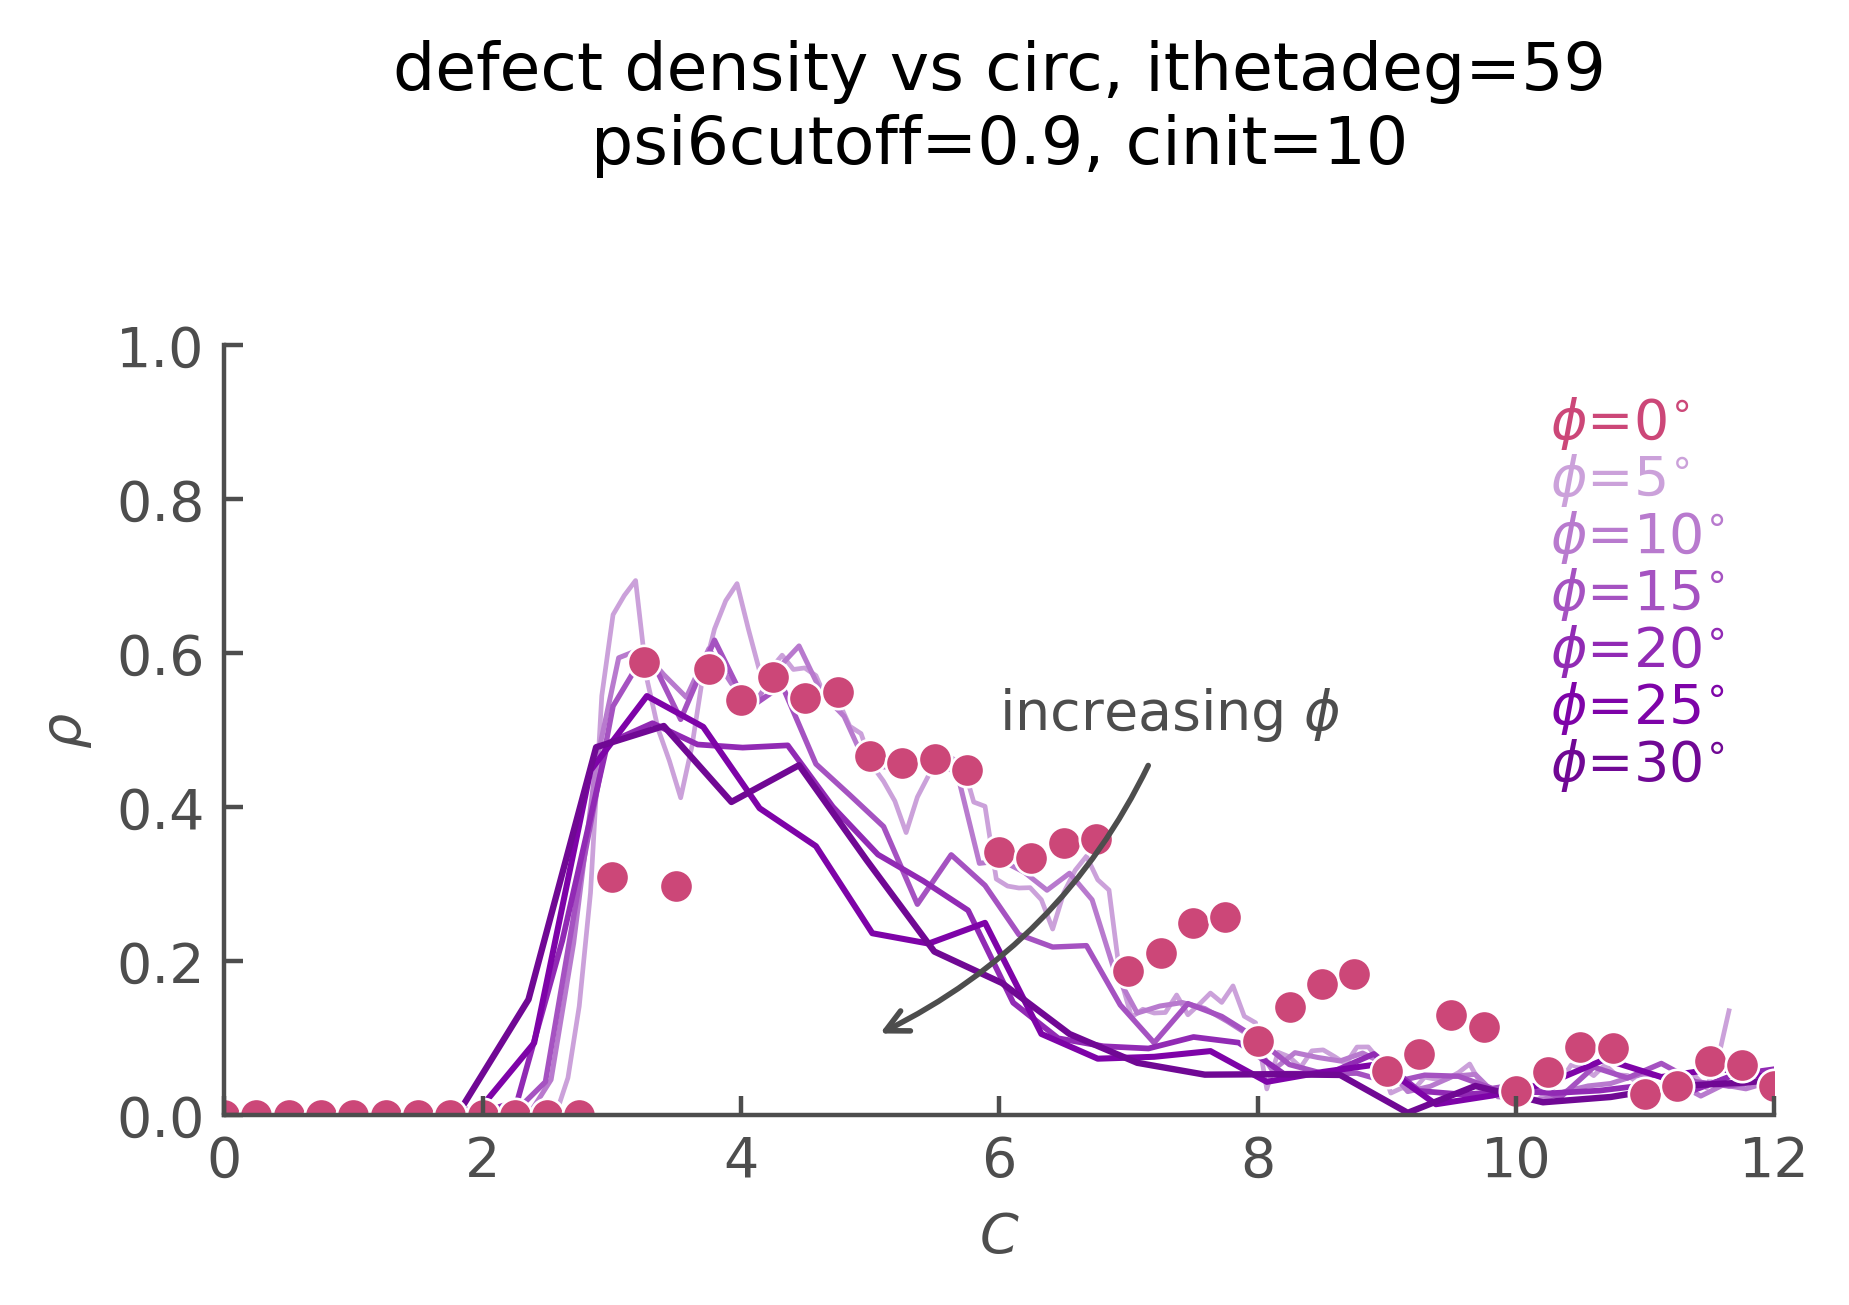

In [60]:
cone_cylinder_df=cone_cylinder_df.reset_index(drop=True)

axis_color='0.3'
n_cone=6 #5,10,15...30
n_cylinder=11 #2,3,4,...,12
# custom_palette=sns.color_palette("deep",n,as_cmap=True)
# cylinder_palette=sns.color_palette(sns.dark_palette(sns.color_palette("bright",as_cmap=True)[3],n,reverse=True)[2:3],1)
# cone_palette=sns.color_palette(sns.dark_palette(sns.color_palette("deep",as_cmap=True)[1],n,reverse=True)[1:n])
cylinder_palette=sns.color_palette(c_palette[:n_cylinder][6:7]) #select C=10
cone_palette=sns.color_palette(phi_palette[2:2+n_cone])

# sns.dark_palette(sns.color_palette("deep",as_cmap=True)[0],n,reverse=True)

psi6cutoff=0.9
ithetadeg=59
cinit=10
# palette=custom_palette
# coeff_df_filtered=coeff_df[(coeff_df['psi6cutoff']==psi6cutoff)&(coeff_df['ithetadeg']==ithetadeg)&(coeff_df['cinit']==cinit)] #best fit + cutoff data
cone_cylinder_df_filtered=cone_cylinder_df[(cone_cylinder_df['psi6cutoff']==psi6cutoff)&(cone_cylinder_df['ithetadeg']==ithetadeg)&(cone_cylinder_df['cinit']==cinit)] #orig data

fig=plt.figure(figsize=(5,2.5),dpi=400)
ax=fig.add_subplot(111)
# sns.lineplot(x=coeff_df_filtered['circ_filtered'], y=coeff_df_filtered['defect_density_fit'],hue=coeff_df_filtered['cthetadeg'],palette=palette,ax=ax) #line of best fit
# sns.scatterplot(x=coeff_df_filtered['circ_filtered'], y=coeff_df_filtered['defect_density'],hue=coeff_df_filtered['cthetadeg'],alpha=1,s=5,palette=palette,ax=ax,legend=False)
# sns.scatterplot(x=cone_cylinder_df_filtered['circ'], y=cone_cylinder_df_filtered['defect_density'],hue=cone_cylinder_df_filtered['cthetadeg'],alpha=0.5,palette=palette,s=5,ax=ax,legend=False)    
cone=cone_cylinder_df_filtered[cone_cylinder_df_filtered['cthetadeg']!=0]
cone=cone.reset_index()
cylinder=cone_cylinder_df_filtered[cone_cylinder_df_filtered['cthetadeg']==0]

line_sizes=list(np.linspace(0.85,1.15,n_cone))
sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],color=cylinder_palette[0],ax=ax,legend=False,zorder=1) 
sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],palette=cone_palette,ax=ax,legend=True,zorder=0,size=cone['cthetadeg'],sizes=line_sizes)    

###############
#modify legend#
###############
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
new_labels_list+=[r'$\phi$='+str(0)+r'$^{\circ}$'] #cylinder label
handles+=[handles[0]] #add an additional entry for cylinder
for label in labels:
    new_labels_list+=[r'$\phi$='+str(int(float(label)))+r'$^{\circ}$'] #cone labels
new_labels = new_labels_list
# ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
ax.legend(handles,new_labels,labelcolor=cylinder_palette+cone_palette,loc='upper right',frameon=False,handlelength=0,handletextpad=0,labelspacing=0)

########
xlimL,xlimR=0,12
ax.set_xlim(xlimL,xlimR)
ax.set_ylim(0,1)

title='defect density'+' vs '+'circ'+', ithetadeg='+str(ithetadeg)+'\npsi6cutoff='+str(0.9)+', cinit='+str(cinit)+'\n'
ax.set_title(title+'\n')
ax.set_ylabel(r'$\rho$');
ax.set_xlabel(r'$C$');        
# ax.annotate('cylinders',(7.8,0.92),color=cylinder_palette[0])
# ax.annotate('cones',(8.48,0.84),color=cone_palette[0])
ax.annotate('increasing '+r'$\phi$',
            xy=(5, 0.1), xycoords='data',
            xytext=(6, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",color=axis_color),color=axis_color,
            )

ax.tick_params(direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)
# #############
# ##add inset
# #############
# left, bottom, width, height = [0.19, 0.7, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],hue=cylinder['cthetadeg'],s=3,legend=False,ax=ax2,palette=cylinder_palette,zorder=1)
# sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],linewidth=0.75,legend=False,ax=ax2,palette=cone_palette,zorder=0)
# ax2.set_yscale('log')
# ax2.set_ylabel(r"$log(\rho)$")
# ax2.set_xlabel(r'$C$')
# ax2.set_xlim(xlimL,xlimR)
# ax2.set_xticks([])
# ax2.set_yticks([])

# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax2.xaxis.label.set_color(axis_color)
# ax2.yaxis.label.set_color(axis_color)
# ax2.set_facecolor('0.95')

plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinderplot_c.svg',bbox_inches = "tight")
plt.show()


/var/folders/3s/n0tzw1x111s4b5xm_qm0ytnc0000gn/T/ipykernel_42246/364314523.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,1.05)


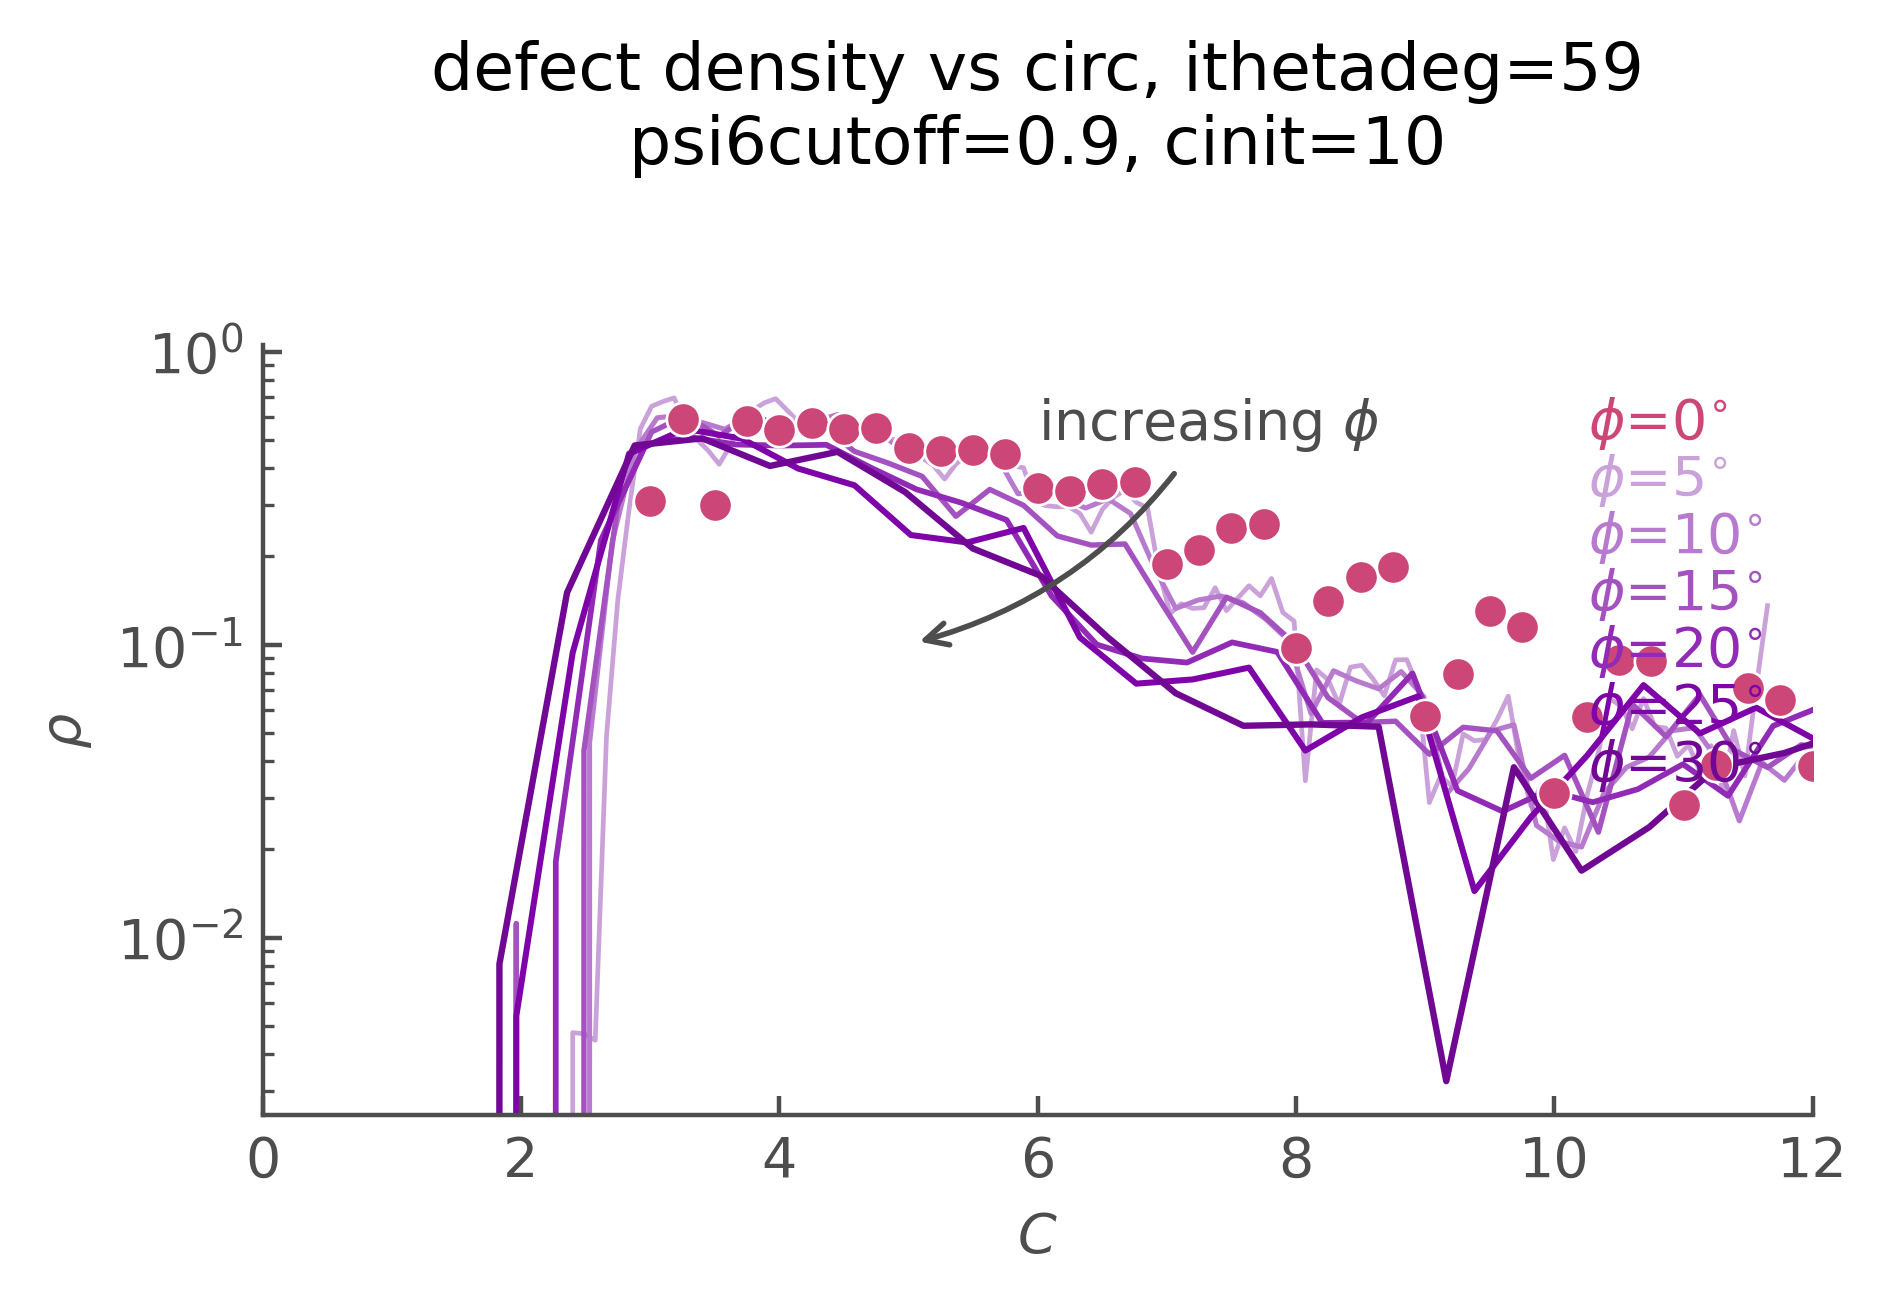

In [61]:
fig=plt.figure(figsize=(5,2.5),dpi=400)
ax=fig.add_subplot(111)

#############
##add inset
#############
# left, bottom, width, height = [0.19, 0.7, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
line_sizes=list(np.linspace(0.85,1.15,n_cone))
sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],color=cylinder_palette[0],ax=ax,legend=False,zorder=1) 
sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],palette=cone_palette,ax=ax,legend=True,zorder=0,size=cone['cthetadeg'],sizes=line_sizes)    

# sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],hue=cylinder['cthetadeg'],s=3,legend=False,ax=ax,palette=cylinder_palette,zorder=1)
# sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],linewidth=0.75,legend=False,ax=ax,palette=cone_palette,zorder=0)
ax.set_yscale('log')
ax.set_ylabel(r"$log(\rho)$")
ax.set_xlabel(r'$C$')

########
xlimL,xlimR=0,12
ax.set_xlim(xlimL,xlimR)
ax.set_ylim(0,1.05)

title='defect density'+' vs '+'circ'+', ithetadeg='+str(ithetadeg)+'\npsi6cutoff='+str(0.9)+', cinit='+str(cinit)+'\n'
ax.set_title(title+'\n')
ax.set_ylabel(r'$\rho$');
ax.set_xlabel(r'$C$');        
# ax.annotate('cylinders',(7.8,0.92),color=cylinder_palette[0])
# ax.annotate('cones',(8.48,0.84),color=cone_palette[0])
ax.annotate('increasing '+r'$\phi$',
            xy=(5, 0.1), xycoords='data',
            xytext=(6, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",color=axis_color),color=axis_color,
            )

ax.tick_params(which="both",direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)
###############
#modify legend#
###############
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
new_labels_list+=[r'$\phi$='+str(0)+r'$^{\circ}$'] #cylinder label
handles+=[handles[0]] #add an additional entry for cylinder
for label in labels:
    new_labels_list+=[r'$\phi$='+str(int(float(label)))+r'$^{\circ}$'] #cone labels
new_labels = new_labels_list
# ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
ax.legend(handles,new_labels,labelcolor=cylinder_palette+cone_palette,loc='upper right',frameon=False,handlelength=0,handletextpad=0,labelspacing=0)


plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinderplot_log_c.svg',bbox_inches = "tight")
plt.show()

/var/folders/3s/n0tzw1x111s4b5xm_qm0ytnc0000gn/T/ipykernel_42246/4231600687.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,1.05)


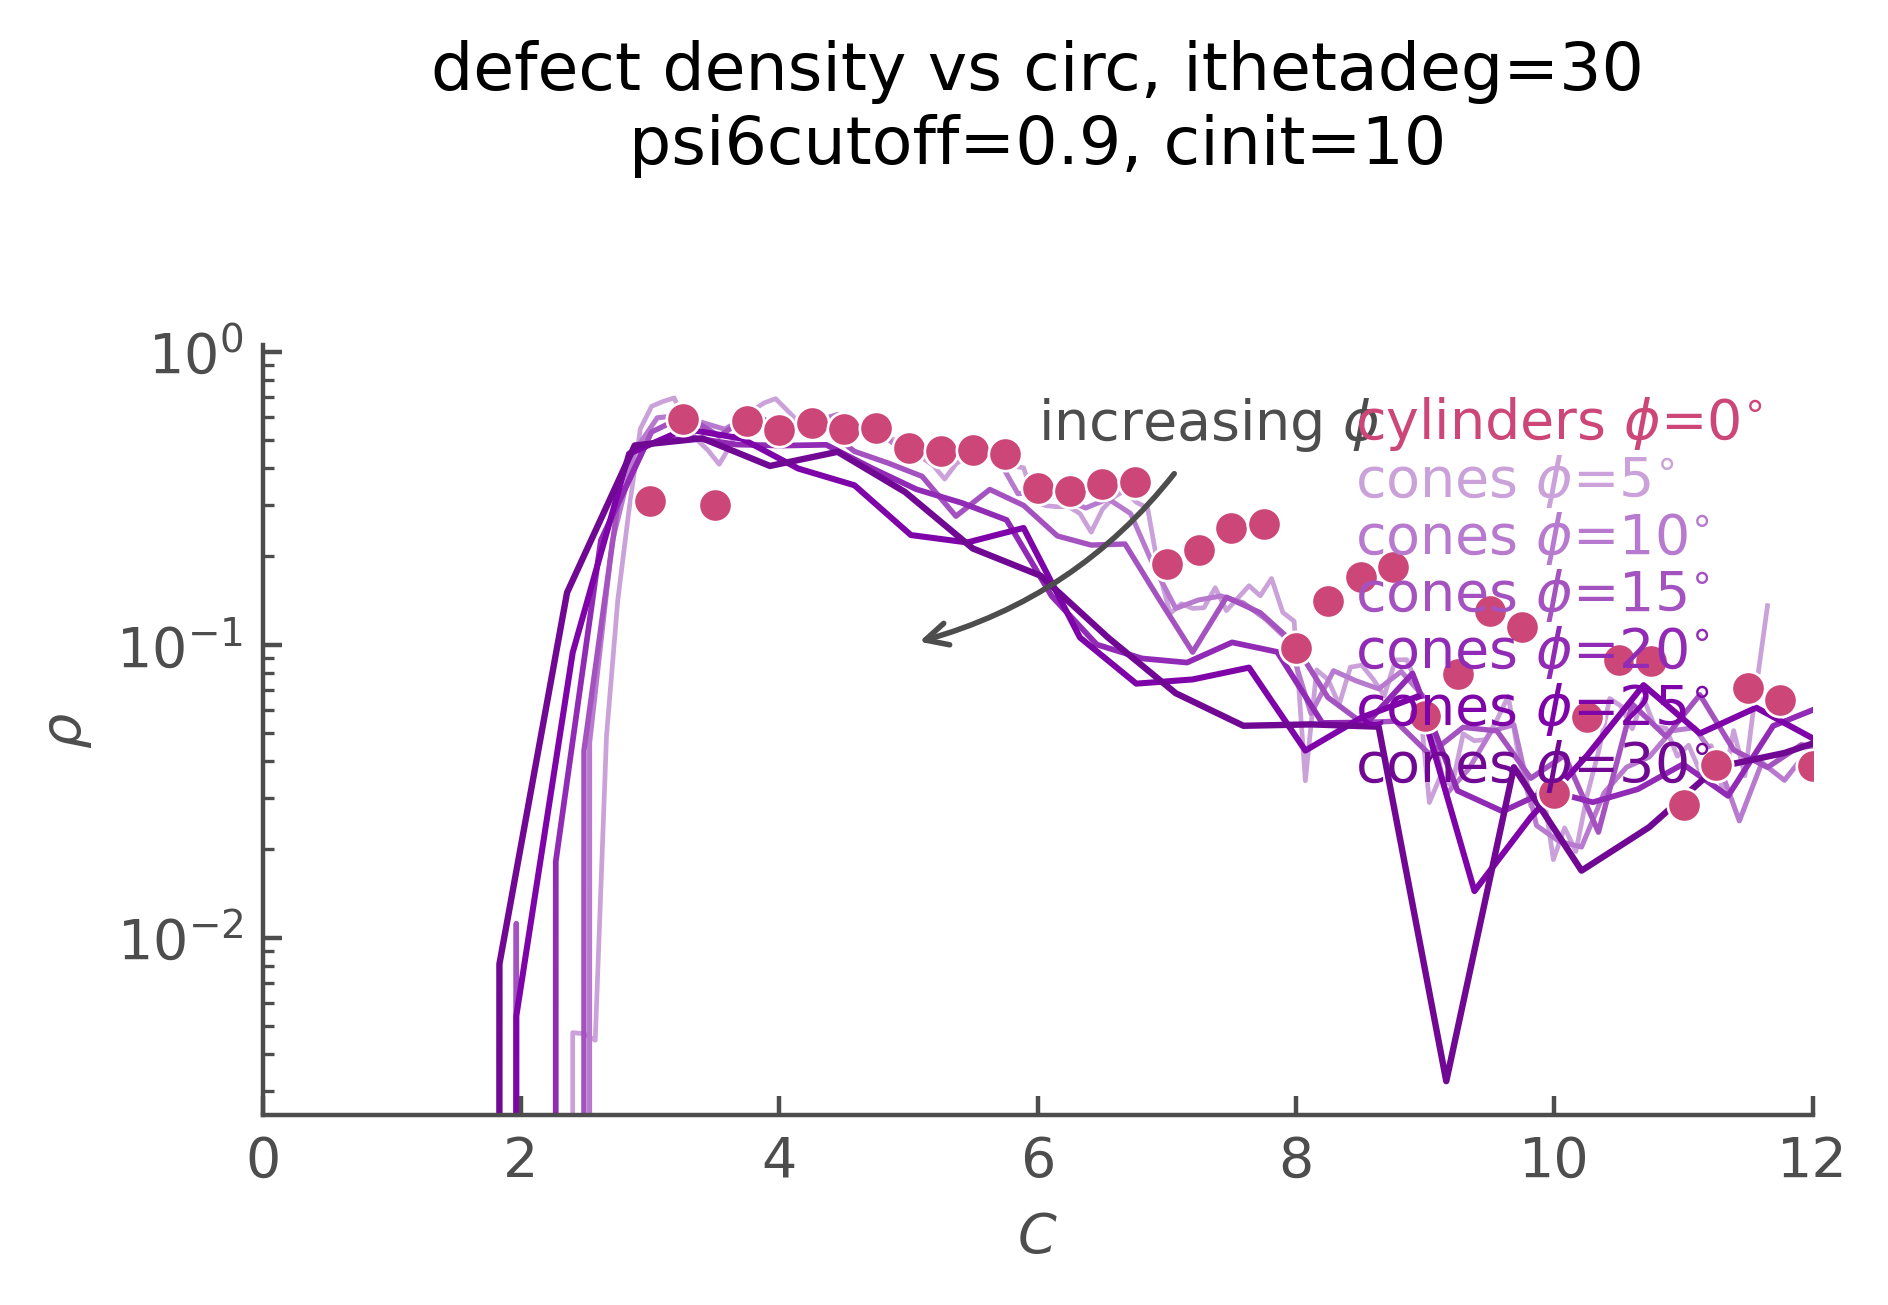

In [85]:
fig=plt.figure(figsize=(5,2.5),dpi=400)
ax=fig.add_subplot(111)

#############
##add inset
#############
# left, bottom, width, height = [0.19, 0.7, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
line_sizes=list(np.linspace(0.85,1.15,n_cone))
sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],color=cylinder_palette[0],ax=ax,legend=False,zorder=1) 
sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],palette=cone_palette,ax=ax,legend=True,zorder=0,size=cone['cthetadeg'],sizes=line_sizes)    

# sns.scatterplot(x=cylinder['circ'], y=cylinder['defect_density'],hue=cylinder['cthetadeg'],s=3,legend=False,ax=ax,palette=cylinder_palette,zorder=1)
# sns.lineplot(x=cone['circ'], y=cone['defect_density'],hue=cone['cthetadeg'],linewidth=0.75,legend=False,ax=ax,palette=cone_palette,zorder=0)
ax.set_yscale('log')
ax.set_ylabel(r"$log(\rho)$")
ax.set_xlabel(r'$C$')

########
xlimL,xlimR=0,12
ax.set_xlim(xlimL,xlimR)
ax.set_ylim(0,1.05)

title='defect density'+' vs '+'circ'+', ithetadeg='+str(ithetadeg)+'\npsi6cutoff='+str(0.9)+', cinit='+str(cinit)+'\n'
ax.set_title(title+'\n')
ax.set_ylabel(r'$\rho$');
ax.set_xlabel(r'$C$');        
# ax.annotate('cylinders',(7.8,0.92),color=cylinder_palette[0])
# ax.annotate('cones',(8.48,0.84),color=cone_palette[0])
ax.annotate('increasing '+r'$\phi$',
            xy=(5, 0.1), xycoords='data',
            xytext=(6, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",color=axis_color),color=axis_color,
            )

ax.tick_params(which="both",direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)
###############
#modify legend#
###############
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
new_labels_list+=['cylinders '+r'$\phi$='+str(0)+r'$^{\circ}$'] #cylinder label
handles+=[handles[0]] #add an additional entry for cylinder
for label in labels:
    new_labels_list+=['cones '+r'$\phi$='+str(int(float(label)))+r'$^{\circ}$'] #cone labels
new_labels = new_labels_list
# ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
ax.legend(handles,new_labels,labelcolor=cylinder_palette+cone_palette,loc='upper right',frameon=False,handlelength=0,handletextpad=0,labelspacing=0)


plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinderplot_c_legend.svg',bbox_inches = "tight")
plt.show()

/var/folders/3s/n0tzw1x111s4b5xm_qm0ytnc0000gn/T/ipykernel_42246/27100543.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,1.05)


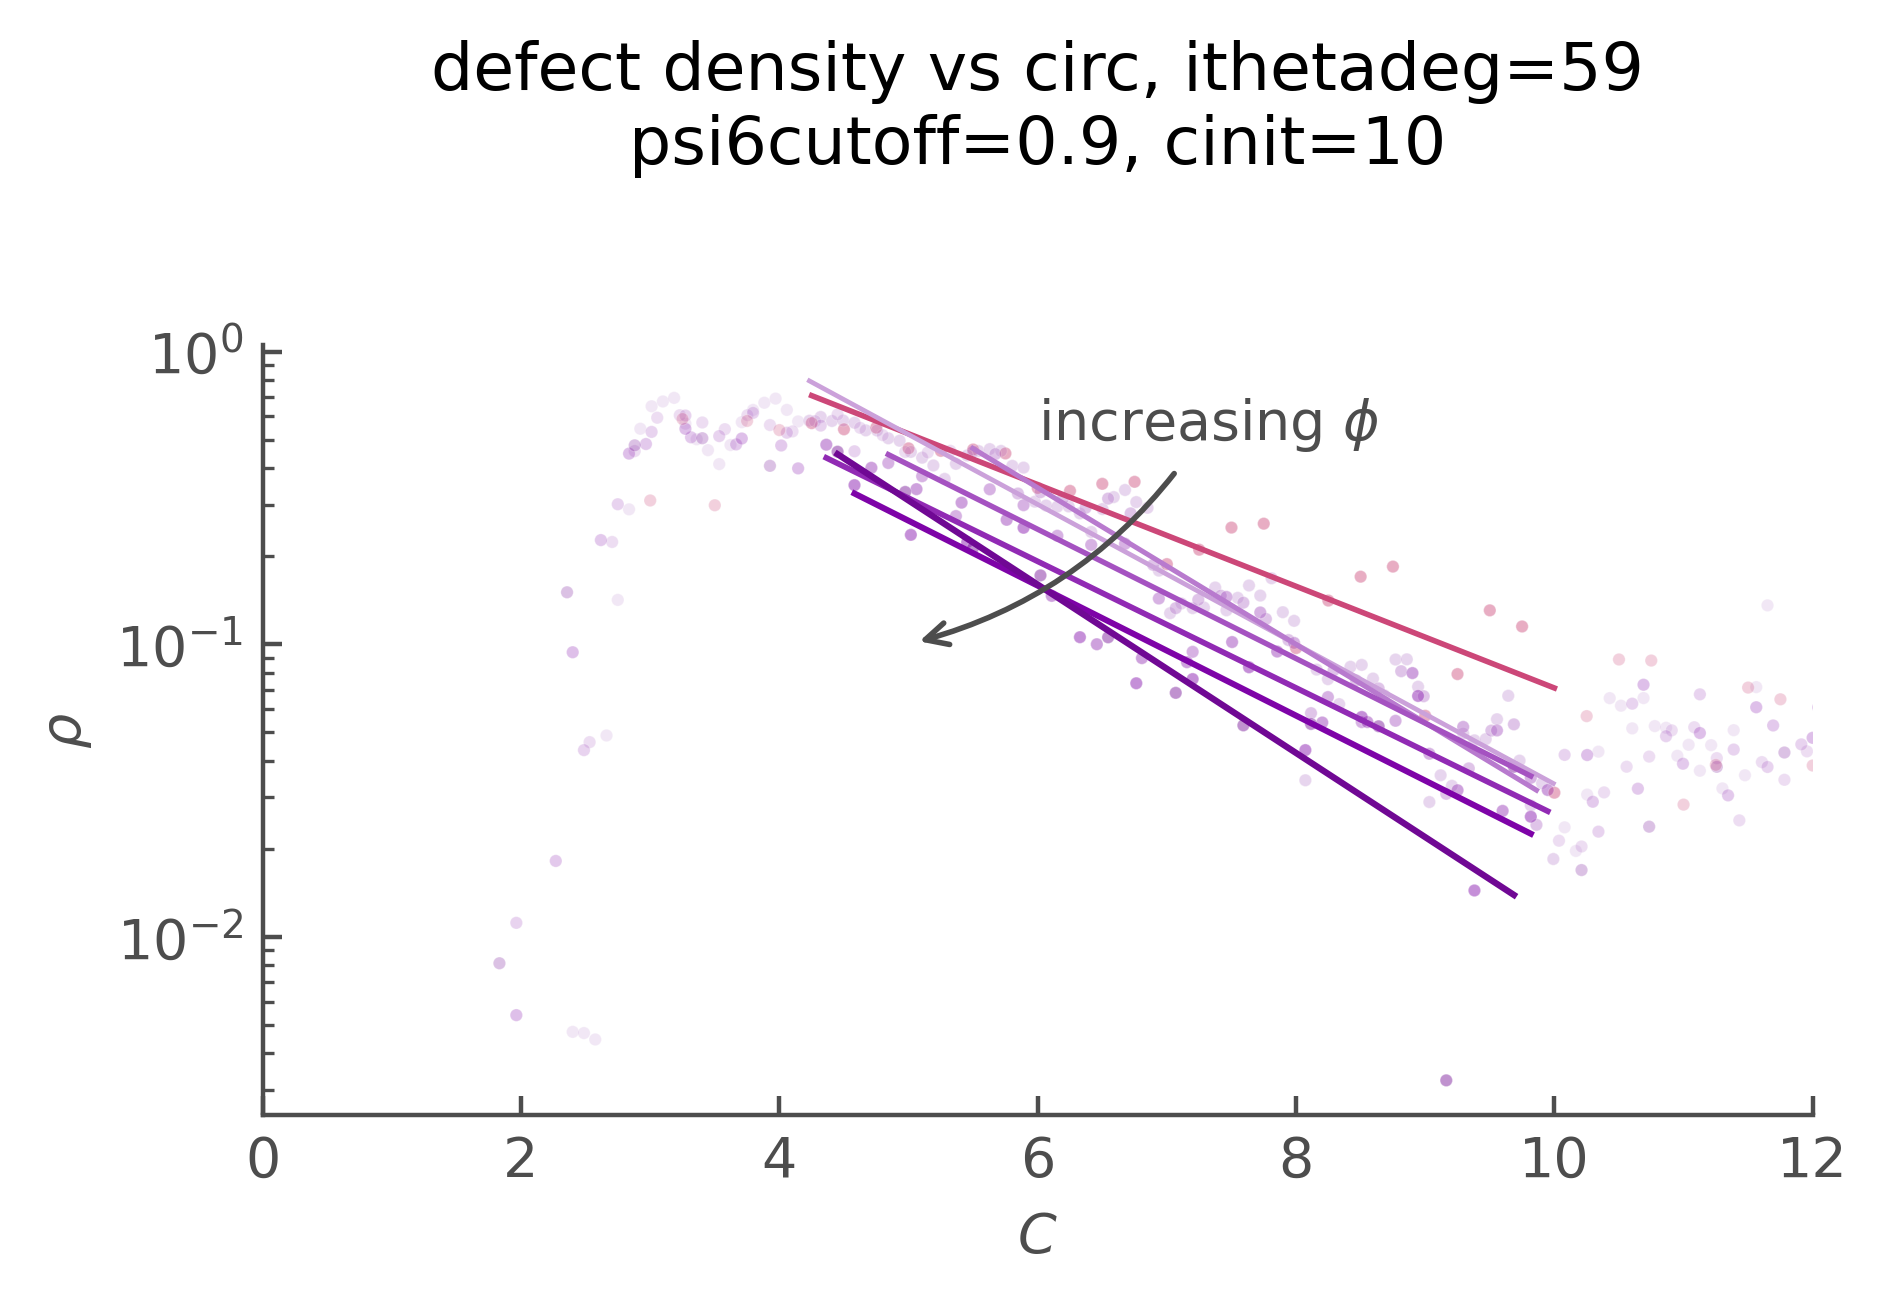

In [63]:

# psi6cutoff=0.9
# ithetadeg=40
# cinit=10
# palette='deep'
palette=cylinder_palette+cone_palette
coeff_df_filtered=coeff_df[(coeff_df['psi6cutoff']==psi6cutoff)&(coeff_df['ithetadeg']==ithetadeg)&(coeff_df['cinit']==cinit)].reset_index()
cone_cylinder_df_filtered=cone_cylinder_df[(cone_cylinder_df['psi6cutoff']==psi6cutoff)&(cone_cylinder_df['ithetadeg']==ithetadeg)&(cone_cylinder_df['cinit']==cinit)]

fig=plt.figure(figsize=(5,2.5),dpi=400)
ax=fig.add_subplot(111)
line_sizes=[1]+list(np.linspace(0.85,1.15,n_cone)) #first line is for cylinder. rest is for cones
sns.lineplot(x=coeff_df_filtered['circ_filtered'], y=coeff_df_filtered['defect_density_fit'],hue=coeff_df_filtered['cthetadeg'],palette=palette,ax=ax,legend=False,size=coeff_df_filtered['cthetadeg'],sizes=line_sizes) #line of best fit
sns.scatterplot(x=coeff_df_filtered['circ_filtered'], y=coeff_df_filtered['defect_density'],hue=coeff_df_filtered['cthetadeg'],alpha=0.25,s=5,palette=palette,ax=ax,legend=False)
sns.scatterplot(x=cone_cylinder_df_filtered['circ'], y=cone_cylinder_df_filtered['defect_density'],hue=cone_cylinder_df_filtered['cthetadeg'],alpha=0.25,palette=palette,s=5,ax=ax,legend=False)    
###############
#modify legend#
###############
ax.set_yscale('log')
ax.set_ylabel(r"$log(\rho)$")
ax.set_xlabel(r'$C$')

########
xlimL,xlimR=0,12
ax.set_xlim(xlimL,xlimR)
ax.set_ylim(0,1.05)


handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
for label in labels:
    new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
new_labels = new_labels_list
# ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
# ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0,handletextpad=0,labelspacing=0)
ax.annotate('increasing '+r'$\phi$',
            xy=(5, 0.1), xycoords='data',
            xytext=(6, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",color=axis_color),color=axis_color,
            )

ax.tick_params(which="both",direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

title='defect density'+' vs '+'circ'+', ithetadeg='+str(ithetadeg)+'\npsi6cutoff='+str(0.9)+', cinit='+str(cinit)+'\n'
ax.set_title(title+'\n')
ax.set_ylabel(r'$\rho$');
ax.set_xlabel(r'$C$');        

plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinderplot_logcoeff_c.svg',bbox_inches = "tight")
plt.show()

In [64]:
# #############
# ####FIG 8####
# #############

# # fig8_data_list=[]
# # counter=0
# # start=time.time()

# # cthetadeg=0
# # ithetadeg_list=[0,10,20,30]
# # trials_list=np.unique(run_dir_df['trial'])

# # cinit_options=np.unique(run_dir_df['cinit'])
# # cinit_list=cinit_options
# # # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]
# # for cinit in cinit_list:
# #     counter+=1
# #     print(counter,'/',len(cinit_list),end='...')
    
# #     for trial in trials_list:
# #         for ithetadeg in ithetadeg_list:
# #             run_dir_df_filtered=run_dir_df[
# #                 (run_dir_df['cthetadeg']==cthetadeg)
# #                 &(run_dir_df['cinit']==cinit)
# #                 &(run_dir_df['ithetadeg']==ithetadeg)
# #                 &(run_dir_df['trial']==trial)]

# #             run_dir=run_dir_df_filtered['run_dir'][0]
# #             params_dict=get_params_dict(run_dir)
# #             data,adj=load_data(run_dir)
# #             data=find_images(data,params_dict)
# #             data=get_theta6_psi6(data,adj,run_dir)

# #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig8_data=pd.DataFrame([fig8_dict])
# #             fig8_data_list+=[fig8_data]    

# #     #         fig=plt.figure(figsize=(5,5),dpi=400)
# #     #         ax=fig.add_subplot(111)
# #     #         plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')

# #     #         Nactual=len(data)
# #     #         info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     #         plt.show()
# #         #     plt.savefig(output_dir+'/fig4a'+info_tag+'.png')
# # fig8_data=pd.concat(fig8_data_list)
# # print('done!',round((time.time()-start)/60,2),'min to process')

# # #######
# # # export fig8_data
# # ########
# # print('exporting fig8_data.pkl...')
# # start=time.time()
# # fig8_data.to_pickle(output_dir+'/fig8_data.pkl')
# # print('done!',round((time.time()-start)/60,2),'min export')

# #######
# # import fig8_data
# ########
# print('opening fig8_data.pkl...')
# start=time.time()
# with open(output_dir+'/fig8_data.pkl', "rb") as fh:
#     fig8_data=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

In [65]:
# fig=plt.figure(figsize=(5,2.5),dpi=400)
# ax=fig.add_subplot(111)

# fig8_data_filtered=fig8_data[(fig8_data['ithetadeg']>=0)&(fig8_data['ithetadeg']<=30)]

# sns.lineplot(x=fig8_data_filtered['cinit'],y=fig8_data_filtered['avg_psi6'],hue=fig8_data_filtered['ithetadeg'],palette='deep',ax=ax,ci=95);
# # sns.scatterplot(x=fig8_data['cinit'],y=fig8_data['avg_psi6'],hue=fig8_data['ithetadeg'],palette='deep',s=1,alpha=1,ax=ax);
# ax.set_xlabel('C')
# ax.set_ylabel(r'$\psi_6$')
# ax.set_xlim(5,12)
# ax.set_ylim(0.75,1)
# ax.set_title('avg_psi6 vs cinit for cthetadeg=0\n')
# ax.legend(loc='lower right',frameon=False)

# info_tag='_cthetadeg-'+str(min(np.unique(fig8_data['cthetadeg'])))+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# plt.savefig(output_dir+'/fig8a'+info_tag+'.png')

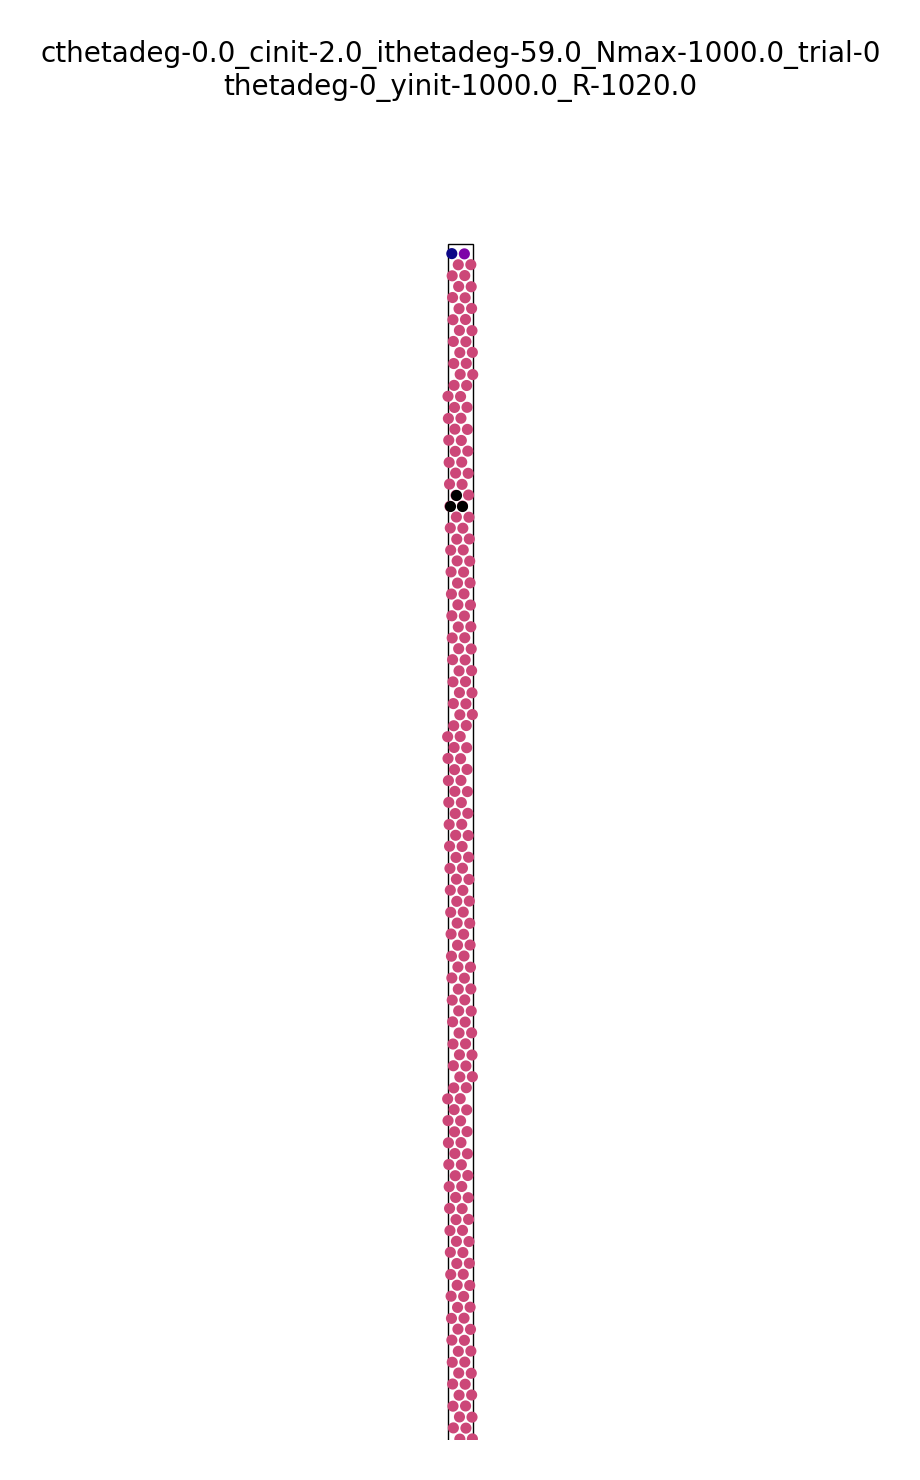

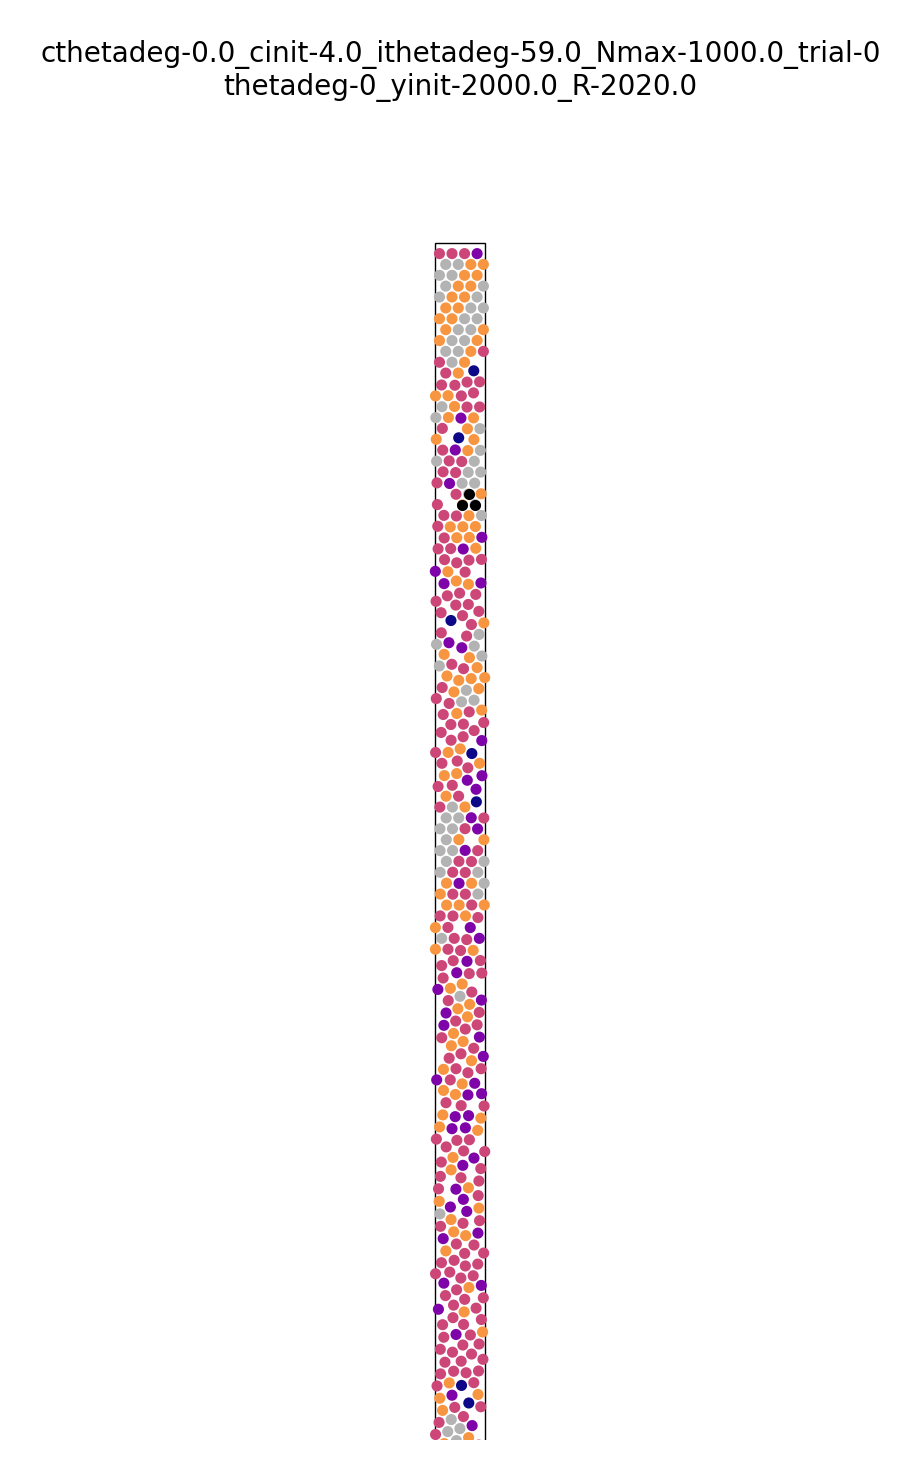

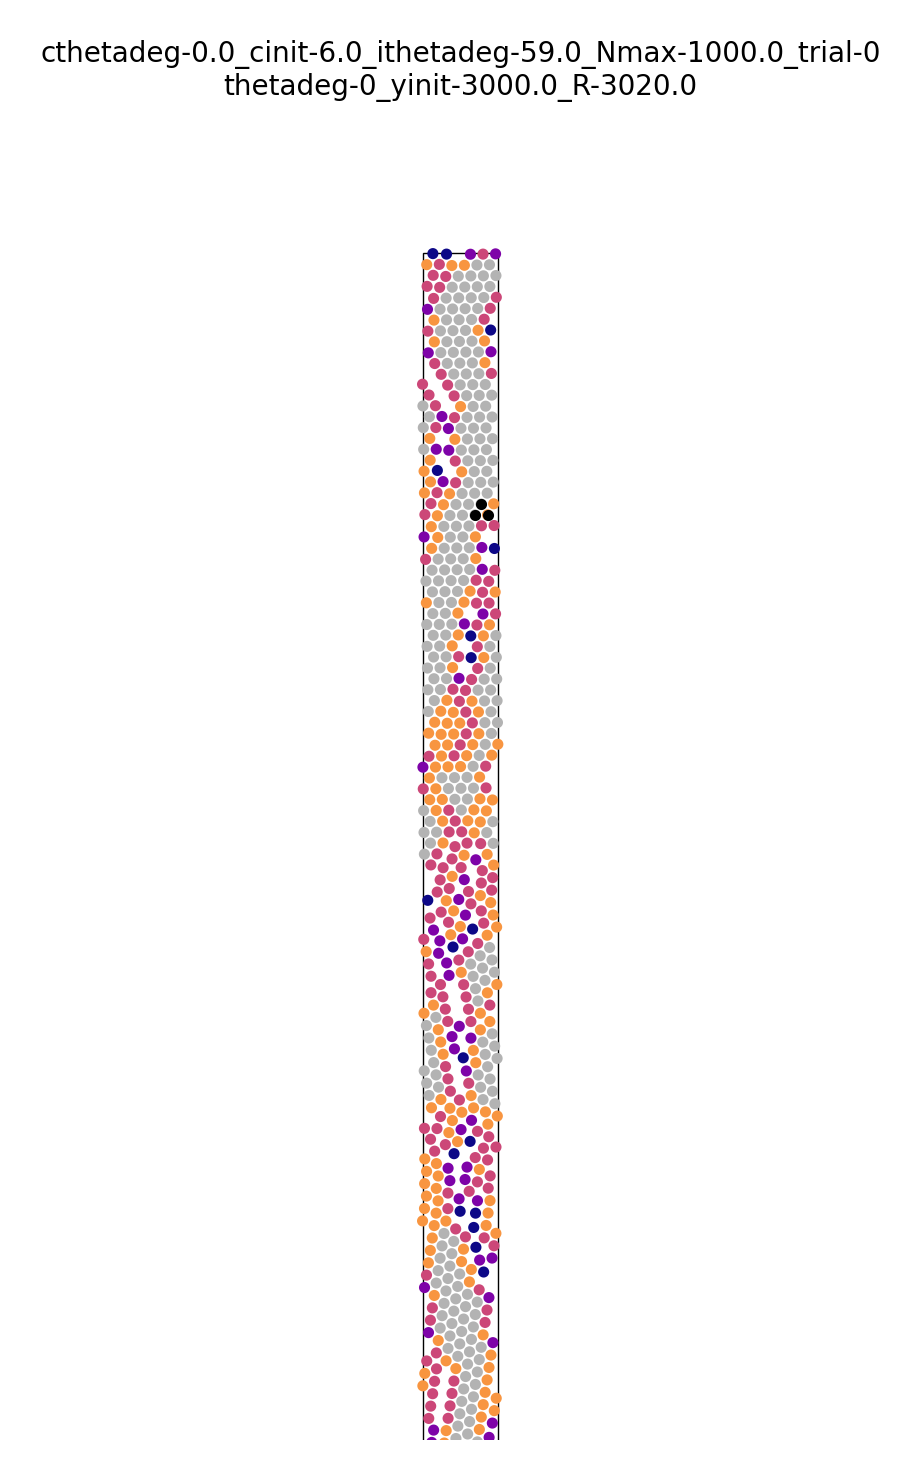

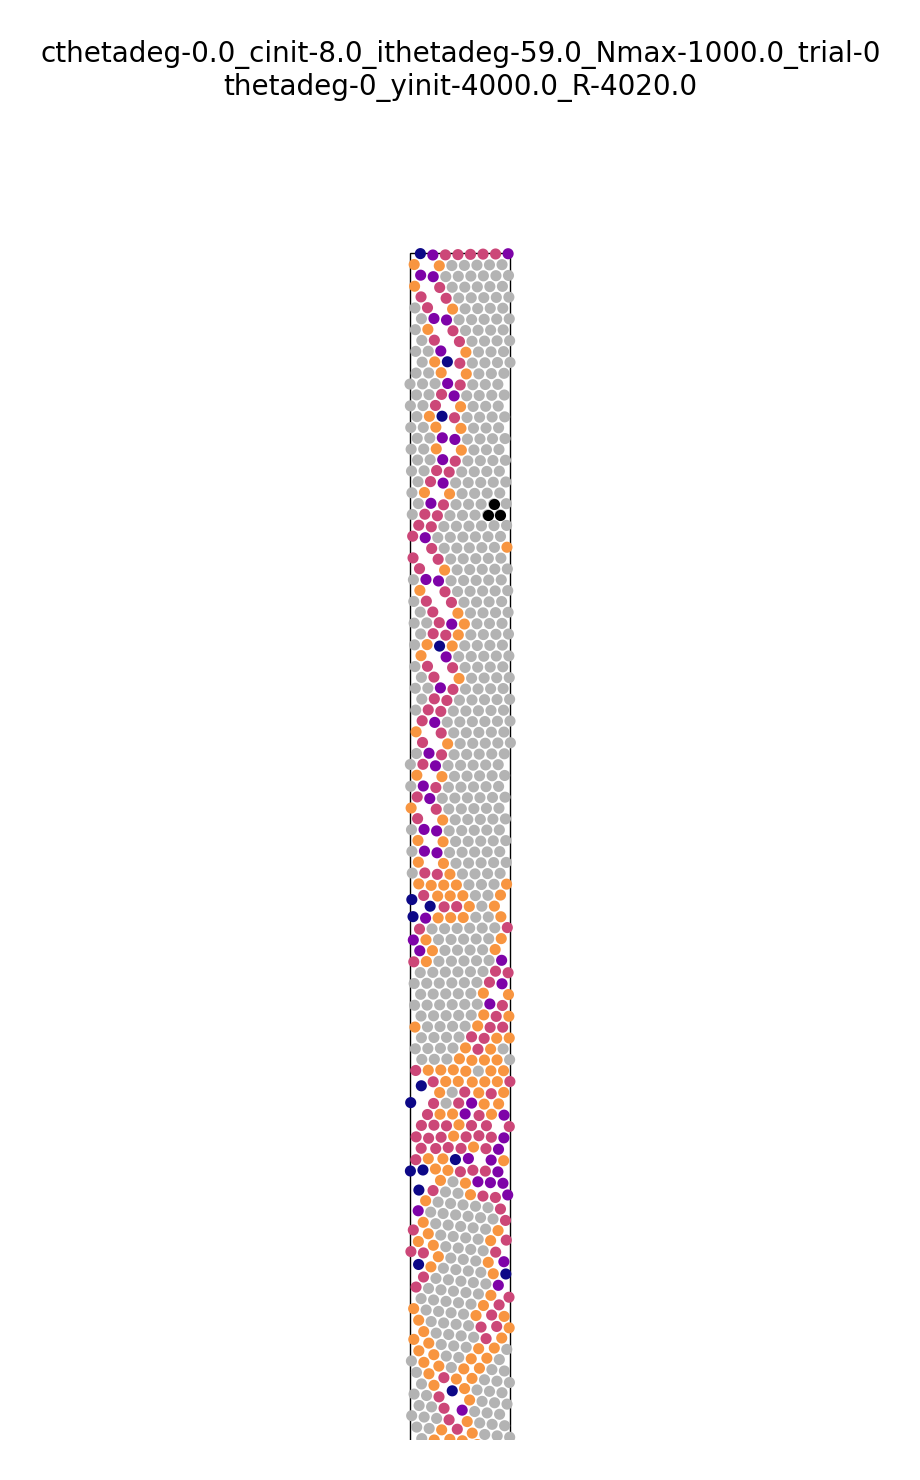

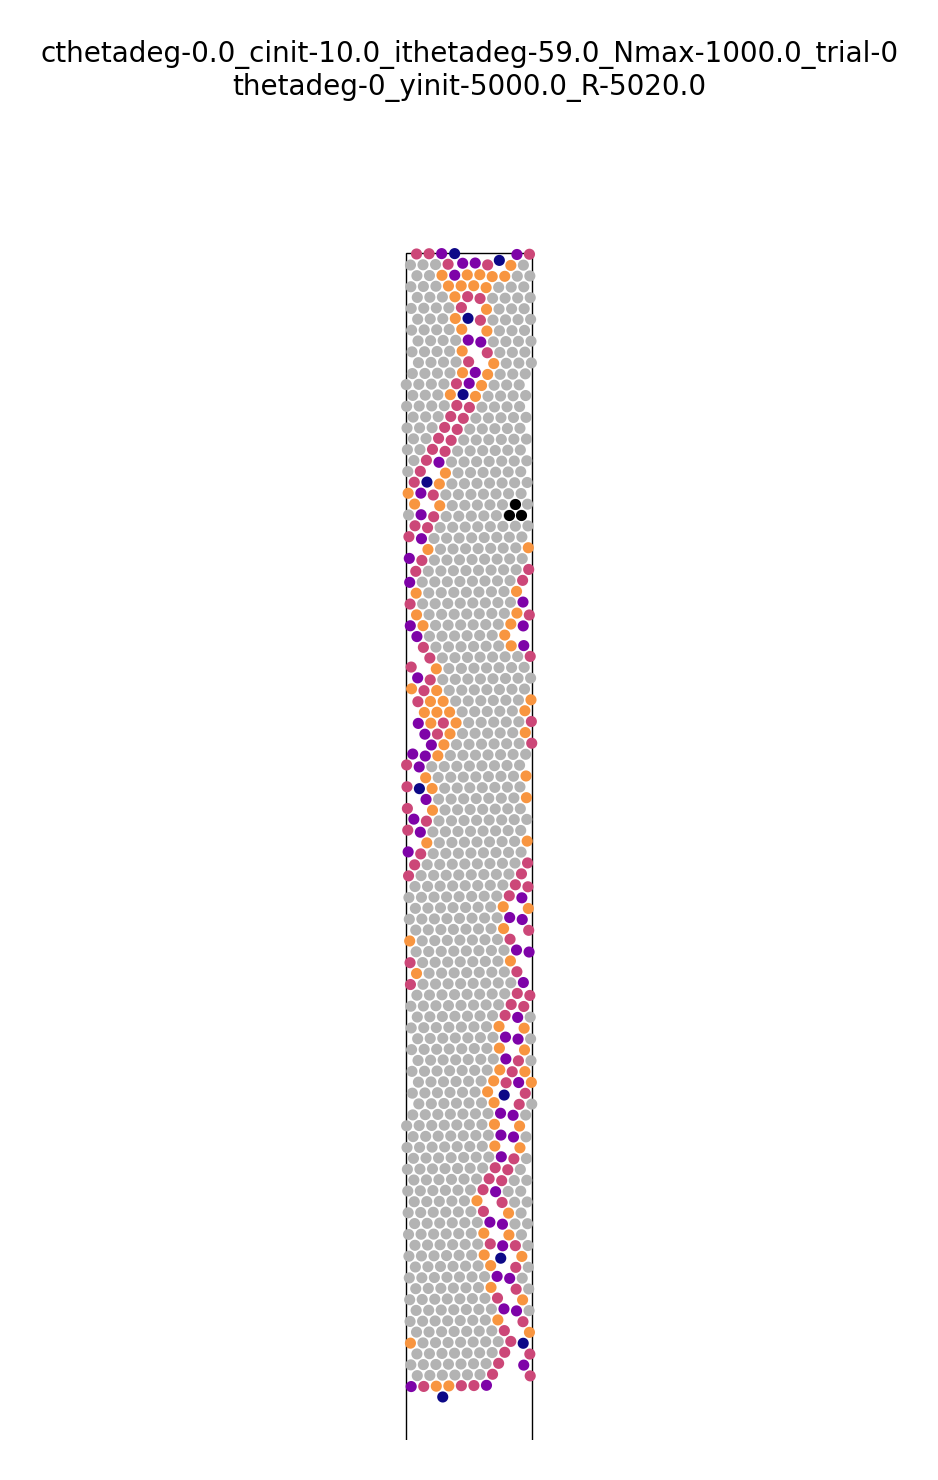

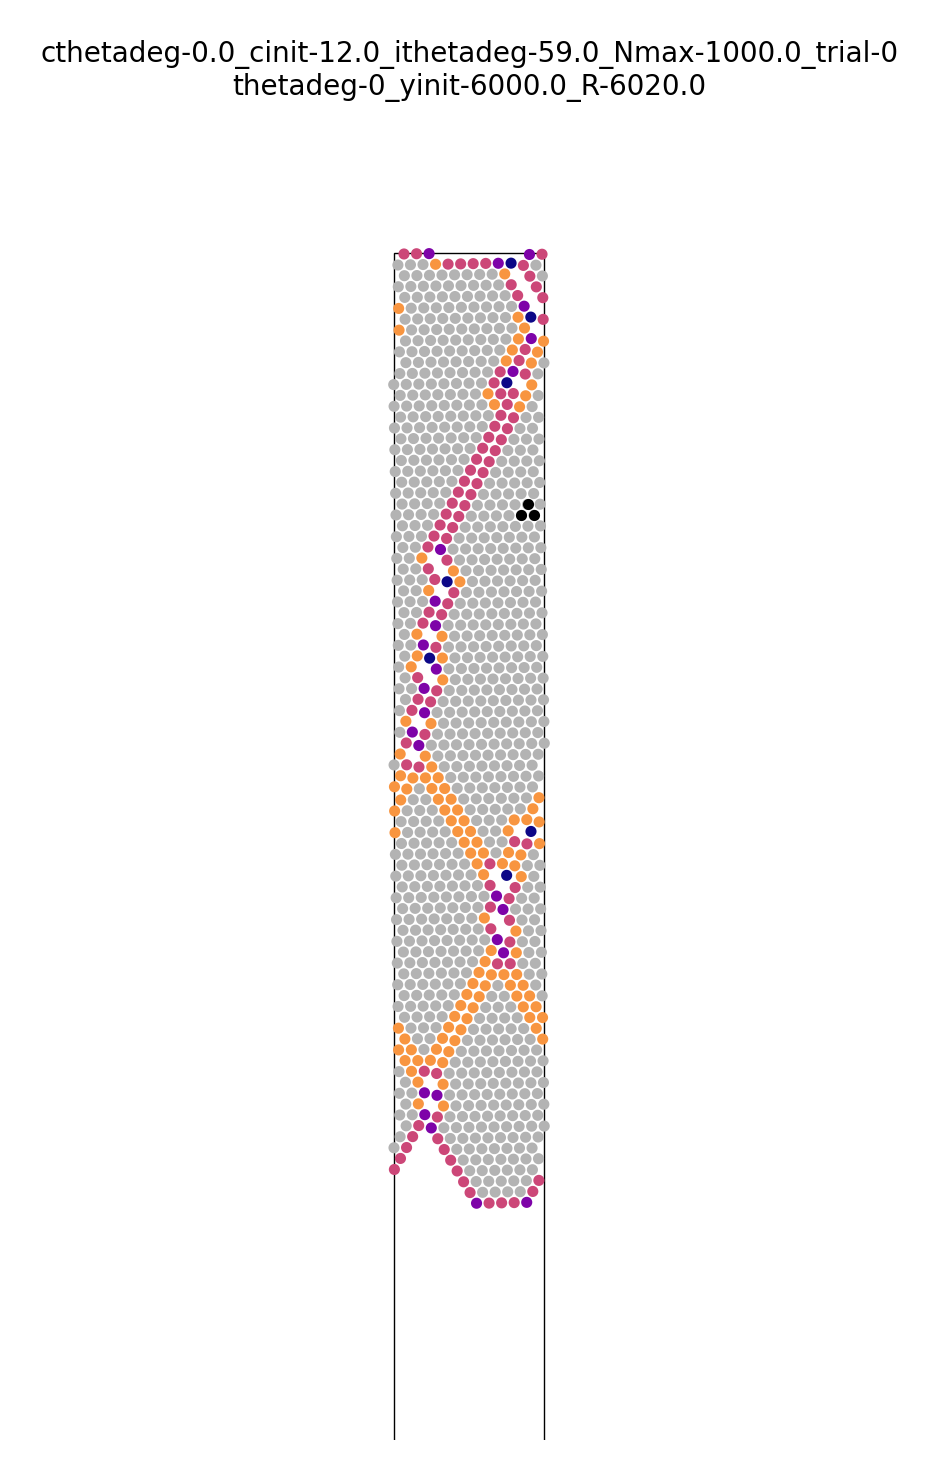

In [66]:
os.chdir(input_dir_c)
cthetadeg=0
# cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0] #5qsrt3
ithetadeg=59
trial=0

cinit_list=[2,4,6,8,10,12]
# cinit_list=[12,10,8,6,4,2]
# cinit_list=[2,3,4,5,6,7,8,9,10,11,12]

ref_ylim_range=reference_range+50+10 #this is the standard range used for all of my plots so far
new_ylim_range=reference_range+5

ylim_range_ratio=new_ylim_range/ref_ylim_range

for cinit in cinit_list:
    run_dir_df_filtered=run_dir_df_c[
        (run_dir_df_c['cthetadeg']==cthetadeg)
        &(run_dir_df_c['cinit']==cinit)
        &(run_dir_df_c['ithetadeg']==ithetadeg)
        &(run_dir_df_c['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
    data=find_images(data,params_dict)
    data=get_theta6_psi6(data,adj,run_dir)

    fig=plt.figure(figsize=(6.5,6.5*ylim_range_ratio),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
    ####
    #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
    ylim_left=min(data['y'])-10
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.set_ylim(ylim_left,ylim_left+new_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
    ####
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    #     plt.show()
#     plt.savefig(output_dir+'/fig8b_cylinder_'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinder_cinit'+str(cinit)+'_c.svg',bbox_inches = "tight")
    ############
#     plot_seed(data,params_dict)
    ############    
    plt.show()

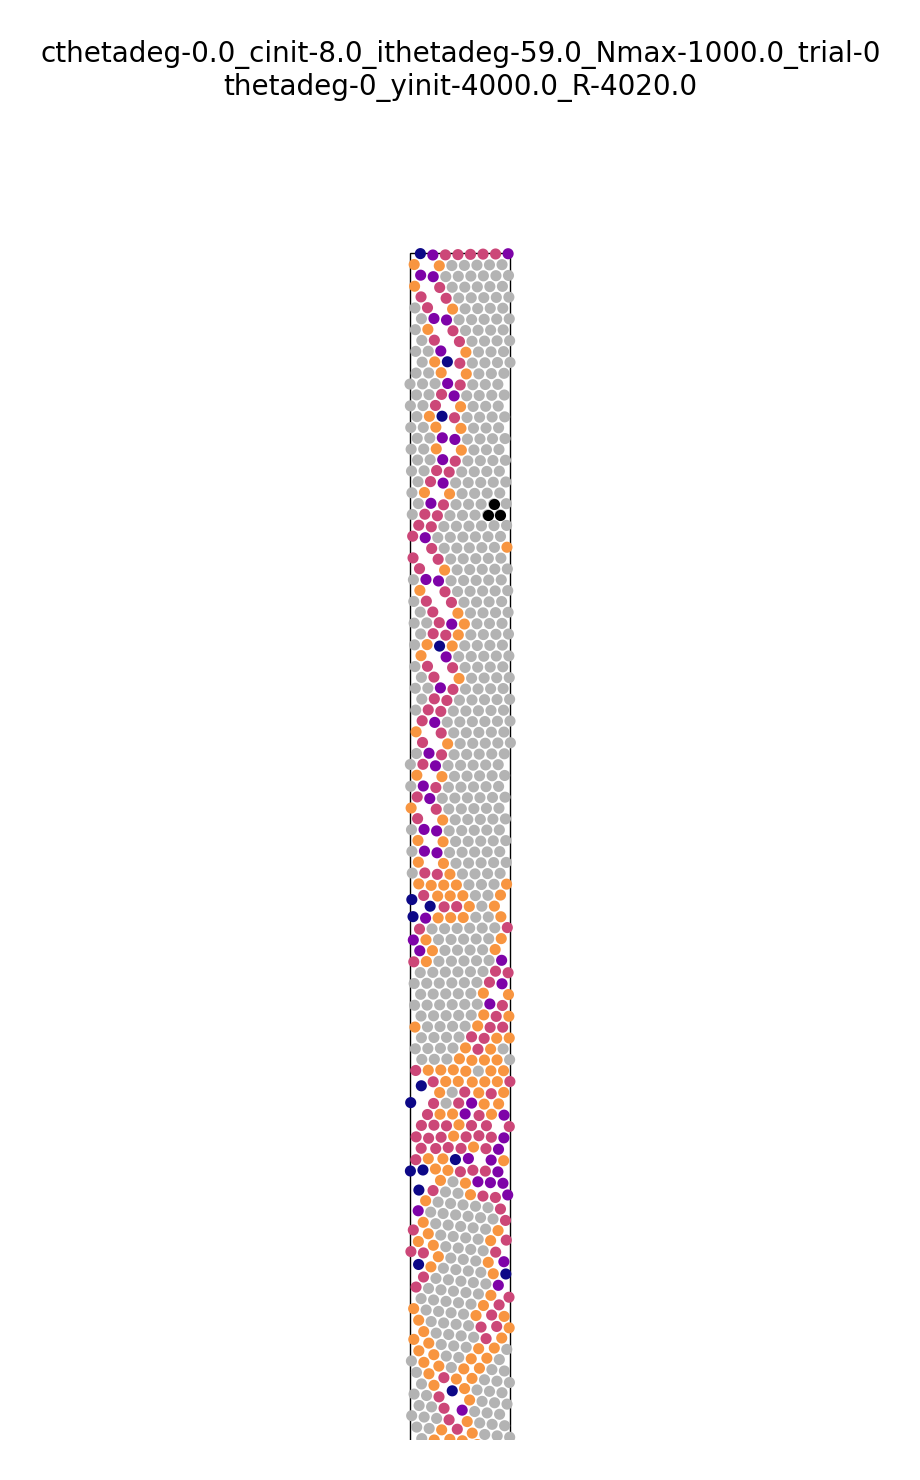

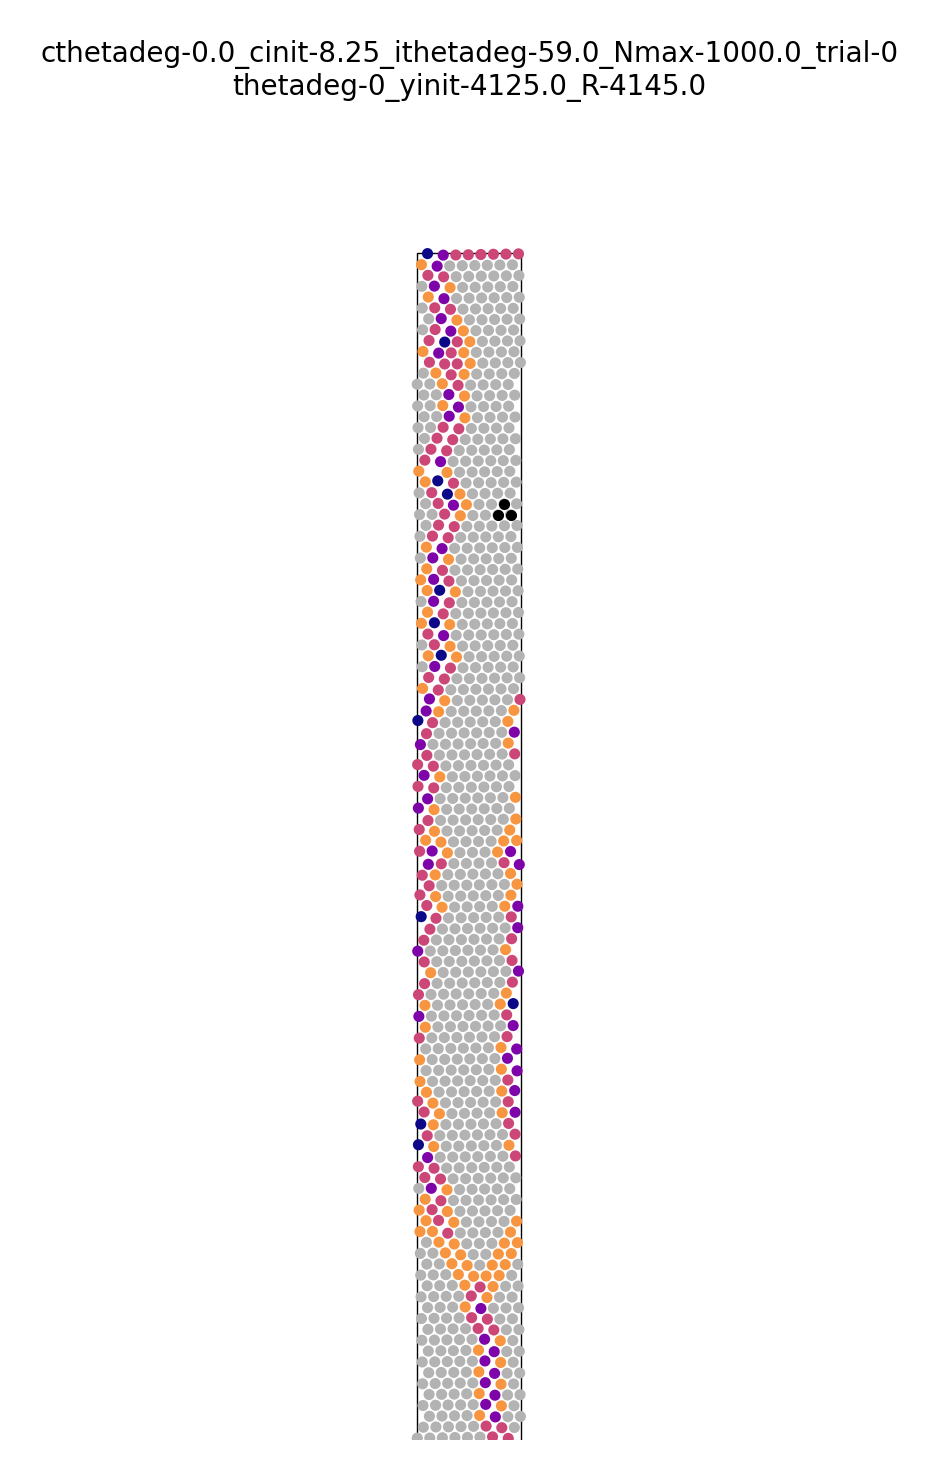

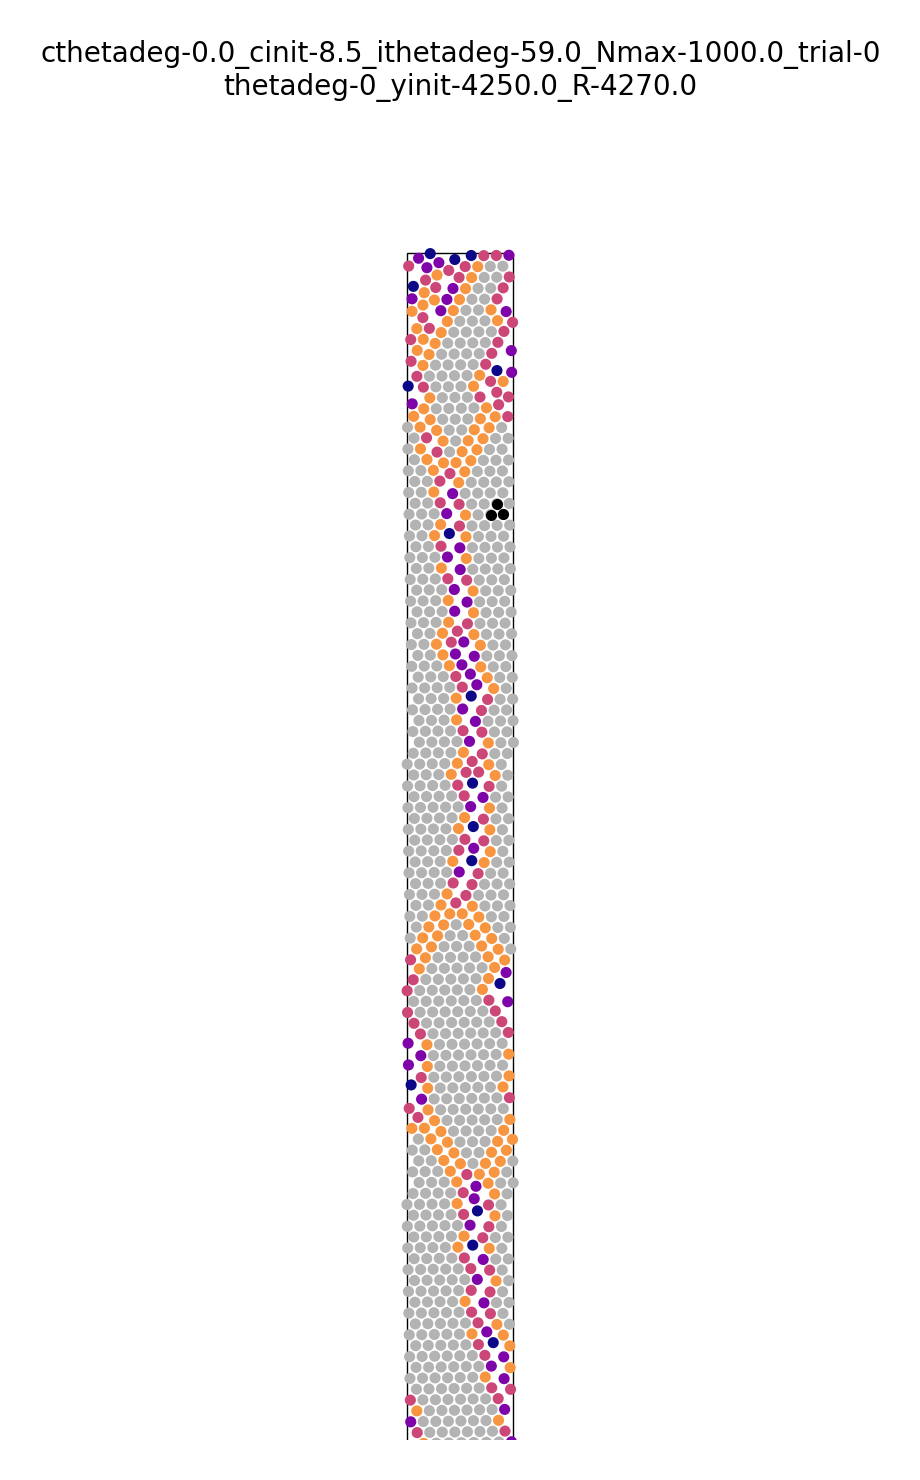

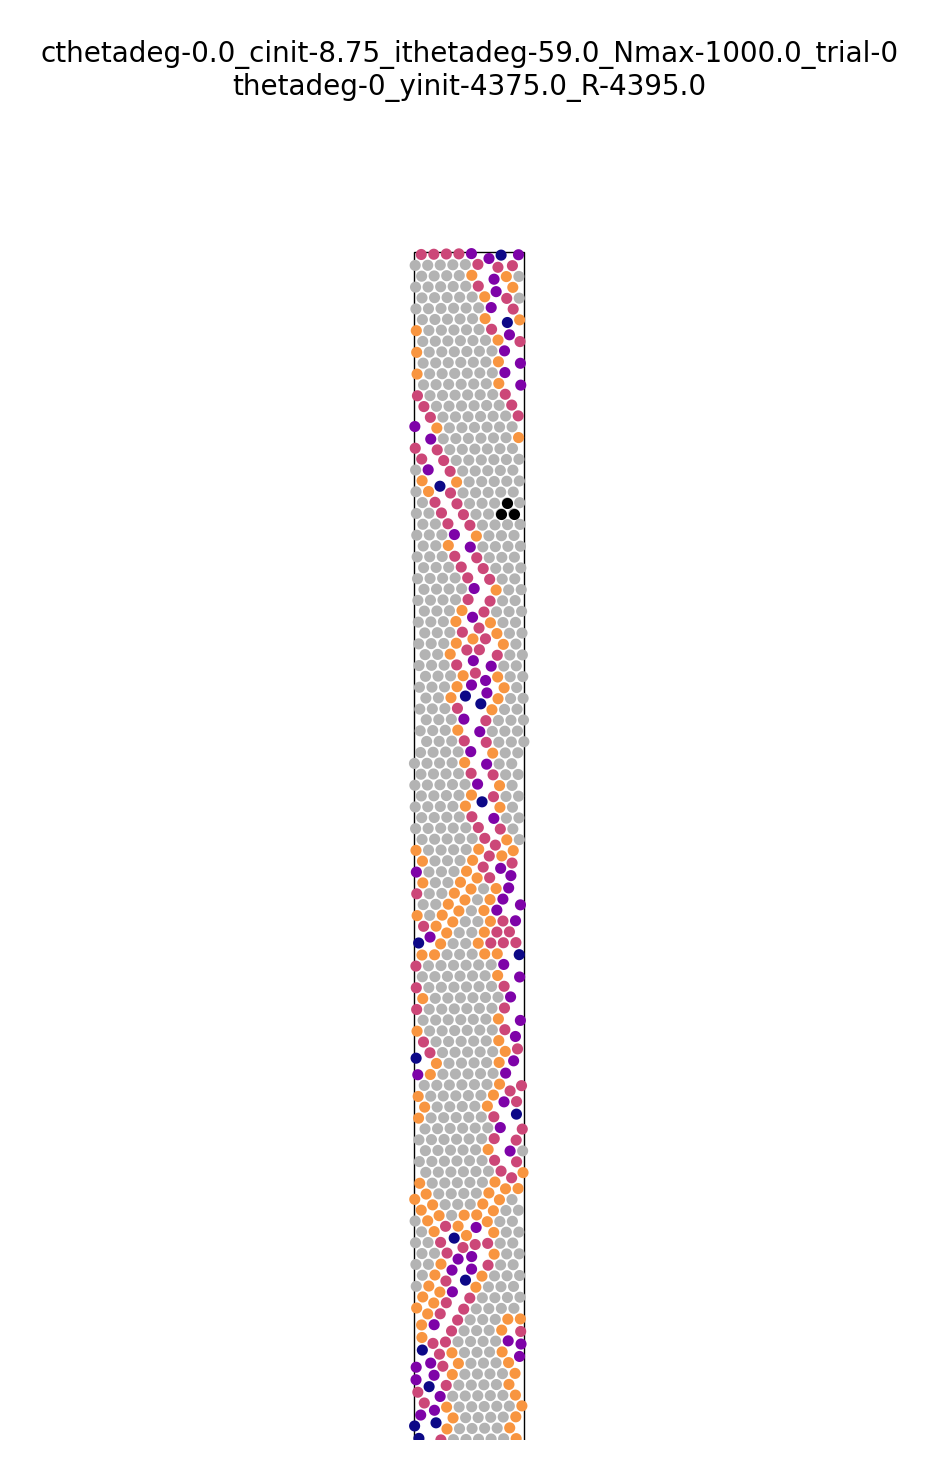

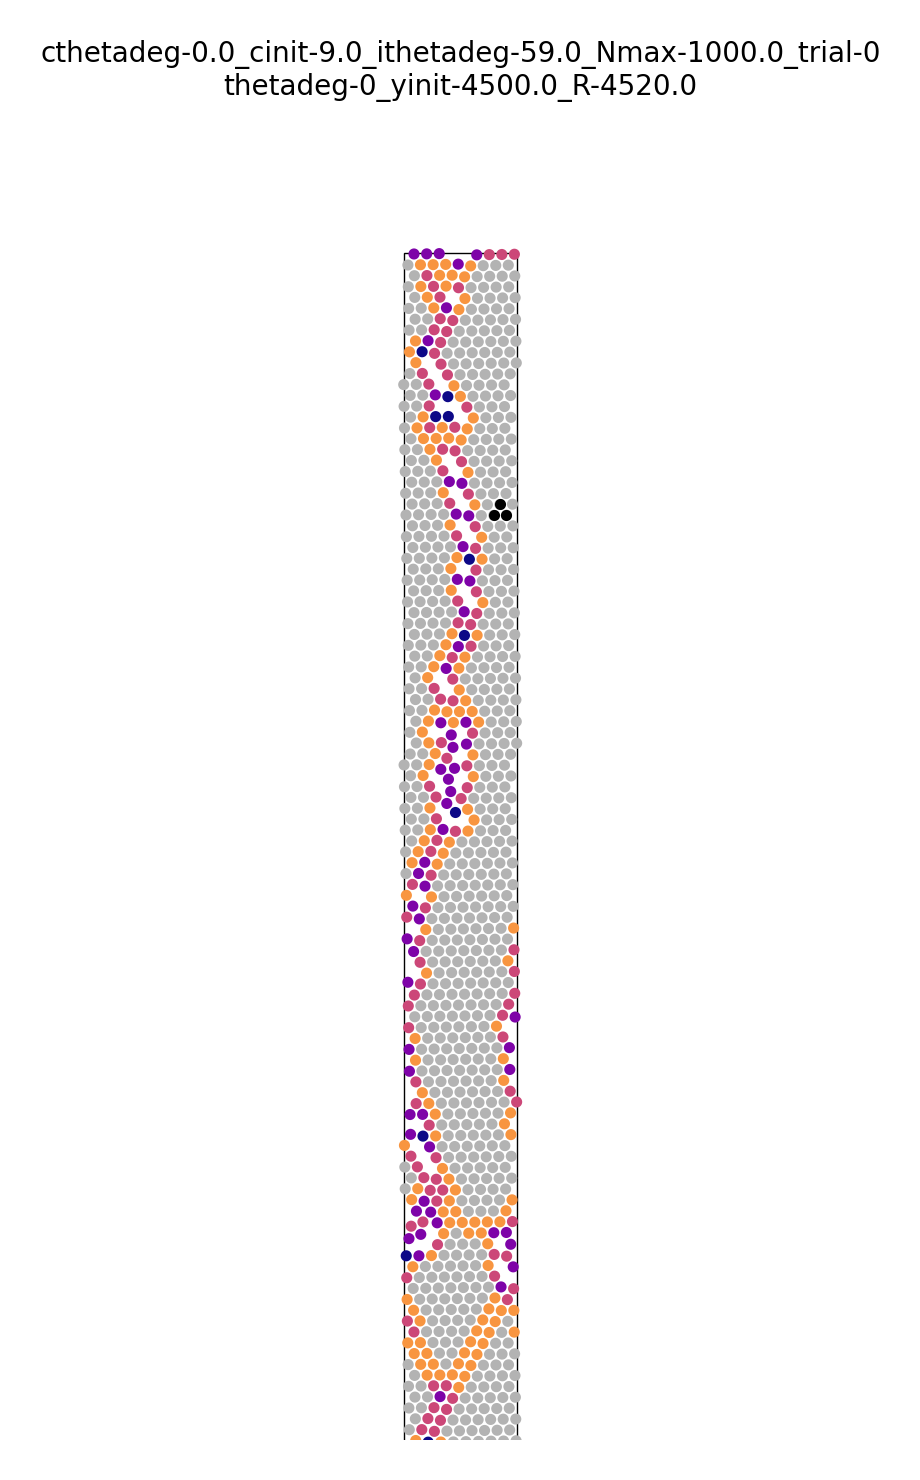

In [89]:
os.chdir(input_dir_c)
cthetadeg=0
# cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0] #5qsrt3
ithetadeg=59
trial=0

cinit_list=[8,8.25,8.5,8.75,9]
# cinit_list=[12,10,8,6,4,2]
# cinit_list=[2,3,4,5,6,7,8,9,10,11,12]

ref_ylim_range=reference_range+50+10 #this is the standard range used for all of my plots so far
new_ylim_range=reference_range+5

ylim_range_ratio=new_ylim_range/ref_ylim_range

for cinit in cinit_list:
    run_dir_df_filtered=run_dir_df_c[
        (run_dir_df_c['cthetadeg']==cthetadeg)
        &(run_dir_df_c['cinit']==cinit)
        &(run_dir_df_c['ithetadeg']==ithetadeg)
        &(run_dir_df_c['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
    data=find_images(data,params_dict)
    data=get_theta6_psi6(data,adj,run_dir)

    fig=plt.figure(figsize=(6.5,6.5*ylim_range_ratio),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
    ####
    #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
    ylim_left=min(data['y'])-10
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.set_ylim(ylim_left,ylim_left+new_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
    ####
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    #     plt.show()
#     plt.savefig(output_dir+'/fig8b_cylinder_'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinder_cinit'+str(cinit)+'_c.svg',bbox_inches = "tight")
    ############
#     plot_seed(data,params_dict)
    ############    
    plt.show()

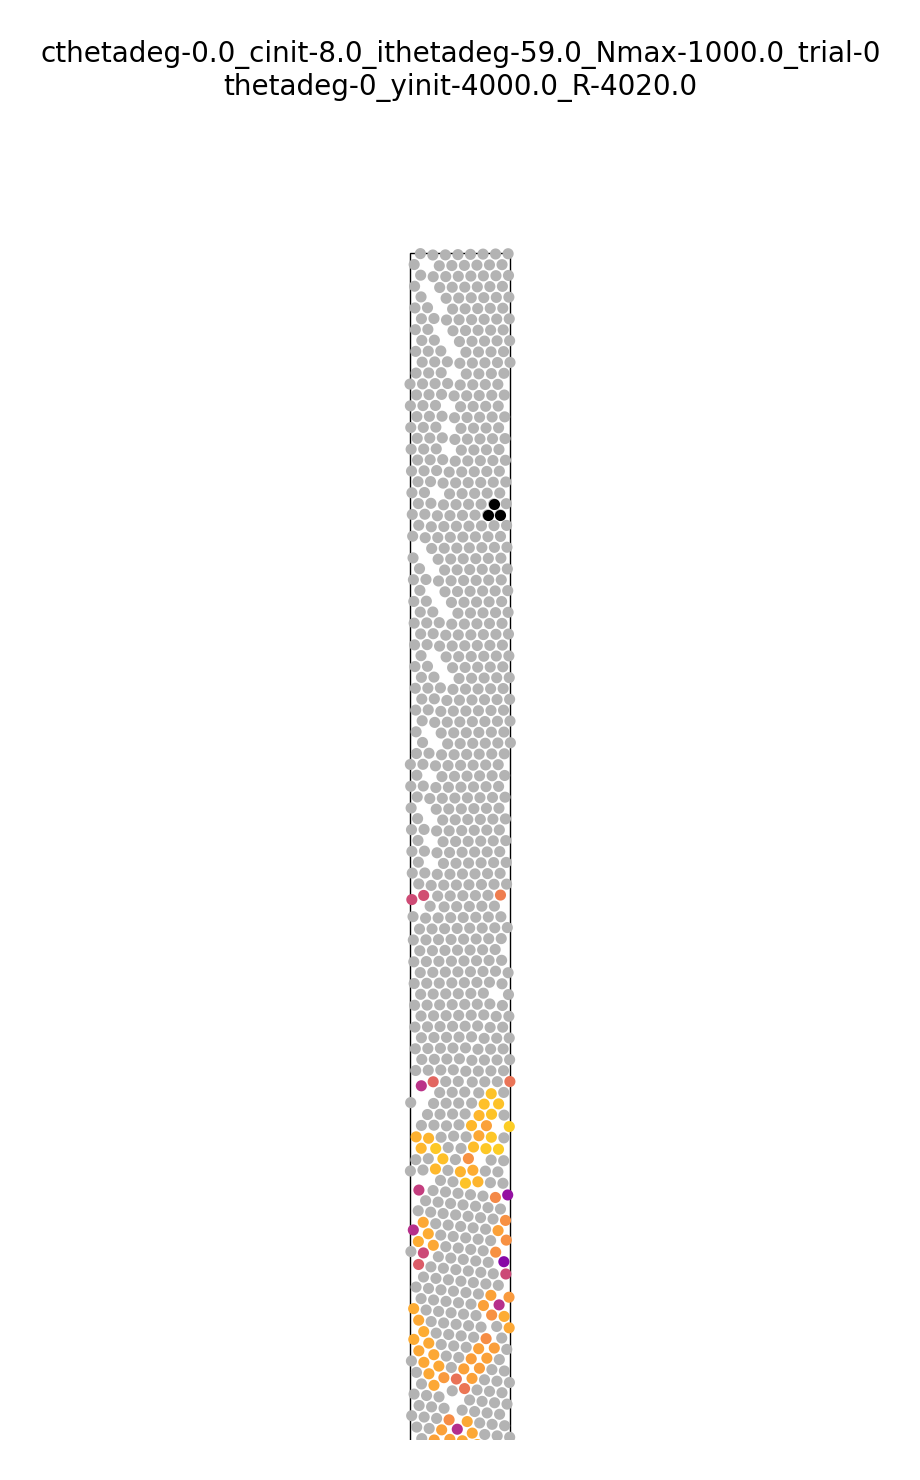

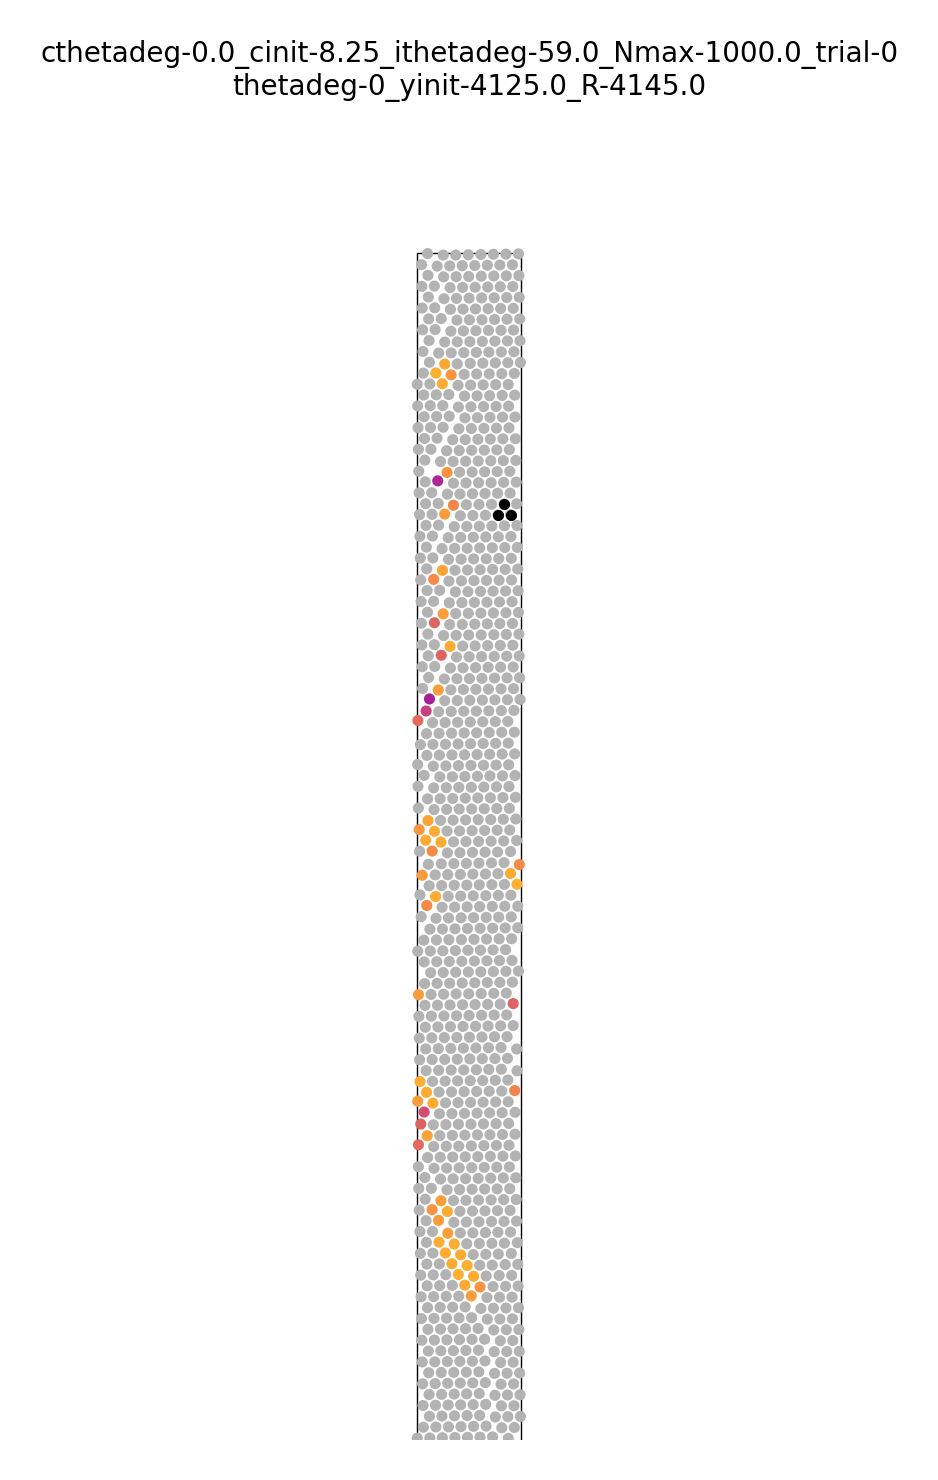

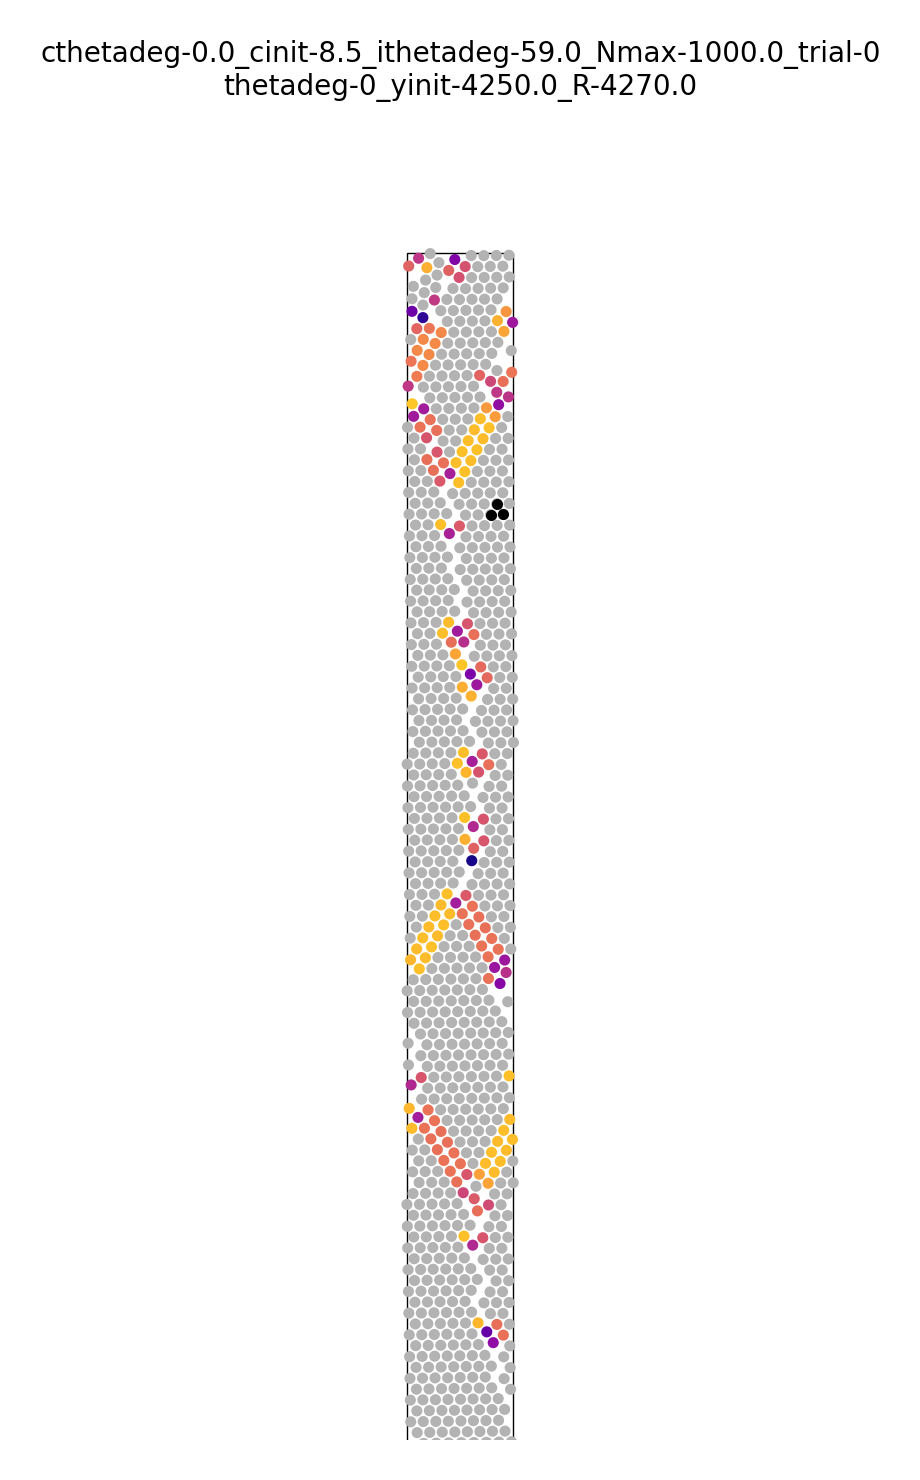

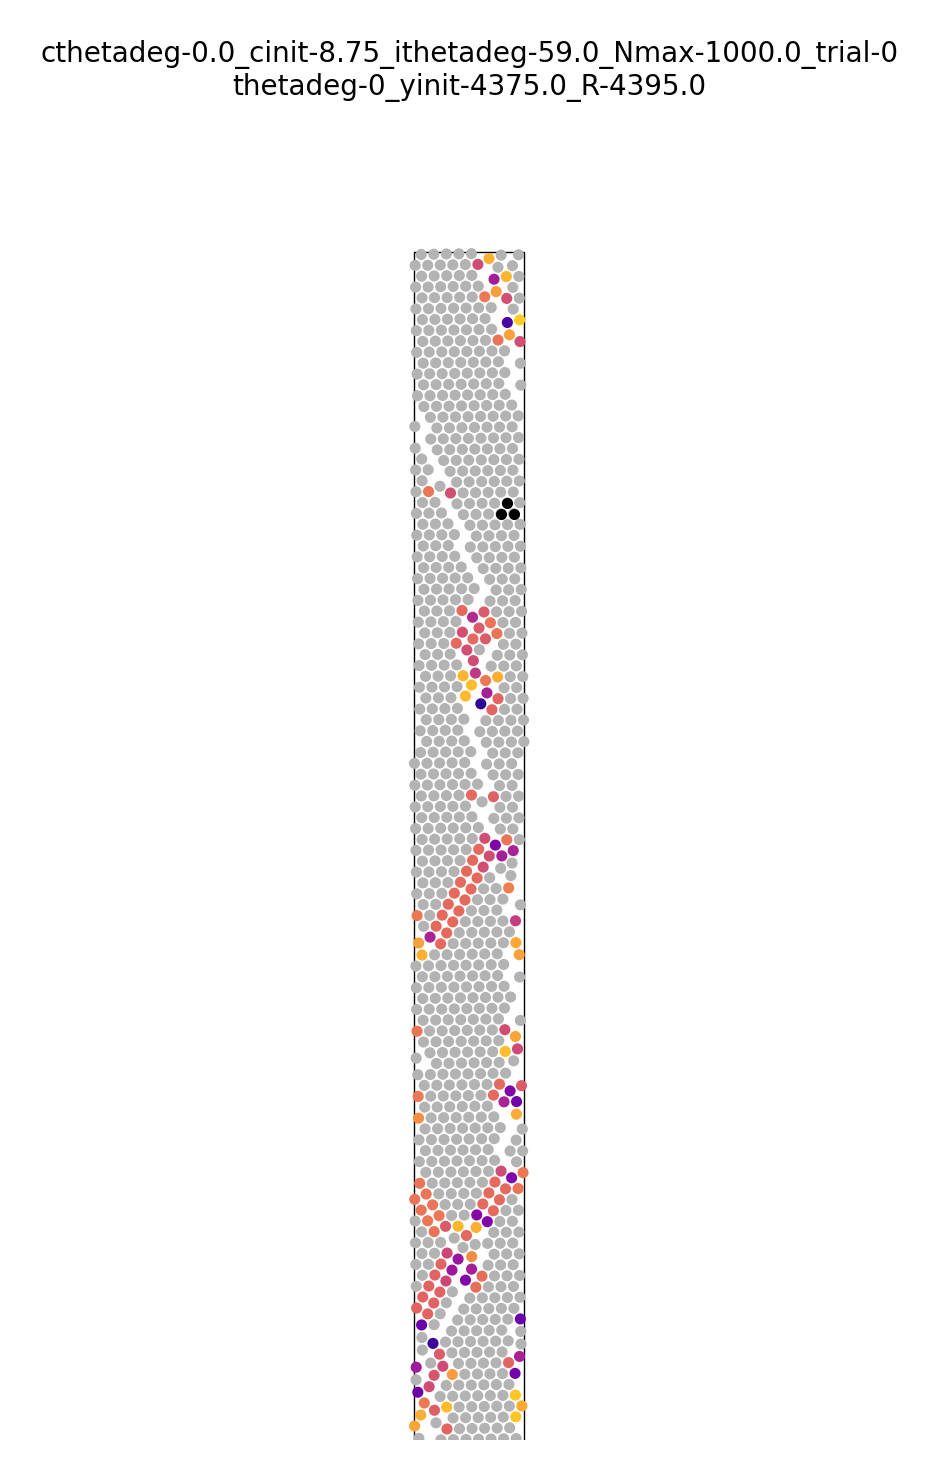

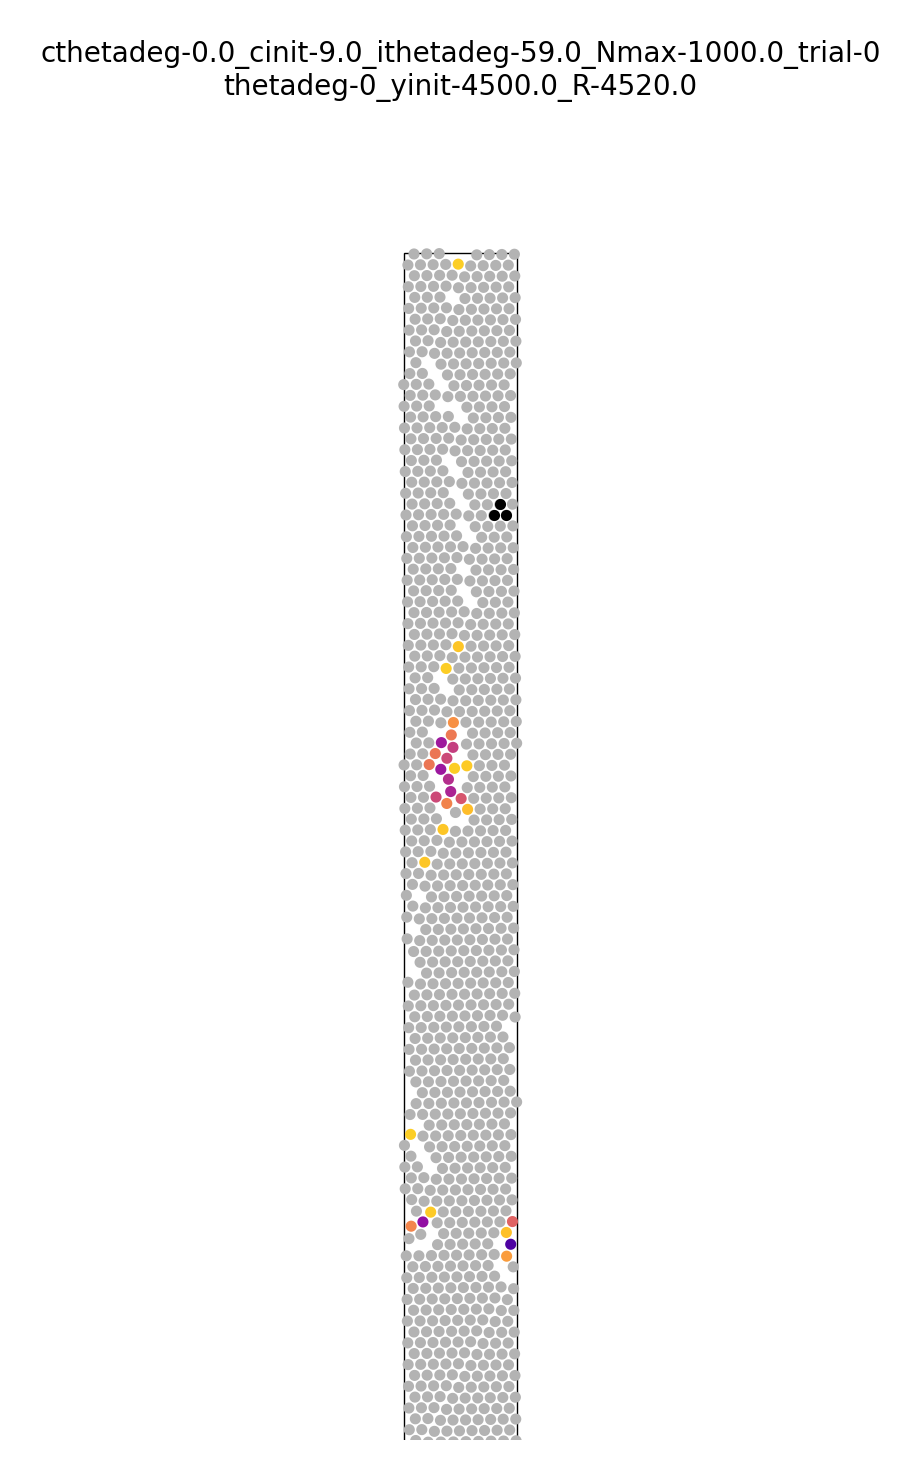

In [90]:
os.chdir(input_dir_c)
cthetadeg=0
# cinit=np.unique(run_dir_df[(run_dir_df['cinit']>8.6)&(run_dir_df['cinit']<8.7)]['cinit'])[0] #5qsrt3
ithetadeg=59
trial=0

cinit_list=[8,8.25,8.5,8.75,9]
# cinit_list=[12,10,8,6,4,2]
# cinit_list=[2,3,4,5,6,7,8,9,10,11,12]

ref_ylim_range=reference_range+50+10 #this is the standard range used for all of my plots so far
new_ylim_range=reference_range+5

ylim_range_ratio=new_ylim_range/ref_ylim_range

for cinit in cinit_list:
    run_dir_df_filtered=run_dir_df_c[
        (run_dir_df_c['cthetadeg']==cthetadeg)
        &(run_dir_df_c['cinit']==cinit)
        &(run_dir_df_c['ithetadeg']==ithetadeg)
        &(run_dir_df_c['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
    data=find_images(data,params_dict)
    data=get_theta6_psi6(data,adj,run_dir)

    fig=plt.figure(figsize=(6.5,6.5*ylim_range_ratio),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,c='psi6',cmap='newcmp')
    
    ####
    #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
    ylim_left=min(data['y'])-10
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
#     ax.set_ylim(ylim_left,ylim_left+ref_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.set_ylim(ylim_left,ylim_left+new_ylim_range) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound    
    ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
    ####
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    #     plt.show()
#     plt.savefig(output_dir+'/fig8b_cylinder_'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinder_cinit'+str(cinit)+'_c_psi6.svg',bbox_inches = "tight")
    ############
#     plot_seed(data,params_dict)
    ############    
    plt.show()

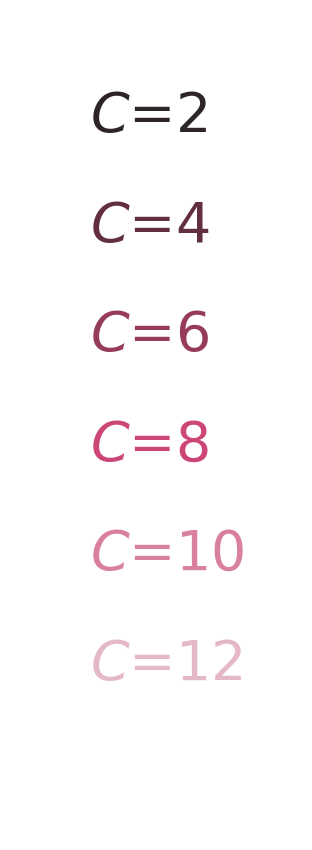

In [67]:
cinit_list=[2,4,6,8,10,12]
fig=plt.figure(figsize=(0.75,2.5),dpi=400)
ax=fig.add_subplot(111)

cylinder_palette_sliced=sns.color_palette(
    c_palette[:n_cylinder][0:1]+ #C=2
    c_palette[:n_cylinder][2:3]+ #C=4
    c_palette[:n_cylinder][4:5]+ #C=6
    c_palette[:n_cylinder][6:7]+ #C=8
    c_palette[:n_cylinder][8:9]+ #C=10            
    c_palette[:n_cylinder][10:11] #C=12                
)
n=len(cinit_list)
# palette=sns.color_palette(sns.dark_palette(sns.color_palette("bright",as_cmap=True)[3],n,reverse=True)[2:3],1)
# palette=palette*n
# palette=sns.color_palette(c_palette[3:3+n])
palette=cylinder_palette_sliced
test_df=pd.DataFrame({'x':np.linspace(0,1,n),'y':np.linspace(0,1,n),'c':cinit_list})
sns.lineplot(x=test_df['x'],y=test_df['y'],hue=test_df['c'],ax=ax,palette=palette,legend=True)
ax.set_ylabel(r'$\rho$')
ax.set_xlabel(r'$C$')
########
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
for label in labels:
    new_labels_list+=[r'$C$='+str(label)] #r'$^{\circ}$'
new_labels = new_labels_list
ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper left',frameon=False,handlelength=0, handletextpad=0,labelspacing=1) #handlelength=0, handletextpad=0 removes the legend markers
ax.axis('off')
# plt.savefig(output_dir+'/fig_cinit_placeholder'+'.png')
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cinitlegend_c.svg',bbox_inches = "tight")

In [68]:
#############
####FIG 9####
#############
#construct giant dataframe

def get_data_collect(run_dir_df_filtered):
    start=start_timer()
#     data_collect=pd.DataFrame([]) #collection of all data
    data_collect_list=[]
    #####
    start=time.time()
    counter_total=len(run_dir_df_filtered['run_dir'].to_list())
    counter_current=0
    looptime_list=[]
    #####   
    for run_dir in run_dir_df_filtered['run_dir'].to_list():     
        ######
        loopstart=time.time()
        counter_current+=1
        ######  
        params_dict=get_params_dict(run_dir)              
        data,adj=load_data(run_dir,shifted=False) #TURN OFF DATA_SHIFTED CALCULATION (visualization purposes only but very slow)      
        data=find_images(data,params_dict)
        data=get_theta6_psi6(data,adj,run_dir)     
        for param in list(params_dict.items()): #attach params to data so that in data_collect we can find the individial trial data still
            data[param[0]]=param[1]
#         data_collect=data_collect.append(data) #DON'T GROW A DATAFRAME!!!!!!!

        data_collect_list+=[data] #make a list of dataframes, then append at the very end 
        ######
        loopend=time.time()
        looptime_list+=[loopend-loopstart]
        avglooptime=np.mean(looptime_list)
        if counter_current%5==1: #print time estimate every 5 loops
            print('time remaining: '+str(np.round(avglooptime*(counter_total-counter_current)/60,2))+' min',end='...')
        ######
    data_collect=pd.concat(data_collect_list,ignore_index=True)
    print('get_data_collect took '+str(np.round((time.time()-start)/60,2))+' min')
    return data_collect
def get_defect_density_collect(data_collect,psi6cutoff_list):
#     defect_density_collect=pd.DataFrame([]) #defect/particle density binned by bin_parameter for all parameter sets and all trials
#     defect_count_collect=pd.DataFrame([]) #all defects binned by bin_parameter for all parameter sets and all trials
#     data_count_collect=pd.DataFrame([]) #all particles binned by bin_parameter for all parameter sets and all trials
    defect_density_collect_list=[]
    defect_count_collect_list=[]
    data_count_collect_list=[]
    #for all trials...
#     start=start_timer()
    counter=0
    maxcounter=len(np.unique(data_collect['cthetadeg']))
    for cthetadeg in np.unique(data_collect['cthetadeg']):
        counter+=1
        print(counter,'/',maxcounter)
        for cinit in np.unique(data_collect['cinit']):
            for ithetadeg in np.unique(data_collect['ithetadeg']):
                for psi6cutoff in psi6cutoff_list:
                    for bin_parameter in ['r','circ']:
                        data_collect_filtered=data_collect[(data_collect['cthetadeg']==cthetadeg)&(data_collect['cinit']==cinit)&(data_collect['ithetadeg']==ithetadeg)] #     &(run_dir_df['trial']==0)
#                         start=stop_timer(start,'get_defect_density_collect1')                            
                        run_dir=data_collect_filtered['run_dir'].iloc[0] #just to get cone parameters
                        params_dict=get_params_dict(run_dir)
                        ##find defect_density for a single parameter set (all trials)
                        defect_count,data_count,defect_density,bin_edges,psi6cutoff=find_defect_density(data_collect_filtered,bin_parameter,params_dict,psi6cutoff=psi6cutoff)
#                         start=stop_timer(start,'get_defect_density_collect2')                                                    
                        ##since we're constructing a giant df, add some labels that describe the defect density (bin parameters, experiment parameters etc)
                        defect_density=np.append(defect_density,0/(-1)) #since bin_edges goes from [0,max) where the bins are [0,1), [1,2)... so the max value (last value) bin should be 0. (-) is my way of notating that it's a missing particle instead of a true 0 defect density.
                        defect_density=np.reshape(defect_density,(1,len(defect_density)))            
                        defect_density=pd.DataFrame(defect_density,columns=bin_edges)

                        defect_count=np.append(defect_count,0/(-1))
                        defect_count=np.reshape(defect_count,(1,len(defect_count)))            
                        defect_count=pd.DataFrame(defect_count,columns=bin_edges)

                        data_count=np.append(data_count,0/(-1))
                        data_count=np.reshape(data_count,(1,len(data_count)))            
                        data_count=pd.DataFrame(data_count,columns=bin_edges)    
                        
#                         start=stop_timer(start,'get_defect_density_collect3')                                                    
                        
                        params=[bin_parameter,cthetadeg,cinit,ithetadeg,psi6cutoff]
                        params=np.reshape(params,(1,len(params))) #note this changes everything to string type
                        params=pd.DataFrame(params,columns=['bin_parameter','cthetadeg','cinit','ithetadeg','psi6cutoff']) #dummy dataframe - it has correct value but incorrect type. single rows are annoying to work with so following lines just replace the value with correct type
                        params['cthetadeg']=cthetadeg #reassign with correct float type
                        params['cinit']=cinit
                        params['ithetadeg']=ithetadeg
                        params['psi6cutoff']=psi6cutoff
                        defect_density=pd.concat([params, defect_density], axis=1)
                        defect_count=pd.concat([params, defect_count], axis=1)   
                        data_count=pd.concat([params, data_count], axis=1)  
                        
#                         defect_density_collect=defect_density_collect.append(defect_density)
#                         defect_count_collect=defect_count_collect.append(defect_density)                    
#                         data_count_collect=data_count_collect.append(data_count)
                        defect_density_collect_list+=[defect_density]
                        defect_count_collect_list+=[defect_count]
                        data_count_collect_list+=[data_count]
#                         start=stop_timer(start,'get_defect_density_collect4')                                                                
    defect_density_collect=pd.concat(defect_density_collect_list,ignore_index=True)
    defect_count_collect=pd.concat(defect_count_collect_list,ignore_index=True)
    data_count_collect=pd.concat(data_count_collect_list,ignore_index=True)
        
    return defect_density_collect,defect_count_collect,data_count_collect
def defect_density_collect_plot(ax,defect_density_collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter):
    for legendvarval in np.unique(defect_density_collect[legendvarkey]): #ithetadeg, for example
        title='defect density vs '+bin_parameter+',vary '+legendvarkey+'\n at '+str(fixed1key)+'='+str(fixed1val)+', '+str(fixed2key)+'='+str(fixed2val)+', '+str(fixed3key)+'='+str(fixed3val)+'\n'

        #select a single parameter set, for all trials
        defect_density_collect_filtered=defect_density_collect[
        (defect_density_collect['bin_parameter']==bin_parameter)
        &(defect_density_collect[fixed3key]==fixed3val)
        &(defect_density_collect[fixed1key]==fixed1val)
        &(defect_density_collect[legendvarkey]==legendvarval)
        &(defect_density_collect[fixed2key]==fixed2val)].dropna(axis=1)

        defect_density=defect_density_collect_filtered.iloc[:,5:-1].values[0]
        bin_edges=defect_density_collect_filtered.iloc[:,5:].columns.values
        midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum
        ax.bar(bin_edges[:-1]+midpoint, defect_density, width = 1,alpha=0.1)
        ax.plot(bin_edges[:-1]+midpoint, defect_density,label=str(round(legendvarval,1)),alpha=1)        
        ax.set_xlim(min(bin_edges), max(bin_edges))
        ax.set_ylim(0,1.05)
        ax.set_xlabel(bin_parameter)
        ax.set_ylabel('Defect density')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)
        ax.set_title(title+'\n')
    return title
def collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter):
    for legendvarval in np.unique(collect[legendvarkey]): #ithetadeg, for example
        title=collectlabel+' vs '+bin_parameter+',vary '+legendvarkey+'\n at '+str(fixed1key)+'='+str(fixed1val)+', '+str(fixed2key)+'='+str(fixed2val)+', '+str(fixed3key)+'='+str(fixed3val)+'\n'

        #select a single parameter set, for all trials
        collect_filtered=collect[
        (collect['bin_parameter']==bin_parameter)
        &(collect[fixed3key]==fixed3val)
        &(collect[fixed1key]==fixed1val)
        &(collect[legendvarkey]==legendvarval)
        &(collect[fixed2key]==fixed2val)].dropna(axis=1)

        defect_density=collect_filtered.iloc[:,5:-1].values[0]
        bin_edges=collect_filtered.iloc[:,5:].columns.values
        midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum
#         ax.bar(bin_edges[:-1], defect_density, width = 1,alpha=0.1)
        ax.plot(bin_edges[:-1]+midpoint, defect_density,label=str(round(legendvarval,1)),alpha=1)        
        ax.set_xlim(min(bin_edges), max(bin_edges))
        ax.set_ylim(0,1.05)
        ax.set_xlabel(bin_parameter)
#         ax.set_ylabel(collectlabel)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)
        ax.set_title(title+'\n')
    return title
def collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette='deep',reverse_sizes=True):
    #similar to collect_plot but plot using seaborn... this requires making a new dataframe with the proper formatting (b/c hue argument requires everything to be connected in the same row)
    sns_df_list=[]
    if reverse_sizes:
        line_sizes=list(np.linspace(0.85,1.15,len(np.unique(collect[legendvarkey]))))[::-1]
    if not reverse_sizes:
        line_sizes=list(np.linspace(0.85,1.15,len(np.unique(collect[legendvarkey]))))
    for legendvarval in np.unique(collect[legendvarkey]): #ithetadeg, for example
        title=collectlabel+' vs '+bin_parameter+',vary '+legendvarkey+'\n at '+str(fixed1key)+'='+str(fixed1val)+', '+str(fixed2key)+'='+str(fixed2val)+', '+str(fixed3key)+'='+str(fixed3val)+'\n'

        #select a single parameter set, for all trials
        collect_filtered=collect[
            (collect['bin_parameter']==bin_parameter)
            &(collect[fixed3key]==fixed3val)
            &(collect[fixed1key]==fixed1val)
            &(collect[fixed2key]==fixed2val)
            &(collect[legendvarkey]==legendvarval)].dropna(axis=1)   

        defect_density=collect_filtered.iloc[:,5:-1].values[0]
        bin_edges=collect_filtered.iloc[:,5:].columns.values
        midpoint=(bin_edges[1]-bin_edges[0])/2 #since bins are from r1 to r2 or c1 to c2; find r0 or c0, which is the midline of the frustum
    #         ax.bar(bin_edges[:-1], defect_density, width = 1,alpha=0.1)
    #     ax.plot(bin_edges[:-1]+midpoint, defect_density,label=str(round(legendvarval,1)),alpha=1)        

        sns_df=pd.DataFrame([])
        sns_df['x']=bin_edges[:-1]+midpoint
        sns_df['y']=defect_density
        sns_df['c']=legendvarval
        sns_df_list+=[sns_df]
    sns_df=pd.concat(sns_df_list,ignore_index=True)
    sns.lineplot(x=sns_df['x'], y=sns_df['y'],hue=sns_df['c'],palette=palette,ax=ax,ci=95,size=sns_df['c'],sizes=line_sizes)
    ax.set_xlim(min(bin_edges), max(bin_edges))
    ax.set_ylim(0,1.05)
    ax.set_xlabel(bin_parameter)
#         ax.set_ylabel(collectlabel)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)
    ax.set_title(title+'\n')
    return title,sns_df
def find_data_collect_psi6cutoff(data_collect,psi6cutoff_list): #data_collect except reevaluate for each psi6 cutoff
    data_collect_psi6cutoff=pd.DataFrame([])
    for psi6cutoff in psi6cutoff_list:
        filtered=data_collect[data_collect['psi6']<psi6cutoff].copy()
        filtered['psi6cutoff']=psi6cutoff
        data_collect_psi6cutoff=data_collect_psi6cutoff.append(filtered)
    return data_collect_psi6cutoff
def data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter):
    for legendvarval in np.unique(data_collect_psi6cutoff[legendvarkey]): #ithetadeg, for example
        title='defect kde vs '+bin_parameter+',vary '+legendvarkey+'\n at '+str(fixed1key)+'='+str(fixed1val)+', '+str(fixed2key)+'='+str(fixed2val)+', '+str(fixed3key)+'='+str(fixed3val)+'\n'

        #select a single parameter set, for all trials
        data_collect_psi6cutoff_filtered=data_collect_psi6cutoff[
#         (data_collect['bin_parameter']==bin_parameter)&
        (data_collect_psi6cutoff[fixed3key]==fixed3val)
        &(data_collect_psi6cutoff[fixed1key]==fixed1val)
        &(data_collect_psi6cutoff[legendvarkey]==legendvarval)
        &(data_collect_psi6cutoff[fixed2key]==fixed2val)].dropna(axis=1)

        data_collect_psi6cutoff_filtered[bin_parameter].plot.kde(ax=ax,label=legendvarval)
        ax.set_xlabel(bin_parameter)
#         ax.set_ylabel('Density')
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)
        ax.set_title(title+'\n')
    return title

# cthetadeg=5
# cinit_list=[5,10]
# ithetadeg=30
# trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(5,2.5),dpi=400)
#     ax=fig.add_subplot(111)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='cthetadeg'
#     fixed3val=cthetadeg

#     legendvarkey='ithetadeg'
#     bin_parameter='r'
    
#     palette='newtwilight'
#     title=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(collectlabel)
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\theta$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########
# #     ax.set_xlim(0,100)
#     ax.set_ylim(0,1)    

#     # ax=fig.add_subplot(122)
#     # bin_parameter='circ'

#     # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)

#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

In [69]:
# axis_color='0.3'
# defect_density_collect['ithetadeg']=np.array(defect_density_collect['ithetadeg']).astype(int) #because it bothers me that the orientation values have decimals lol

# cthetadeg=5
# cinit_list=[10]
# # ithetadeg=30
# # trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[defect_density_collect['ithetadeg']<=30]
# n=len(np.unique(defect_density_collect[defect_density_collect['ithetadeg']<=30]['ithetadeg']))
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(5,2.5),dpi=400)
#     ax=fig.add_subplot(111)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='cthetadeg'
#     fixed3val=cthetadeg

#     legendvarkey='ithetadeg'
#     bin_parameter='circ'
    
#     palette=sns.color_palette(sns.dark_palette(sns.color_palette("muted",as_cmap=True)[4],n,reverse=True)[:n])
#     title,sns_df=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(r'$\rho$')
#     ax.set_xlabel('C')
#     # ax=fig.add_subplot(122)
#     # bin_parameter='circ'

#     # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\theta$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0.2) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########

#     ax.set_xlim(0,10)
#     ax.set_ylim(0,1) 
    
    
#     ax.tick_params(direction="in",colors=axis_color)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_color(axis_color)
#     ax.spines['left'].set_color(axis_color)
#     ax.xaxis.label.set_color(axis_color)
#     ax.yaxis.label.set_color(axis_color)
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
# #     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

In [70]:
theta_palette

[(0.9428705659152788, 0.9428421564820569, 0.9516094133795071),
 (0.7959710078844809, 0.7927177505470654, 0.8820709771273807),
 (0.6455738413291401, 0.6390189539945739, 0.8108768638216322),
 (0.4986742832983422, 0.48889454805958227, 0.7413384275695057),
 (0.3482771167430014, 0.33519575150709086, 0.6701443142637573),
 (0.1978799501876607, 0.18149695495459944, 0.5989502009580088),
 (0.050980392156862744, 0.03137254901960784, 0.5294117647058824),
 (0.06621902953362095, 0.049771275382849464, 0.4746015521136939),
 (0.0818204916098258, 0.0686080666595016, 0.41848633445978667),
 (0.097059128986584, 0.08700679302274322, 0.36367612186759823),
 (0.11266059106278883, 0.10584358429939536, 0.30756090421369103),
 (0.12826205313899366, 0.12468037557604748, 0.25144568655978383),
 (0.14350069051575187, 0.1430791019392891, 0.1966354739675954)]

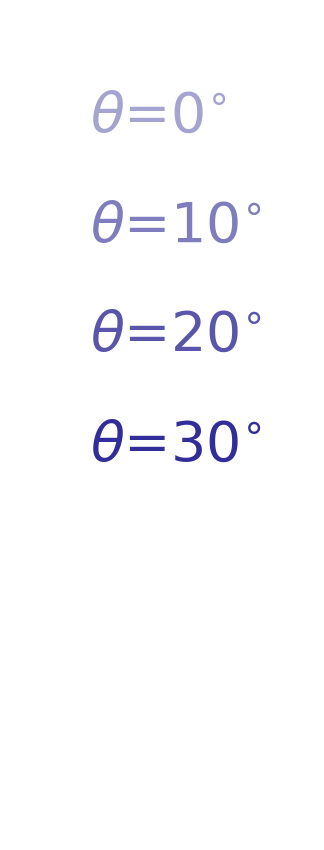

In [71]:
ithetadeg_list=[0,10,20,30]
fig=plt.figure(figsize=(0.75,2.5),dpi=400)
ax=fig.add_subplot(111)

n=len(ithetadeg_list)
# palette=sns.color_palette(sns.dark_palette(sns.color_palette("bright",as_cmap=True)[6],n+1,reverse=True)[1:n+1])
palette=theta_palette[2:2+n]
test_df=pd.DataFrame({'x':np.linspace(0,1,n),'y':np.linspace(0,1,n),'c':ithetadeg_list})
sns.lineplot(x=test_df['x'],y=test_df['y'],hue=test_df['c'],ax=ax,palette=palette,legend=True)
ax.set_ylabel(r'$\rho$')
ax.set_xlabel('C')
########
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
for label in labels:
    new_labels_list+=[r'$\theta$='+str(label)+ r'$^{\circ}$'] #r'$^{\circ}$'
new_labels = new_labels_list
ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper left',frameon=False,handlelength=0, handletextpad=0,labelspacing=1) #handlelength=0, handletextpad=0 removes the legend markers
ax.axis('off')
# plt.savefig(output_dir+'/fig_cinit_placeholder'+'.png')
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig2_thetalegend.svg',bbox_inches = "tight")

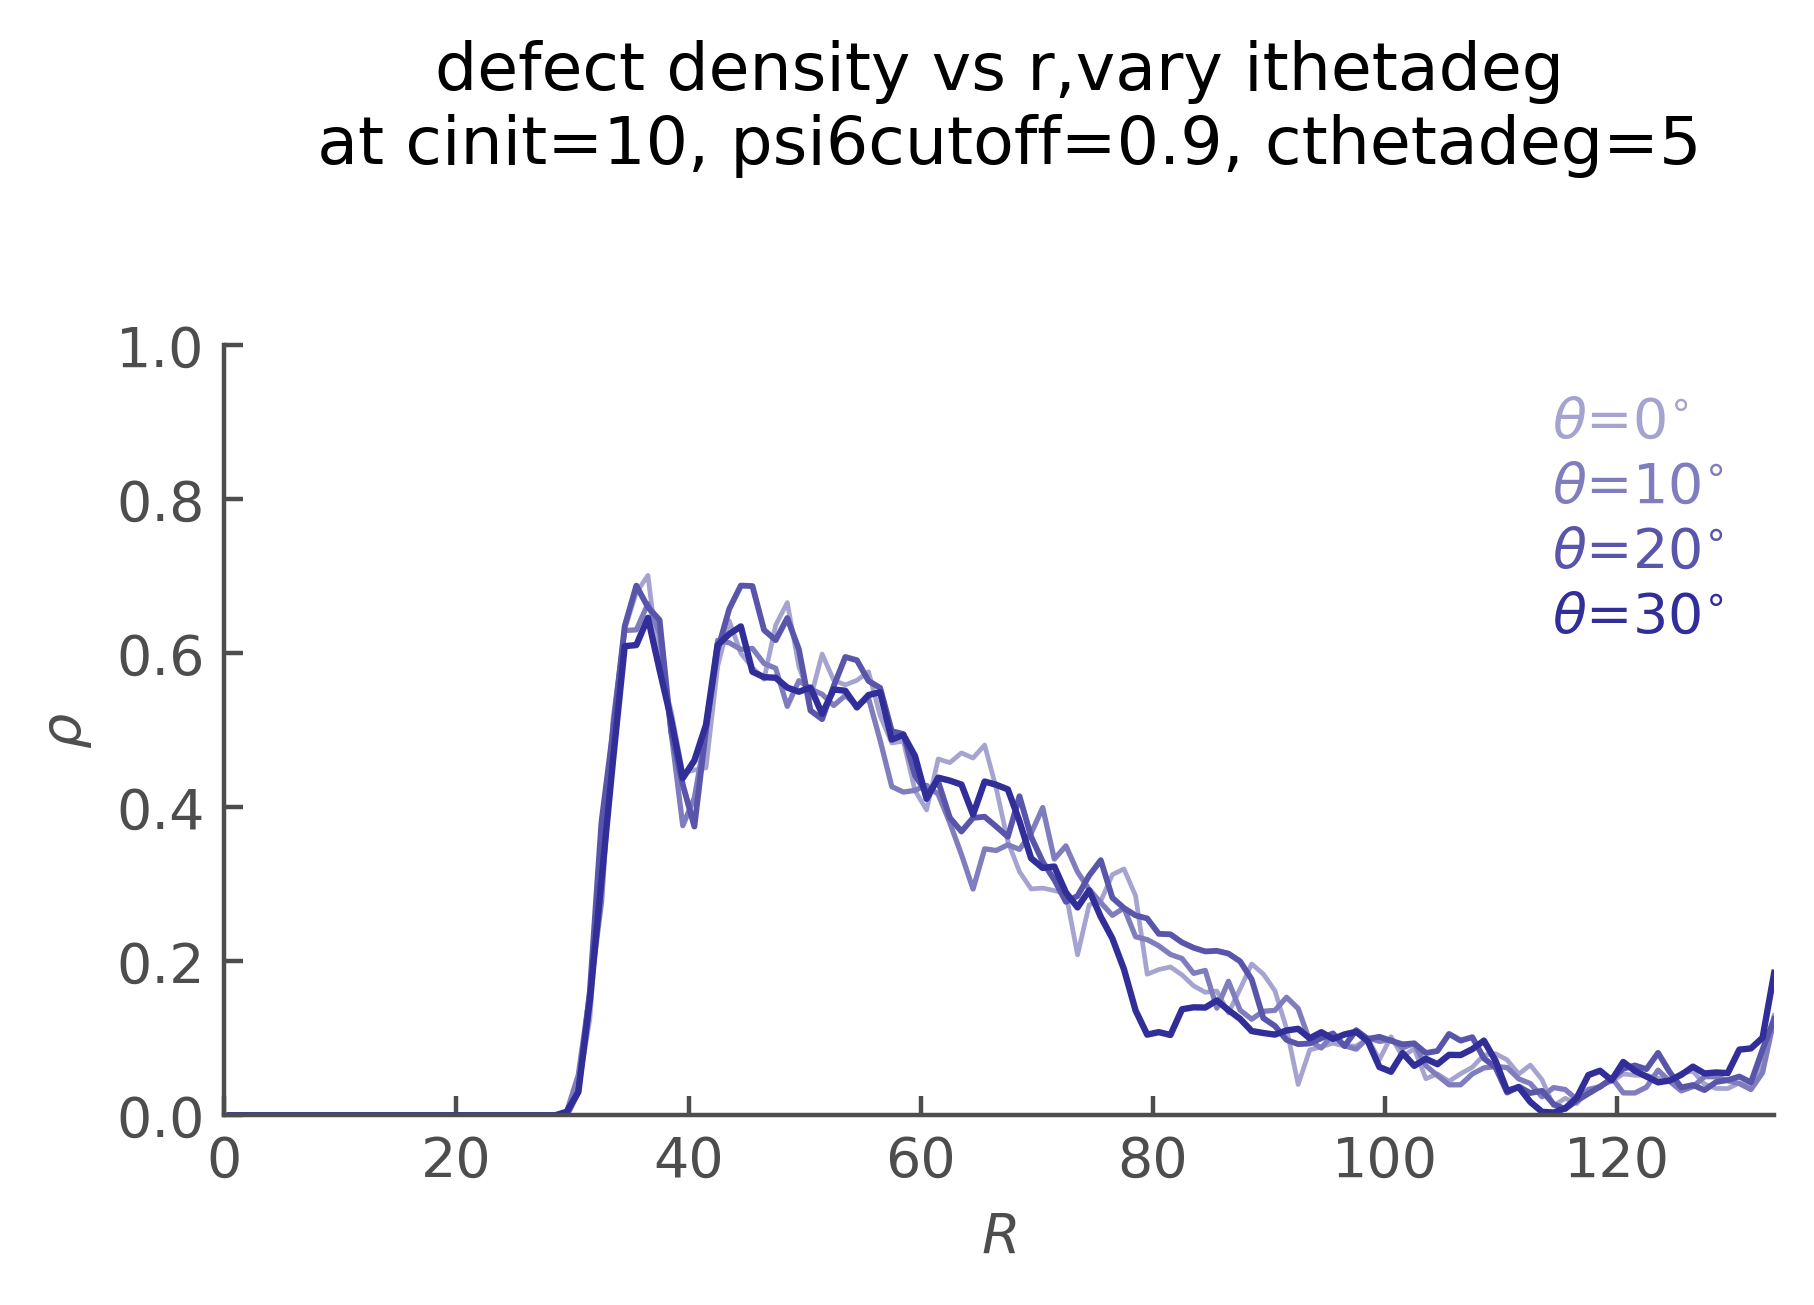

In [72]:
axis_color='0.3'
defect_density_collect['ithetadeg']=np.array(defect_density_collect['ithetadeg']).astype(int) #because it bothers me that the orientation values have decimals lol

cthetadeg=5
cinit_list=[10]
ithetadeg=30
# trial=0
psi6cutoff=0.9

# ### find defect density, defect count, data count histograms...
# collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# collectlabel_list=['defect density','defect count','data count']
# collect_dict=defect_density_collect_dict
# for collect_idx in range(len(collect_list)):
#     collect=collect_list[collect_idx]
#     collectlabel=collectlabel_list[collect_idx]

collect=defect_density_collect[defect_density_collect['ithetadeg']<=30]
n=len(np.unique(defect_density_collect[defect_density_collect['ithetadeg']<=30]['ithetadeg']))
collectlabel='defect density'
################
################ i had trouble wrapping the stuff below as a function...
    # legendvarkey='ithetadeg'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:        
for cinit in cinit_list:
    fig=plt.figure(figsize=(5,2.5),dpi=400)
    ax=fig.add_subplot(111)
    fixed1key='cinit'
    fixed1val=cinit
    fixed2key='psi6cutoff' #psi6cutoff
    fixed2val=psi6cutoff
    fixed3key='cthetadeg'
    fixed3val=cthetadeg

#     legendvarkey='ithetadeg'
    legendvarkey='ithetadeg'
    bin_parameter='r'
    
    # palette=sns.color_palette(sns.dark_palette(sns.color_palette("bright",as_cmap=True)[6],n+1,reverse=True)[1:n+1])
    title,sns_df=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette,reverse_sizes=False)
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel(r'$R$')
    # ax=fig.add_subplot(122)
    # bin_parameter='circ'

    # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
    ########
    handles,labels = ax.get_legend_handles_labels()
    new_labels_list=[]
    for label in labels:
        new_labels_list+=[r'$\theta$='+str(label)+r'$^{\circ}$']
    new_labels = new_labels_list
    ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0.2) #handlelength=0, handletextpad=0 removes the legend markers
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    #######

    ax.set_xlim(0,max(plt.gca().lines[0].get_xdata()))
    ax.set_ylim(0,1)    
    
    ax.tick_params(direction="in",colors=axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.xaxis.label.set_color(axis_color)
    ax.yaxis.label.set_color(axis_color)    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
#     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig2_plot_c.svg',bbox_inches = "tight")
    ax=plt.gca()
    line3=ax.lines[3]
    data3=line3.get_xydata()
    line2=ax.lines[2]
    data2=line2.get_xydata()    
    line1=ax.lines[1]
    data1=line1.get_xydata()        
    line0=ax.lines[0]
    data0=line0.get_xydata()            

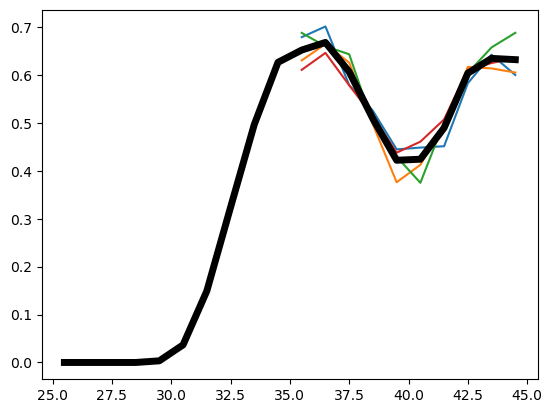

In [73]:
plt.plot(data0[35:45,0],data0[35:45,1])
plt.plot(data1[35:45,0],data1[35:45,1])
plt.plot(data2[35:45,0],data2[35:45,1])
plt.plot(data3[35:45,0],data3[35:45,1])

avg_data=(data0+data1+data2+data3)/4
plt.plot(avg_data[25:45,0],avg_data[25:45,1],color='black',linewidth='5')

In [74]:
np.min(avg_data[35:45,1])

0.42207183711542695

In [75]:
avg_data[0:45]

array([[5.00000000e-01, 0.00000000e+00],
       [1.50000000e+00, 0.00000000e+00],
       [2.50000000e+00, 0.00000000e+00],
       [3.50000000e+00, 0.00000000e+00],
       [4.50000000e+00, 0.00000000e+00],
       [5.50000000e+00, 0.00000000e+00],
       [6.50000000e+00, 0.00000000e+00],
       [7.50000000e+00, 0.00000000e+00],
       [8.50000000e+00, 0.00000000e+00],
       [9.50000000e+00, 0.00000000e+00],
       [1.05000000e+01, 0.00000000e+00],
       [1.15000000e+01, 0.00000000e+00],
       [1.25000000e+01, 0.00000000e+00],
       [1.35000000e+01, 0.00000000e+00],
       [1.45000000e+01, 0.00000000e+00],
       [1.55000000e+01, 0.00000000e+00],
       [1.65000000e+01, 0.00000000e+00],
       [1.75000000e+01, 0.00000000e+00],
       [1.85000000e+01, 0.00000000e+00],
       [1.95000000e+01, 0.00000000e+00],
       [2.05000000e+01, 0.00000000e+00],
       [2.15000000e+01, 0.00000000e+00],
       [2.25000000e+01, 0.00000000e+00],
       [2.35000000e+01, 0.00000000e+00],
       [2.450000

In [76]:
cthetadeg=5
for R in np.arange(20.5,45.5,1):
    C=R*((cthetadeg/180)*np.pi)
    print(R,C)

20.5 1.7889624832941877
21.5 1.876228945893904
22.5 1.9634954084936207
23.5 2.050761871093337
24.5 2.1380283336930535
25.5 2.2252947962927703
26.5 2.3125612588924866
27.5 2.399827721492203
28.5 2.4870941840919194
29.5 2.574360646691636
30.5 2.6616271092913526
31.5 2.748893571891069
32.5 2.8361600344907854
33.5 2.9234264970905017
34.5 3.0106929596902186
35.5 3.097959422289935
36.5 3.1852258848896513
37.5 3.2724923474893677
38.5 3.359758810089084
39.5 3.447025272688801
40.5 3.5342917352885173
41.5 3.6215581978882336
42.5 3.70882466048795
43.5 3.796091123087667
44.5 3.883357585687383


In [ ]:
(3.4447+2.662)/2

In [ ]:
for C in np.arange(2.4,3.9,0.1)[::-1]:
    R=C/((cthetadeg/180)*np.pi)
    print(R,C)

In [ ]:
os.chdir(input_dir)
cthetadeg=5
cinit_list=[10]
# ithetadeg=40
# trial=0
# psi6cutoff=0.9

# ithetadeg_list=[0,10,20,30,40,50,60]
ithetadeg_list=[0,10,20,30]
trials_list=[0]
for cinit in cinit_list:    
    for trial in trials_list:
        for ithetadeg in ithetadeg_list:
            run_dir_df_filtered=run_dir_df[
                (run_dir_df['cthetadeg']==cthetadeg)
                &(run_dir_df['cinit']==cinit)
                &(run_dir_df['ithetadeg']==ithetadeg)
                &(run_dir_df['trial']==trial)]

            run_dir=run_dir_df_filtered['run_dir'][0]
            params_dict=get_params_dict(run_dir)
            data,adj=load_data(run_dir)
            data=find_images(data,params_dict)
            data=get_theta6_psi6(data,adj,run_dir)

        #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
        #             fig8_data=pd.DataFrame([fig8_dict])
        #             fig8_data_list+=[fig8_data]    

            fig=plt.figure(figsize=(6.5,6.5),dpi=400)
            ax=fig.add_subplot(111)
            plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')

            ####
            #fix the ylim range according to reference_range
#             ax.set_ylim(min(data['y'])-10,0) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound            
            ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50)
#             ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
            ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
            ####

            Nactual=len(data)
            info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
        #     plt.show()
#             plt.savefig(output_dir+'/fig9b'+info_tag+'.png')
    #         ############
    #         fig=plt.figure(figsize=(1.5,1.5),dpi=400)
    #         ax=fig.add_subplot(111)
    #         plot_seed(data,params_dict,ax)
    #         ############    
            plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig2cone_ithetadeg'+str(ithetadeg)+'.svg',bbox_inches = "tight")    
            plt.show()

In [17]:
# cthetadeg=5
# cinit_list=[10]
# ithetadeg=40
# trial=0
# # psi6cutoff=0.9

# ithetadeg_list=[0,10,20,30,40,50,60]
# # for cinit in cinit_list:    
# #     for trial in trials_list:
# for ithetadeg in ithetadeg_list:
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==trial)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

# #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig8_data=pd.DataFrame([fig8_dict])
# #             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='psi6',cmap='newcmp')
    
#     ####
#     #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
#     ####
    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9b'+info_tag+'.png')
#     ############
#     fig=plt.figure(figsize=(1.5,1.5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_seed(data,params_dict,ax)
#     ############    

In [18]:
# defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cthetadeg=5
# cinit_list=[10]
# ithetadeg=30
# trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]

# # collect_labeled=collect.copy() #create new df that has the labeled legend values
# # ctheta_legend_list=[]
# # for item in collect_labeled['cthetadeg']:
# #     ctheta_legend_list+=[str(r'$\phi$='+str(item)+r'$^{\circ}$')]
# # collect_labeled['cthetadeg']=ctheta_legend_list

# # collect=collect_labeled
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(7,2.5),dpi=400)
#     ax=fig.add_subplot(121)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='ithetadeg'
#     fixed3val=ithetadeg

#     legendvarkey='cthetadeg'
#     bin_parameter='r'
#     palette='newviridis'
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(r'$\rho$')
#     ax.set_xlabel('R')
#     ax.set_xlim(0,100)   
#     ax.set_ylim(0,1) 
#     ax.get_legend().remove()
    
#     ax=fig.add_subplot(122,sharey=ax)
#     bin_parameter='circ'
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.title.set_visible(not ax.title.get_visible())
#     ax.axes.get_yaxis().set_visible(False) 
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########
#     ax.set_xlabel('C')    
#     ax.set_xlim(0,10)
#     ax.set_ylim(0,1)    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

In [19]:
# defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cthetadeg=5
# cinit_list=[10]
# ithetadeg=40
# trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]

# # collect_labeled=collect.copy() #create new df that has the labeled legend values
# # ctheta_legend_list=[]
# # for item in collect_labeled['cthetadeg']:
# #     ctheta_legend_list+=[str(r'$\phi$='+str(item)+r'$^{\circ}$')]
# # collect_labeled['cthetadeg']=ctheta_legend_list

# # collect=collect_labeled
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(10,2.5),dpi=400)
#     ax=fig.add_subplot(121)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='ithetadeg'
#     fixed3val=ithetadeg

#     legendvarkey='cthetadeg'
#     bin_parameter='r'
    
#     ### SKIP THE FIRST COLOR (BLUE) SINCE WE DON'T WANT TO PLOT THE CYLINDER (BLUE)
#     n=len(np.unique(collect[legendvarkey]))
#     custompalette=sns.color_palette(sns.color_palette("deep")[1:n+1]) #need to specific exact number of colors for legend
#     palette=custompalette
#     ###
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(r'$\rho$')
#     ax.set_xlabel('R')
#     ax.set_xlim(0,100)   
#     ax.set_ylim(0,1) 
#     ax.get_legend().remove()
    
# #     ax=fig.add_subplot(122,sharey=ax)
#     ax=fig.add_subplot(122)
#     bin_parameter='circ'
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.title.set_visible(not ax.title.get_visible())
# #     ax.axes.get_yaxis().set_visible(False) 
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########
#     ax.set_xlabel('C')    
#     ax.set_ylabel(r'$\rho$')    
#     ax.set_xlim(0,10)
#     ax.set_ylim(0,1)    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

NameError: name 'cone_palette' is not defined

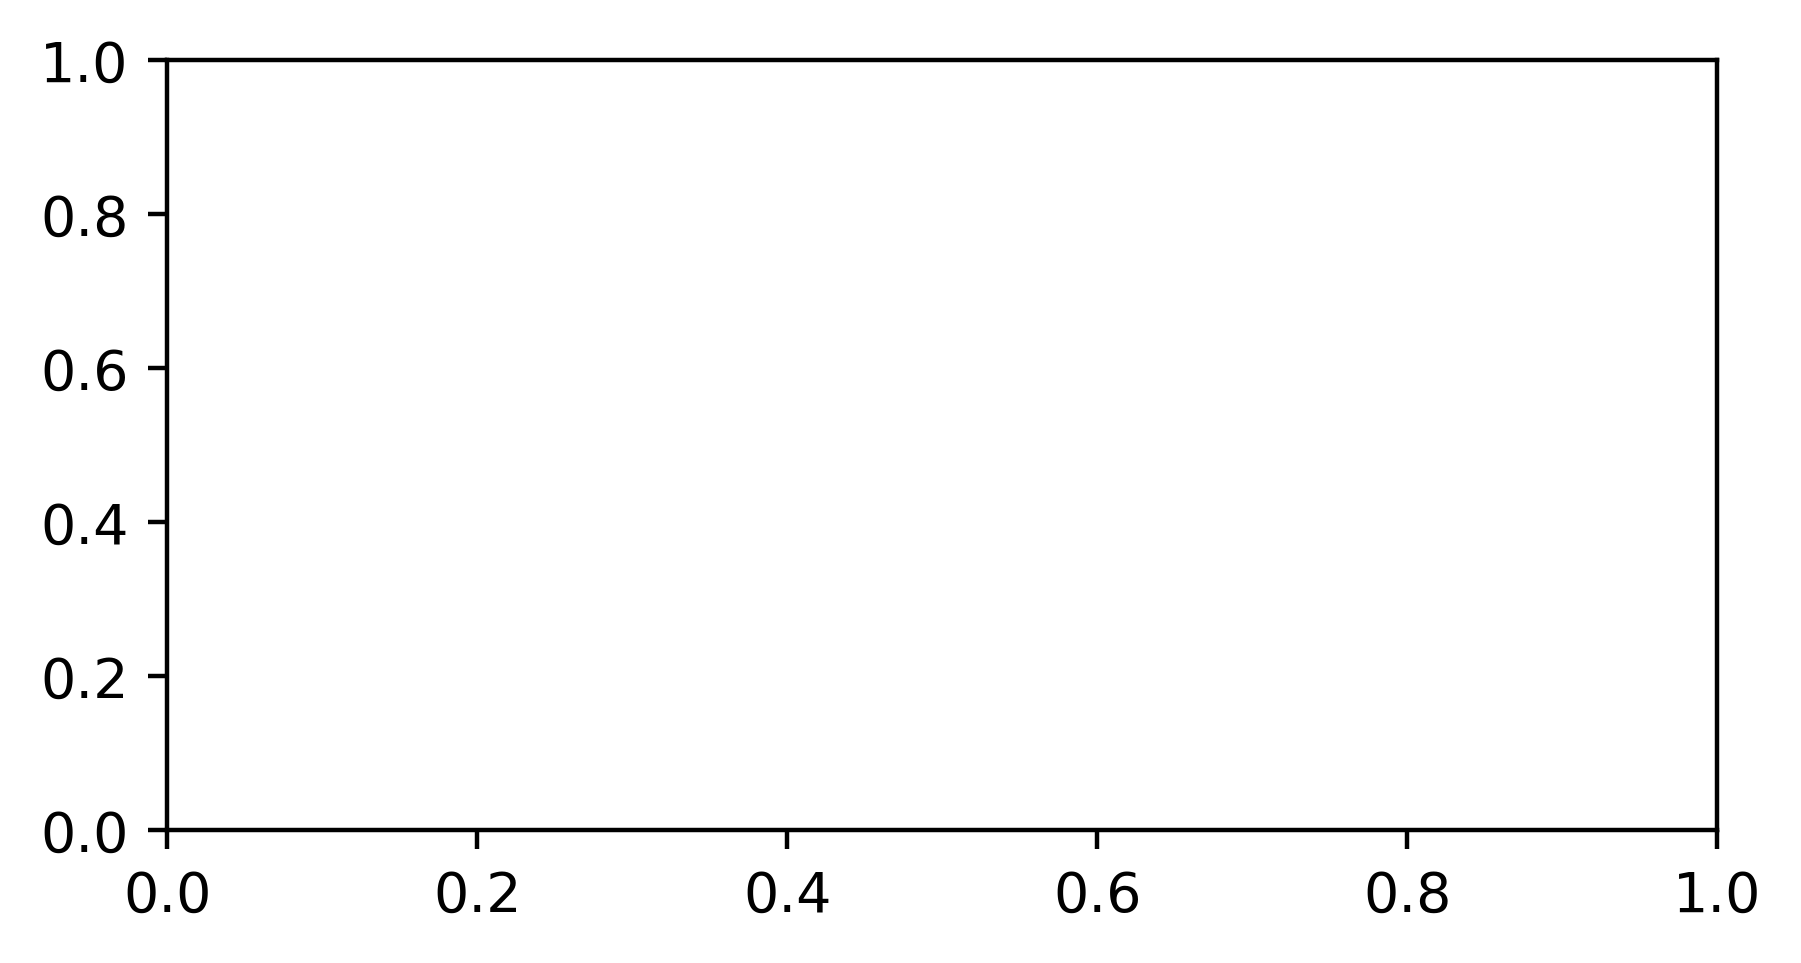

In [20]:
axis_color='0.3'
defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

cthetadeg=5
cinit_list=[10]
ithetadeg=40
trial=0
psi6cutoff=0.9
# ### find defect density, defect count, data count histograms...
# collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# collectlabel_list=['defect density','defect count','data count']
# collect_dict=defect_density_collect_dict
# for collect_idx in range(len(collect_list)):
#     collect=collect_list[collect_idx]
#     collectlabel=collectlabel_list[collect_idx]

collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]

# collect_labeled=collect.copy() #create new df that has the labeled legend values
# ctheta_legend_list=[]
# for item in collect_labeled['cthetadeg']:
#     ctheta_legend_list+=[str(r'$\phi$='+str(item)+r'$^{\circ}$')]
# collect_labeled['cthetadeg']=ctheta_legend_list

# collect=collect_labeled
collectlabel='defect density'
################
################ i had trouble wrapping the stuff below as a function...
    # legendvarkey='ithetadeg'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:        
for cinit in cinit_list:
    fig=plt.figure(figsize=(5,2.5),dpi=400)
    ax=fig.add_subplot(111)
    fixed1key='cinit'
    fixed1val=cinit
    fixed2key='psi6cutoff' #psi6cutoff
    fixed2val=psi6cutoff
    fixed3key='ithetadeg'
    fixed3val=ithetadeg

    legendvarkey='cthetadeg'
    bin_parameter='r'
    
    ### SKIP THE FIRST COLOR (BLUE) SINCE WE DON'T WANT TO PLOT THE CYLINDER (BLUE)
    n=len(np.unique(collect[legendvarkey]))
#     custompalette=sns.color_palette(sns.color_palette("deep")[1:n+1]) #need to specific exact number of colors for legend
#     palette=custompalette
    # palette=sns.color_palette(sns.dark_palette(sns.color_palette("deep",as_cmap=True)[1],n,reverse=True)[:n])
    palette=cone_palette
    ###
    title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette,reverse_sizes=False)
    ########
    handles,labels = ax.get_legend_handles_labels()
    new_labels_list=[]
    for label in labels:
        new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
    new_labels = new_labels_list
    ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########
    
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel(r'$R$')
#     ax.set_xlim(0,100)   
    ax.set_xlim(0,max(plt.gca().lines[0].get_xdata()))
    ax.set_ylim(0,1) 

    ax.tick_params(direction="in",colors=axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.xaxis.label.set_color(axis_color)
    ax.yaxis.label.set_color(axis_color)        
#     ax.get_legend().remove()
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig3cone_cthetadegR.svg',bbox_inches = "tight")

    fig=plt.figure(figsize=(5,2.5),dpi=400)
    ax=fig.add_subplot(111)
#     ax=fig.add_subplot(122)
    bin_parameter='circ'
    title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette,reverse_sizes=False)
#     ax.title.set_visible(not ax.title.get_visible())
#     ax.axes.get_yaxis().set_visible(False) 
    ########
    handles,labels = ax.get_legend_handles_labels()
    new_labels_list=[]
    for label in labels:
        new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
    new_labels = new_labels_list
    ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########
    ax.set_xlabel(r'$C$')    
    ax.set_ylabel(r'$\rho$')    
#     ax.set_xlim(0,10)
    ax.set_xlim(0,12)
    ax.set_ylim(0,1) 
    

    ax.tick_params(direction="in",colors=axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.xaxis.label.set_color(axis_color)
    ax.yaxis.label.set_color(axis_color)    
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
#     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig3cone_cthetadegC.svg',bbox_inches = "tight")
    

In [ ]:
cthetadeg_list=[5,10,15,20,25,30]
fig=plt.figure(figsize=(0.75,2.5),dpi=400)
ax=fig.add_subplot(111)

# n=len(cthetadeg_list)
# palette=sns.color_palette(sns.dark_palette(sns.color_palette("deep",as_cmap=True)[1],n,reverse=True)[:n])
# palette=sns.color_palette(phi_palette[1:1+n])
palette=cone_palette
test_df=pd.DataFrame({'x':np.linspace(0,1,n),'y':np.linspace(0,1,n),'c':cthetadeg_list})
sns.lineplot(x=test_df['x'],y=test_df['y'],hue=test_df['c'],ax=ax,palette=palette,legend=True)
ax.set_ylabel(r'$\rho$')
ax.set_xlabel('C')
########
handles,labels = ax.get_legend_handles_labels()
new_labels_list=[]
for label in labels:
    new_labels_list+=[r'$\phi$='+str(label)+ r'$^{\circ}$'] #r'$^{\circ}$'
new_labels = new_labels_list
ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper left',frameon=False,handlelength=0, handletextpad=0,labelspacing=1) #handlelength=0, handletextpad=0 removes the legend markers
ax.axis('off')
# plt.savefig(output_dir+'/fig_cinit_placeholder'+'.png')
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig3_cthetalegend.svg',bbox_inches = "tight")


In [ ]:
# defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cthetadeg=5
# cinit_list=[10]
# ithetadeg=40
# trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]

# # collect_labeled=collect.copy() #create new df that has the labeled legend values
# # ctheta_legend_list=[]
# # for item in collect_labeled['cthetadeg']:
# #     ctheta_legend_list+=[str(r'$\phi$='+str(item)+r'$^{\circ}$')]
# # collect_labeled['cthetadeg']=ctheta_legend_list

# # collect=collect_labeled
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(10,2.5),dpi=400)
#     ax=fig.add_subplot(121)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='ithetadeg'
#     fixed3val=ithetadeg

#     legendvarkey='cthetadeg'
#     bin_parameter='r'
    
#     ### SKIP THE FIRST COLOR (BLUE) SINCE WE DON'T WANT TO PLOT THE CYLINDER (BLUE)
#     n=len(np.unique(collect[legendvarkey]))
#     custompalette=sns.color_palette(sns.color_palette("deep")[1:n+1]) #need to specific exact number of colors for legend
#     palette=custompalette
#     ###
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(r'$\rho$')
#     ax.set_xlabel('R')
#     ax.set_xlim(0,max(plt.gca().lines[0].get_xdata()))
# #     ax.set_xlim(0,100)   
#     ax.set_ylim(0,1) 
#     ax.get_legend().remove()
    
# #     ax=fig.add_subplot(122,sharey=ax)
#     ax=fig.add_subplot(122)
#     bin_parameter='circ'
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.title.set_visible(not ax.title.get_visible())
# #     ax.axes.get_yaxis().set_visible(False) 
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0,labelspacing=0) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########
#     ax.set_xlabel('C')    
#     ax.set_ylabel(r'$\rho$')    
# #     ax.set_xlim(0,10)
# #     ax.set_xlim(0,max(plt.gca().lines[1].get_xdata()))
#     ax.set_xlim(0,12)
#     ax.set_ylim(0,1)    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

In [ ]:
# cthetadeg_list=[5,10,15,20,25,30]
cthetadeg_list=[5,10,15]
cinit_list=[10]
ithetadeg=40
trial=0
# psi6cutoff=0.9

# ithetadeg_list=30
# for cinit in cinit_list:    
#     for trial in trials_list:
# counter=0
for cthetadeg in cthetadeg_list:
    run_dir_df_filtered=run_dir_df[
        (run_dir_df['cthetadeg']==cthetadeg)
        &(run_dir_df['cinit']==cinit)
        &(run_dir_df['ithetadeg']==ithetadeg)
        &(run_dir_df['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
    data=find_images(data,params_dict)
    data=get_theta6_psi6(data,adj,run_dir)

#             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
#             fig8_data=pd.DataFrame([fig8_dict])
#             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
    fig=plt.figure(figsize=(6.5,6.5),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
    ####
    #fix the ylim range according to reference_range
    ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50)    
#     counter+=1
#     if counter==1:
#         ylimmin=min(data['y']) #find ylimmin only upon first run (so the longest taper sector)
#         ax.set_ylim(ylimmin-10,0) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     else:
#         ax.set_ylim(ylimmin-10,0)
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
    ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
    ####
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
#     plt.show()
#     plt.savefig(output_dir+'/fig9b'+info_tag+'.png')
    ############
#     fig=plt.figure(figsize=(1.5,1.5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_seed(data,params_dict,ax)
#     ############
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig3cone_cthetadeg'+str(cthetadeg)+'.svg',bbox_inches = "tight")

In [ ]:
fig=plt.figure(figsize=(1,1),dpi=400)
ax=fig.add_subplot(111)

x=np.arange(-3.5,-0.5,1)
y=np.repeat(np.sqrt(3)/2,len(x)) #row 1, left
ax.scatter(x,y,c='0.8')

x=np.arange(-3,0,1)
y=np.repeat(0,len(x)) #row 2, left
ax.scatter(x,y,c='0.8')

x=np.arange(-3.5,-0.5,1)
y=np.repeat(-np.sqrt(3)/2,len(x)) #row 3, left
ax.scatter(x,y,c='0.8')

#############
shift=0.4

x=np.arange(-0.5+shift,2.5+shift,1)
y=np.repeat(np.sqrt(3)/2,len(x)) #row 1, right
ax.scatter(x,y,c='0.8')

x=np.arange(0+shift,2+shift,1)
y=np.repeat(0,len(x)) #row 2, right
ax.scatter(x,y,c='0.8')

x=np.arange(-0.5+shift,2.5+shift,1)
y=np.repeat(-np.sqrt(3)/2,len(x)) #row 3, right
ax.scatter(x,y,c='0.8')
#############
dark_color=(0.1,0.2,0.6,1)
light_color=(0.1,0.2,0.6,0.5)

x=np.arange(0+shift,2+shift,1)[0] #left particle
y=np.repeat(np.sqrt(3),1) #row 0, right
ax.scatter(x,y,color=dark_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x,y,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)

x=np.arange(0+shift,2+shift,1)[1] #right particle
y=np.repeat(np.sqrt(3),1) #row 0, right
ax.scatter(x,y,color=light_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x,y,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)

x=np.arange(0+shift-1,2+shift,1)[0] #right particle
y=np.repeat(np.sqrt(3),1) #row 0, right
ax.scatter(x,y,color=light_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x,y,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)

ax.axis('off')
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig5growth_a.svg',bbox_inches = "tight")    
plt.show()


In [ ]:
fig=plt.figure(figsize=(1,1),dpi=400)
ax=fig.add_subplot(111)

x=np.arange(-3.5,-0.5,1)
y=np.repeat(np.sqrt(3)/2,len(x)) #row 1, left
ax.scatter(x,y,c='0.8')

x=np.arange(-3,0,1)
y=np.repeat(0,len(x)) #row 2, left
ax.scatter(x,y,c='0.8')

x=np.arange(-3.5,-0.5,1)
y=np.repeat(-np.sqrt(3)/2,len(x)) #row 3, left
ax.scatter(x,y,c='0.8')

#############
shift=0.4

x=np.arange(-0.5+shift,2.5+shift,1)
y=np.repeat(np.sqrt(3)/2,len(x)) #row 1, right
ax.scatter(x,y,c='0.8')

x=np.arange(0+shift,2+shift,1)
y=np.repeat(0,len(x)) #row 2, right
ax.scatter(x,y,c='0.8')

x=np.arange(-0.5+shift,2.5+shift,1)
y=np.repeat(-np.sqrt(3)/2,len(x)) #row 3, right
ax.scatter(x,y,c='0.8')
#############
dark_color=(0.8,0.2,0.2,1)
light_color=(0.8,0.2,0.2,0.5)
midpoint=(-1.5+(-0.5+shift))/2
x_defect=midpoint
y_defect=np.sqrt(1**2-(-0.5+shift-midpoint)**2)+np.sqrt(3)/2
ax.scatter(x_defect,y_defect,color=dark_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x_defect,y_defect,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)


pointA=np.array([x_defect,y_defect])
pointB=np.array([-0.5+shift,np.sqrt(3)/2]) #row 1, right
theta=np.deg2rad(60)
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
v = np.dot(rot, pointB-pointA)
x=v[0]+pointA[0]
y=v[1]+pointA[1]
ax.scatter(x,y,color=light_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x,y,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)

pointA=np.array([x_defect,y_defect])
pointB=np.array([-1.5,np.sqrt(3)/2]) #row 1, left
theta=np.deg2rad(-60)
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
v = np.dot(rot, pointB-pointA)
x=v[0]+pointA[0]
y=v[1]+pointA[1]
ax.scatter(x,y,color=light_color,s=mpl.rcParams['lines.markersize']**2) #default size
ax.scatter(x,y,c='1',s=mpl.rcParams['lines.markersize']**2-10) #draw outline (the built in edge thickness doesn't work)

ax.axis('off')
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig5growth_b.svg',bbox_inches = "tight")    
plt.show()

In [ ]:
# defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cthetadeg=5
# cinit_list=[5]
# ithetadeg=30
# trial=0
# psi6cutoff=0.9

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# #     for cthetadeg in collect_dict['cthetadeg']:
# #         for cinit in collect_dict['cinit']:
# #             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
#     fig=plt.figure(figsize=(5,2.5),dpi=400)
#     ax=fig.add_subplot(111)
#     fixed1key='cinit'
#     fixed1val=cinit
#     fixed2key='psi6cutoff' #psi6cutoff
#     fixed2val=psi6cutoff
#     fixed3key='ithetadeg'
#     fixed3val=ithetadeg

#     legendvarkey='cthetadeg'
#     bin_parameter='circ'
#     palette='newviridis'
#     title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
#     ax.set_ylabel(r'$\rho$')
#     ax.set_xlabel('C')
#     # ax=fig.add_subplot(122)
#     # bin_parameter='circ'

#     # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########
#     handles,labels = ax.get_legend_handles_labels()
#     new_labels_list=[]
#     for label in labels:
#         new_labels_list+=[r'$\phi$='+str(label)+r'$^{\circ}$']
#     new_labels = new_labels_list
#     ax.legend(handles,new_labels,labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0) #handlelength=0, handletextpad=0 removes the legend markers
# #     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
#     ########

#     ax.set_xlim(0,10)
#     ax.set_ylim(0,1)    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')

In [ ]:
axis_color='0.3'
defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cthetadeg=5
# cthetadeg_list=[5,10,15,20,25,30]
cthetadeg_list=[5]
# cinit_list=[5]
cinit=10
ithetadeg=40
trial=0
# psi6cutoff=0.9
psi6cutoff_list=[0.5,0.6,0.7,0.8,0.9]

# ### find defect density, defect count, data count histograms...
# collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# collectlabel_list=['defect density','defect count','data count']
# collect_dict=defect_density_collect_dict
# for collect_idx in range(len(collect_list)):
#     collect=collect_list[collect_idx]
#     collectlabel=collectlabel_list[collect_idx]

collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]
collectlabel='defect density'
################
################ i had trouble wrapping the stuff below as a function...
    # legendvarkey='ithetadeg'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:        
# for cinit in cinit_list:
for cthetadeg in cthetadeg_list:
    fig=plt.figure(figsize=(5,2.5),dpi=400)
    ax=fig.add_subplot(111)
    fixed1key='cinit'
    fixed1val=cinit
    fixed2key='cthetadeg' #psi6cutoff
    fixed2val=cthetadeg
    fixed3key='ithetadeg'
    fixed3val=ithetadeg

    legendvarkey='psi6cutoff'
    bin_parameter='circ'
    # palette='newviridis'
    n=len(np.unique(collect[legendvarkey]))
    palette=psi_palette[1:1+n]
    title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel(r'$C$')
    # ax=fig.add_subplot(122)
    # bin_parameter='circ'

    # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########
    handles,labels = ax.get_legend_handles_labels()
    new_labels_list=[]
    for label in labels:
        new_labels_list+=[r'$\left|\psi_6\right|$<'+str(label)]
    new_labels = new_labels_list
    ax.legend(handles[::-1],new_labels[::-1],labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0) #handlelength=0, handletextpad=0 removes the legend markers
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########

    # ax.set_xlim(0,10)
    # ax.set_ylim(0,1)   
    
    ax.set_xlim(0,12)
    ax.set_ylim(0,1)    
    
    ax.tick_params(direction="in",colors=axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.xaxis.label.set_color(axis_color)
    ax.yaxis.label.set_color(axis_color)    
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
#     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/appendix_psi6cutoff.svg',bbox_inches = "tight")

In [ ]:
# cthetadeg_list=[5,10,15,20,25,30]
# cinit=5
# ithetadeg=30
# trial=0
# # psi6cutoff=0.9

# ithetadeg_list=30
# # for cinit in cinit_list:    
# #     for trial in trials_list:
# for cthetadeg in cthetadeg_list:
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==trial)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

# #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig8_data=pd.DataFrame([fig8_dict])
# #             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
#     ####
#     #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
#     ####
    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9b'+info_tag+'.png')
#     ############
#     fig=plt.figure(figsize=(1.5,1.5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_seed(data,params_dict,ax)
#     ############    

In [ ]:
# np.unique(defect_density_collect['cinit'])

In [ ]:
axis_color='0.3'
# defect_density_collect['cthetadeg']=np.array(defect_density_collect['cthetadeg']).astype(int) #because it bothers me that the values have decimals lol

# cylinder_palette_sliced=sns.color_palette(
#     c_palette[:n_cylinder][3:4]+ #C=5
#     c_palette[:n_cylinder][4:5]+ #C=6 
#     c_palette[:n_cylinder][5:6]+ #C=7
#     c_palette[:n_cylinder][6:7]+ #C=8
#     c_palette[:n_cylinder][7:8]+ #C=9
#     c_palette[:n_cylinder][8:9] #C=10                           
# )
cylinder_palette_sliced=sns.color_palette(
    c_palette[:n_cylinder][0:1]+ #C=5
    c_palette[:n_cylinder][2:3]+ #C=6 
    c_palette[:n_cylinder][4:5]+ #C=7
    c_palette[:n_cylinder][6:7]+ #C=8
    c_palette[:n_cylinder][8:9]+ #C=9
    c_palette[:n_cylinder][10:11] #C=10                           
)
cthetadeg=5
cinit_list=[5]
ithetadeg=40
trial=0
psi6cutoff=0.9

# ### find defect density, defect count, data count histograms...
# collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# collectlabel_list=['defect density','defect count','data count']
# collect_dict=defect_density_collect_dict
# for collect_idx in range(len(collect_list)):
#     collect=collect_list[collect_idx]
#     collectlabel=collectlabel_list[collect_idx]

collect=defect_density_collect[(defect_density_collect['cthetadeg']>=5)&(defect_density_collect['cthetadeg']<=30)]
collect_list=[defect_density_collect[(defect_density_collect['cinit']==5)],
             defect_density_collect[(defect_density_collect['cinit']==6)],
             defect_density_collect[(defect_density_collect['cinit']==7)],
             defect_density_collect[(defect_density_collect['cinit']==8)],              
             defect_density_collect[(defect_density_collect['cinit']==9)],
             defect_density_collect[(defect_density_collect['cinit']==10)]]
collect=pd.concat(collect_list,ignore_index=True)
collect['cinit']=np.array(collect['cinit']).astype(int) #because it bothers me that the values have decimals lol
collectlabel='defect density'
################
################ i had trouble wrapping the stuff below as a function...
    # legendvarkey='ithetadeg'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:        
for cinit in cinit_list:
    fig=plt.figure(figsize=(5,2.5),dpi=400)
    ax=fig.add_subplot(111)
    fixed1key='cthetadeg'
    fixed1val=cinit
    fixed2key='psi6cutoff' #psi6cutoff
    fixed2val=psi6cutoff
    fixed3key='ithetadeg'
    fixed3val=ithetadeg

    legendvarkey='cinit'
    bin_parameter='circ'
    # palette='newcividis'
    # n=len(np.unique(collect[legendvarkey]))
    palette=cylinder_palette_sliced
    
    title,df_sns=collect_plot_sns(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter,palette)
    ax.set_ylabel(r'$\rho$')
    ax.set_xlabel(r'$C$')
    # ax=fig.add_subplot(122)
    # bin_parameter='circ'

    # title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########
    handles,labels = ax.get_legend_handles_labels()
    new_labels_list=[]
    for label in labels:
        new_labels_list+=[r'$C$='+str(label)] #r'$^{\circ}$'
    new_labels = new_labels_list
    ax.legend(handles[::-1],new_labels[::-1],labelcolor='linecolor',loc='upper right',frameon=False,handlelength=0, handletextpad=0) #handlelength=0, handletextpad=0 removes the legend markers
#     ax.legend(loc='upper right',frameon=False) #title=r'$\theta$',bbox_to_anchor=(1, 0.5),prop={'size': 6}
    ########
    ax.set_xlim(0,12)
    ax.set_ylim(0,1)    
    
    ax.tick_params(direction="in",colors=axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.xaxis.label.set_color(axis_color)
    ax.yaxis.label.set_color(axis_color)    
    
#     ax.set_xlim(0,10)
#     ax.set_ylim(0,1)    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)+'_psi6cutoff-'+str(psi6cutoff)
#     plt.show()
#     plt.savefig(output_dir+'/fig9a'+info_tag+'.png')
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/appendix_cinit.svg',bbox_inches = "tight")

In [ ]:
# cthetadeg_list=[5,10,15,20,25,30]
cthetadeg_list=[5]
cinit_list=[5,6,7,8,9,10]
ithetadeg=40
trial=0
# psi6cutoff=0.9

# ithetadeg_list=30
# for cinit in cinit_list:    
#     for trial in trials_list:
# counter=0
for cinit in cinit_list:
    run_dir_df_filtered=run_dir_df[
        (run_dir_df['cthetadeg']==cthetadeg)
        &(run_dir_df['cinit']==cinit)
        &(run_dir_df['ithetadeg']==ithetadeg)
        &(run_dir_df['trial']==trial)]

    run_dir=run_dir_df_filtered['run_dir'][0]
    params_dict=get_params_dict(run_dir)
    data,adj=load_data(run_dir)
    data=find_images(data,params_dict)
    data=get_theta6_psi6(data,adj,run_dir)

#             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
#             fig8_data=pd.DataFrame([fig8_dict])
#             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
    fig=plt.figure(figsize=(6.5,6.5),dpi=400)
    ax=fig.add_subplot(111)
    plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
    ####
    #fix the ylim range according to reference_range
    ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+50)    
#     counter+=1
#     if counter==1:
#         ylimmin=min(data['y']) #find ylimmin only upon first run (so the longest taper sector)
#         ax.set_ylim(ylimmin-10,0) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     else:
#         ax.set_ylim(ylimmin-10,0)
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
    ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
    ####
    
    Nactual=len(data)
    info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
    #     plt.show()
#     plt.savefig(output_dir+'/fig8b_cylinder_'+info_tag+'.png')
    # plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/fig4cylinder_cinit'+str(cinit)+'.svg',bbox_inches = "tight")
    plt.savefig('/Users/jessicasun/Documents/GitHub/062122-bennett-draft/main_figs/figure_components_svg/appendix_cinit_'+str(cinit)+'.svg',bbox_inches = "tight")    
    ############
#     plot_seed(data,params_dict)
    ############    
    plt.show()

In [ ]:
# cthetadeg=5
# cinit_list=[5,6,7,8,9,10]
# ithetadeg=30
# trial=0
# # psi6cutoff=0.9

# ithetadeg_list=30
# # for cinit in cinit_list:    
# #     for trial in trials_list:
# for cinit in cinit_list:
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==trial)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

# #             fig8_dict={'cthetadeg':cthetadeg,'cinit':cinit,'ithetadeg':ithetadeg,'trial':trial,'avg_psi6':np.mean(data['psi6'])}
# #             fig8_data=pd.DataFrame([fig8_dict])
# #             fig8_data_list+=[fig8_data]    

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='newcmp')
    
#     ####
#     #fix the ylim range according to reference_range
#     ax.set_ylim(min(data['y'])-10,min(data['y'])+reference_range+10) #the max is always y=20 above the nucleation seed. so we really only need to find the lower bound
#     ax.invert_yaxis() #setting ylim flips the axis..so we gotta flip it back..
#     ####
    
#     Nactual=len(data)
#     info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     plt.show()
#     plt.savefig(output_dir+'/fig9b'+info_tag+'.png')
#     ############
#     fig=plt.figure(figsize=(1.5,1.5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_seed(data,params_dict,ax)
#     ############    

In [ ]:
# #############
# ####FIG 10###
# #############
# # cthetadeg_options=np.unique(run_dir_df['cthetadeg'])
# # cthetadeg_list=cthetadeg_options[np.where((cthetadeg_options>=5)&(cthetadeg_options<=30))]
# # ithetadeg_list=[0,10,20,30]
# ithetadeg=30
# # trials_list=np.unique(run_dir_df['trial'])
# psi6cutoff=0.9
# cinit=10
# # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']<=30)&(defect_density_collect['cthetadeg']>=5)]
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# # for cthetadeg in cthetadeg_list:
# #     for cinit in collect_dict['cinit']:
# #         for psi6cutoff in collect_dict['psi6cutoff']:        
# fig=plt.figure(figsize=(10,2),dpi=400)
# ax=fig.add_subplot(121)
# fixed1key='cinit'
# fixed1val=cinit
# fixed2key='psi6cutoff' #psi6cutoff
# fixed2val=psi6cutoff
# fixed3key='ithetadeg'
# fixed3val=ithetadeg

# legendvarkey='cthetadeg'
# bin_parameter='r'

# collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
# ax.set_ylabel(collectlabel)

# ax=fig.add_subplot(122)
# bin_parameter='circ'

# title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)

# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     plt.show()
# plt.savefig(output_dir+'/fig10a'+info_tag+'.png')

In [ ]:
# #############
# ####FIG 11###
# #############
# # cthetadeg_options=np.unique(run_dir_df['cthetadeg'])
# # cthetadeg_list=cthetadeg_options[np.where((cthetadeg_options>=5)&(cthetadeg_options<=30))]
# # ithetadeg_list=[0,10,20,30]
# ithetadeg=30
# # trials_list=np.unique(run_dir_df['trial'])
# psi6cutoff=0.9
# cinit=5
# # cinit_list=cinit_options[np.where((cinit_options>=7)&(cinit_options<7.4))]

# # ### find defect density, defect count, data count histograms...
# # collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# # collectlabel_list=['defect density','defect count','data count']
# # collect_dict=defect_density_collect_dict
# # for collect_idx in range(len(collect_list)):
# #     collect=collect_list[collect_idx]
# #     collectlabel=collectlabel_list[collect_idx]

# collect=defect_density_collect[(defect_density_collect['cthetadeg']<=30)&(defect_density_collect['cthetadeg']>=5)]
# collectlabel='defect density'
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
# # for cthetadeg in cthetadeg_list:
# #     for cinit in collect_dict['cinit']:
# #         for psi6cutoff in collect_dict['psi6cutoff']:        
# fig=plt.figure(figsize=(10,2),dpi=400)
# ax=fig.add_subplot(121)
# fixed1key='cinit'
# fixed1val=cinit
# fixed2key='psi6cutoff' #psi6cutoff
# fixed2val=psi6cutoff
# fixed3key='ithetadeg'
# fixed3val=ithetadeg

# legendvarkey='cthetadeg'
# bin_parameter='r'

# collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
# ax.set_ylabel(collectlabel)

# ax=fig.add_subplot(122)
# bin_parameter='circ'

# title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)

# Nactual=len(data)
# info_tag='_cthetadeg-'+str(cthetadeg)+'_cinit-'+str(cinit)+'_ithetadeg-'+str(ithetadeg)+'_trial-'+str(trial)+'_Nactual-'+str(Nactual)
# #     plt.show()
# plt.savefig(output_dir+'/fig11a'+info_tag+'.png')

In [71]:
# ############
# ## RUN THIS SECTION ON THE CLUSTER
# ############
# # run_dir_df_filtered=run_dir_df[
# #     (run_dir_df['cthetadeg']==6)
# #     &(run_dir_df['cinit']==12)
# #     &(run_dir_df['ithetadeg']==0)
# #     &(run_dir_df['trial']==0)]
    
# run_dir_df_filtered=run_dir_df
# [
#     (run_dir_df['cthetadeg']==6)
#     &
#     (run_dir_df['cinit']==12)
# #     &
# #     (run_dir_df['ithetadeg']==0)
#     &
#     (run_dir_df['trial']==0)
# ]

# # jobnum=1
# # run_dir_df_filtered=run_dir_df[((run_dir_df['trial']>=((jobnum-1)*20))&(run_dir_df['trial']<(jobnum*20)))]


# data_collect=get_data_collect(run_dir_df_filtered)
# info_tag=run_dir_df_info(run_dir_df_filtered)

# data_collect.to_pickle(output_dir+'/data_collect_'+info_tag+'.pkl')    

In [72]:
### this section can be run overnight locally (cluster might be faster but it's cleaner to debug locally)

# ###################
# #COMPILE PKL FILES##
# ###################
# start=time.time()

# counter=0
# pkl_file_list=[]
# for pkl_file in os.listdir(output_dir.split('/')[-1]+'/'): #get directory names in analysis folder
#     if pkl_file.endswith('.pkl'):
#         pkl_file_list+=[output_dir.split('/')[-1]+'/'+pkl_file]
#         counter+=1
#         print('.',end='')
# print('\n\n',counter,'files imported... loading data_collect...')

# data_collect_list=[]
# for pkl_file in pkl_file_list:
#     with open(pkl_file, "rb") as fh: #read binary = rb, #file handle = fh
#         data_collect = pickle.load(fh)
#         data_collect_list += [data_collect]
#         print('.',end='')
        
# data_collect=pd.concat(data_collect_list,ignore_index=True)

# print('done!',round((time.time()-start)/60,2),'min import')

########
# export and reimport data_collect_compiled
########

# print('exporting data_collect_compiled.pkl...')
# start=time.time()
# data_collect.to_pickle(output_dir+'/data_collect_compiled.pkl')
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening data_collect_compiled.pkl...')
# start=time.time()
# with open(output_dir+'/data_collect_compiled.pkl', "rb") as fh:
#     data_collect_compiled=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

########
# find defect_density_collect, defect_count_collect, data_count_collect
########

# data_collect=data_collect_compiled

# # print('cthetadeg\n',np.unique(data_collect['cthetadeg']))
# # print('cinit\n',np.unique(data_collect['cinit']))
# # print('ithetadeg\n',np.unique(data_collect['ithetadeg']))
# # print('trial\n',np.unique(data_collect['trial']))
# print('finding defect_density')
# psi6cutoff_list=[0.5,0.6,0.7,0.8,0.9] #psi6cutoff for defining a defect
# data_collect_psi6cutoff=find_data_collect_psi6cutoff(data_collect,psi6cutoff_list) #used for finding kde... kind of redundant with the defect_density code but whatever i don't want to rewrite it right now
# defect_density_collect,defect_count_collect,data_count_collect=get_defect_density_collect(data_collect,psi6cutoff_list)
# print('data_collect pkl input:\n',output_dir+'/data_collect_compiled.pkl')
# print('\n imported data_collect pickle file. \n found data_collect_psi6cutoff, \n defect_density_collect, defect_count_collect, data_count_collect for',len(np.unique(data_collect['trial'])),'trials at each parameter set \n\n')
# defect_density_collect_dict={'trials':len(np.unique(data_collect['trial']))}
# for item in defect_density_collect.columns[:5]:
#     print(item,'\n',np.unique(defect_density_collect[item]))
#     defect_density_collect_dict.update({item:np.unique(defect_density_collect[item])})

# print('\ndefect_density_collect_dict\n',defect_density_collect_dict,'\n')

# defect_density_collect.head()

# ########
# # export defect_density_collect, defect_count_collect, data_count_collect
# ########

# print('exporting defect_density_collect.pkl...')
# start=time.time()
# defect_density_collect.to_pickle(output_dir+'/defect_density_collect.pkl')
# print('done!',round((time.time()-start)/60,2),'min export')

# print('exporting defect_count_collect.pkl...')
# start=time.time()
# defect_count_collect.to_pickle(output_dir+'/defect_count_collect.pkl')
# print('done!',round((time.time()-start)/60,2),'min export')

# print('exporting data_count_collect.pkl...')
# start=time.time()
# data_count_collect.to_pickle(output_dir+'/data_count_collect.pkl')
# print('done!',round((time.time()-start)/60,2),'min export')

# # defect_density_collect,defect_count_collect,data_count_collect;
# #######
# #OPEN PICKLES JUST TO MAKE SURE THAT EXPORT WASN'T CORRUPTED
# #######
# print('opening defect_density_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_density_collect.pkl', "rb") as fh:
#     defect_density_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening defect_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_count_collect.pkl', "rb") as fh:
#     defect_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening data_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/data_count_collect.pkl', "rb") as fh:
#     data_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

In [73]:
# # run import modules and this cell at beginning of new session

# print('opening defect_density_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_density_collect.pkl', "rb") as fh:
#     defect_density_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening defect_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/defect_count_collect.pkl', "rb") as fh:
#     defect_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

# print('opening data_count_collect.pkl...')
# start=time.time()
# with open(output_dir+'/data_count_collect.pkl', "rb") as fh:
#     data_count_collect=pickle.load(fh)
# print('done!',round((time.time()-start)/60,2),'min import')

In [74]:
# #filter out any data that you don't want to plot now...
# #sry i dont have better way to do this filter right now..... it would be best to filter data_collect BEFORE any other processing... but this will do..
# data_collect=data_collect[(data_collect['cthetadeg']<=30)&(data_collect['cthetadeg']>0.2)]
# defect_density_collect=defect_density_collect[(defect_density_collect['cthetadeg']<=30)&(defect_density_collect['cthetadeg']>0.2)]
# defect_count_collect=defect_count_collect[(defect_count_collect['cthetadeg']<=30)&(defect_count_collect['cthetadeg']>0.2)]
# data_count_collect=data_count_collect[(data_count_collect['cthetadeg']<=30)&(data_count_collect['cthetadeg']>0.2)]
# data_collect_psi6cutoff=data_collect_psi6cutoff[(data_collect_psi6cutoff['cthetadeg']<=30)&(data_collect_psi6cutoff['cthetadeg']>0.2)]
# defect_density_collect_dict['cthetadeg']=defect_density_collect_dict['cthetadeg'][(defect_density_collect_dict['cthetadeg']<=30)&(defect_density_collect_dict['cthetadeg']>0.2)]

In [75]:
# ### find defect density, defect count, data count histograms...
# collect_list=[defect_density_collect,defect_count_collect,data_count_collect]
# collectlabel_list=['defect density','defect count','data count']
# collect_dict=defect_density_collect_dict
# for collect_idx in range(len(collect_list)):
#     collect=collect_list[collect_idx]
#     collectlabel=collectlabel_list[collect_idx]
# ################
# ################ i had trouble wrapping the stuff below as a function...
#     # legendvarkey='ithetadeg'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:        
#                 fig=plt.figure(figsize=(10,2),dpi=400)
#                 ax=fig.add_subplot(121)
#                 fixed1key='cinit'
#                 fixed1val=cinit
#                 fixed2key='psi6cutoff' #psi6cutoff
#                 fixed2val=psi6cutoff
#                 fixed3key='cthetadeg'
#                 fixed3val=cthetadeg

#                 legendvarkey='ithetadeg'
#                 bin_parameter='r'

#                 collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.set_ylabel(collectlabel)
                
#                 ax=fig.add_subplot(122)
#                 bin_parameter='circ'

#                 title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)
#                 plt.show()
#             #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
#     ########
#     ########
#     # legendvarkey='cthetadeg'
#     for ithetadeg in collect_dict['ithetadeg']:
#         for cinit in collect_dict['cinit']:
#             for psi6cutoff in collect_dict['psi6cutoff']:
#                 fig=plt.figure(figsize=(10,2),dpi=400)
#                 ax=fig.add_subplot(121)
#                 fixed1key='cinit'
#                 fixed1val=cinit
#                 fixed2key='psi6cutoff' #psi6cutoff
#                 fixed2val=psi6cutoff
#                 fixed3key='ithetadeg'
#                 fixed3val=ithetadeg

#                 legendvarkey='cthetadeg'
#                 bin_parameter='r'

#                 collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.set_ylabel(collectlabel)
                
#                 ax=fig.add_subplot(122)
#                 bin_parameter='circ'

#                 title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                
#                 plt.show()
#             #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
#     ########
#     ########
#     # legendvarkey='cinit'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for ithetadeg in collect_dict['ithetadeg']:
#             for psi6cutoff in collect_dict['psi6cutoff']:
#                 fig=plt.figure(figsize=(10,2),dpi=400)
#                 ax=fig.add_subplot(121)
#                 fixed1key='ithetadeg'
#                 fixed1val=ithetadeg
#                 fixed2key='psi6cutoff' #psi6cutoff
#                 fixed2val=psi6cutoff
#                 fixed3key='cthetadeg'
#                 fixed3val=cthetadeg

#                 legendvarkey='cinit'
#                 bin_parameter='r'

#                 collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.set_ylabel(collectlabel)
                
#                 ax=fig.add_subplot(122)
#                 bin_parameter='circ'

#                 title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                
#                 plt.show()
#             #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
#     ########
#     ########
#     # legendvarkey='psi6cutoff'
#     for cthetadeg in collect_dict['cthetadeg']:
#         for ithetadeg in collect_dict['ithetadeg']:
#             for cinit in collect_dict['cinit']:
#                 fig=plt.figure(figsize=(10,2),dpi=400)
#                 ax=fig.add_subplot(121)
#                 fixed1key='ithetadeg'
#                 fixed1val=ithetadeg
#                 fixed2key='cinit' #psi6cutoff
#                 fixed2val=cinit
#                 fixed3key='cthetadeg'
#                 fixed3val=cthetadeg

#                 legendvarkey='psi6cutoff'
#                 bin_parameter='r'

#                 collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.set_ylabel(collectlabel)
                
#                 ax=fig.add_subplot(122)
#                 bin_parameter='circ'

#                 title=collect_plot(ax,collectlabel,collect,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter)
#                 ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                
#                 plt.show()
#             #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')

In [76]:
# # find KDE for all parameters...
# collect_dict=defect_density_collect_dict
# ################
# ################ i had trouble wrapping the stuff below as a function...
# # legendvarkey='ithetadeg'
# for cthetadeg in collect_dict['cthetadeg']:
#     for cinit in collect_dict['cinit']:
#         for psi6cutoff in collect_dict['psi6cutoff']:        
#             fig=plt.figure(figsize=(10,2),dpi=400)
#             ax=fig.add_subplot(121)
#             fixed1key='cinit'
#             fixed1val=cinit
#             fixed2key='psi6cutoff' #psi6cutoff
#             fixed2val=psi6cutoff
#             fixed3key='cthetadeg'
#             fixed3val=cthetadeg

#             legendvarkey='ithetadeg'
#             bin_parameter='r'

#             data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.set_ylabel('Density')
            
#             ax=fig.add_subplot(122)
#             bin_parameter='circ'

#             title=data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                            
#             plt.show()
#         #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
# ########
# ########
# # legendvarkey='cthetadeg'
# for ithetadeg in collect_dict['ithetadeg']:
#     for cinit in collect_dict['cinit']:
#         for psi6cutoff in collect_dict['psi6cutoff']:
#             fig=plt.figure(figsize=(10,2),dpi=400)
#             ax=fig.add_subplot(121)
#             fixed1key='cinit'
#             fixed1val=cinit
#             fixed2key='psi6cutoff' #psi6cutoff
#             fixed2val=psi6cutoff
#             fixed3key='ithetadeg'
#             fixed3val=ithetadeg

#             legendvarkey='cthetadeg'
#             bin_parameter='r'

#             data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.set_ylabel('Density')
            
#             ax=fig.add_subplot(122)
#             bin_parameter='circ'

#             title=data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                                        
#             plt.show()
#         #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
# ########
# ########
# # legendvarkey='cinit'
# for cthetadeg in collect_dict['cthetadeg']:
#     for ithetadeg in collect_dict['ithetadeg']:
#         for psi6cutoff in collect_dict['psi6cutoff']:
#             fig=plt.figure(figsize=(10,2),dpi=400)
#             ax=fig.add_subplot(121)
#             fixed1key='ithetadeg'
#             fixed1val=ithetadeg
#             fixed2key='psi6cutoff' #psi6cutoff
#             fixed2val=psi6cutoff
#             fixed3key='cthetadeg'
#             fixed3val=cthetadeg

#             legendvarkey='cinit'
#             bin_parameter='r'

#             data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.set_ylabel('Density')
                        
#             ax=fig.add_subplot(122)
#             bin_parameter='circ'

#             title=data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                                        
#             plt.show()
#         #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')
# ########
# ########
# # legendvarkey='psi6cutoff'
# for cthetadeg in collect_dict['cthetadeg']:
#     for ithetadeg in collect_dict['ithetadeg']:
#         for cinit in collect_dict['cinit']:
#             fig=plt.figure(figsize=(10,2),dpi=400)
#             ax=fig.add_subplot(121)
#             fixed1key='ithetadeg'
#             fixed1val=ithetadeg
#             fixed2key='cinit' #psi6cutoff
#             fixed2val=cinit
#             fixed3key='cthetadeg'
#             fixed3val=cthetadeg

#             legendvarkey='psi6cutoff'
#             bin_parameter='r'

#             data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.set_ylabel('Density')
                        
#             ax=fig.add_subplot(122)
#             bin_parameter='circ'

#             title=data_collect_kde(fig,ax,data_collect_psi6cutoff,fixed1key,fixed1val,fixed2key,fixed2val,fixed3key,fixed3val,legendvarkey,bin_parameter);
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 6},title=legendvarkey)                                        
#             plt.show()
#         #     plt.savefig(output_dir+'/fig_3c_'+title+'.png',bbox_inches='tight')

In [ ]:
# #plot a single trial
# cinit=12
# for ithetadeg in np.arange(0,40,10):
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==6)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==0)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
#     plt.savefig(output_dir+'/fig_3g_cinit'+str(cinit)+'ithetadeg'+str(ithetadeg)+'.png')

In [ ]:
# #plot a single trial
# cinit=12
# ithetadeg=0
# for cthetadeg in np.unique(defect_density_collect['cthetadeg']):
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==0)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
#     plt.savefig(output_dir+'/fig_3h_cinit'+str(cinit)+'cthetadeg'+str(cthetadeg)+'.png')

In [ ]:
# #plot a single trial
# cinit=6
# ithetadeg=0
# for cthetadeg in np.unique(defect_density_collect['cthetadeg']):
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==0)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
#     plt.savefig(output_dir+'/fig_3I_cinit'+str(cinit)+'cthetadeg'+str(cthetadeg)+'.png')
    
#     #plot a single trial
# cinit=6
# ithetadeg=0
# for cthetadeg in np.unique(defect_density_collect['cthetadeg']):
#     run_dir_df_filtered=run_dir_df[
#         (run_dir_df['cthetadeg']==cthetadeg)
#         &(run_dir_df['cinit']==cinit)
#         &(run_dir_df['ithetadeg']==ithetadeg)
#         &(run_dir_df['trial']==0)]

#     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     data,adj=load_data(run_dir)
#     data=find_images(data,params_dict)
#     data=get_theta6_psi6(data,adj,run_dir)

#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
#     plot_sector(data,params_dict,ax,c='coordnum',cmap='viridis')
#     plt.savefig(output_dir+'/fig_3j_cinit'+str(cinit)+'cthetadeg'+str(cthetadeg)+'.png')

FIGURE 4: time evolution of your favorite run, plotting probability of defect candidate site along circumference

1) at time point n=?, find candidates (look in the simulation code, just take the find candidates module)
2) for each candidate, set point=candidate, such that we can find psi6 for the candidate
3) repeat for all time points

In [ ]:
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# def boundary(x,y,params_dict):
#     if np.sqrt(x**2+y**2)<params_dict['R']: 
#         return True
#     else:
#         return False
# def pbc(cthetadeg,p0):
#     ctheta=cthetadeg*np.pi/180
#     #atan2(y,x) gives an unambigous radians value between -pi and pi. should be in a window surrounding -pi/2
#     angle=atan2(p0[1],p0[0])
#     r=np.sqrt(p0[0]**2+p0[1]**2)
#     #include the RHS in the domain
#     if angle>(-np.pi/2.0+ctheta/2.0):
#         angle=angle-np.floor((abs(angle-(-np.pi/2))+ctheta*0.5)/ctheta)*ctheta
#     if angle<=(-np.pi/2.0-ctheta/2.0):
#         angle=angle+np.floor((abs(angle-(-np.pi/2))+ctheta*0.5)/ctheta)*ctheta
#     #now convert back to x,y coordinates
#     return [r*cos(angle),r*sin(angle)]
# def findMutualSites(cthetadeg,a0, dist, x0,y0,x1,y1):
#     midpt=[(x0+x1)/2.0, (y0+y1)/2.0]
#     perpbisector=[(y1-y0), -(x1-x0)]
#     altitude=np.sqrt(a0**2-(dist/2.0)**2)
#     pos1=pbc(cthetadeg,[midpt[0]+perpbisector[0]/(1.0*dist)*altitude, midpt[1]+perpbisector[1]/(1.0*dist)*altitude])
#     pos2=pbc(cthetadeg,[midpt[0]-perpbisector[0]/(1.0*dist)*altitude, midpt[1]-perpbisector[1]/(1.0*dist)*altitude])
#     return pos1, pos2
# def find_candidates(run_dir,n_idx):
#     tol=0.0001 #from simulation
#     tol2=0.001 #from simulation, noPreexistingPart
#     a0=1 #from simulation

# #     run_dir=run_dir_df_filtered['run_dir'][0]
#     params_dict=get_params_dict(run_dir)
#     particles,adj=load_dat(run_dir)
# #     n_idx=n_idx
#     data_slice,adj_slice=find_coordnum(particles[:n_idx+1],adj[:n_idx+1,:n_idx+1]) # n_idx+1 #since [:n_idx] end bound is noninclusive, need to increase by 1
#     data_slice=find_images(data_slice,params_dict) 

#     data_edgesite=data_slice[data_slice['coordnum']!=6] #POTENTIAL edgesite, where particle coord is !=6

#     candidates=[]
#     mn_pairs_list=[]
#     for m in range(len(data_edgesite)):
#         for n in range(len(data_edgesite)):
#             if m!=n:
#                 mn_pairs_list+=[(m,n)]

#     for idx in range(len(mn_pairs_list)):
#         m,n=mn_pairs_list[idx]
#         edgesite_m=data_edgesite.iloc[m]
#         edgesite_n=data_edgesite.iloc[n]

#         m_x,m_y=edgesite_m['x'],edgesite_m['y']
#         n_x,n_y=select_image(edgesite_m,edgesite_n) #since in 2D need to check image positions

#         dist=np.sqrt((m_x-n_x)**2+(m_y-n_y)**2)
#         if np.abs(dist-2*a0)<tol: #particle centers are exactly 2 spacings apart and within tolerance
#             cand_x,cand_y=(m_x+n_x)/2.0, (m_y+n_y)/2.0 #1 candidate will be perfectly in between so just find the average
#             if boundary(cand_x,cand_y,params_dict):
#                 candidates+=[pbc(params_dict['cthetadeg'],[cand_x,cand_y])]
#         if np.abs(dist-a0)<tol: #particle centers are exactly 1 spacing apart and within tolerance - candidates form perfect crystal packing
#             pos1,pos2=findMutualSites(params_dict['cthetadeg'],a0,dist,m_x,m_y,n_x,n_y) #two candidates - solve rhombus vertices. one is above, one is below midpoint
#             cand_x,cand_y=pos1[0],pos1[1]
#             if boundary(cand_x,cand_y,params_dict):            
#                 candidates+=[pbc(params_dict['cthetadeg'],[cand_x,cand_y])]
#             cand_x,cand_y=pos2[0],pos2[1]
#             if boundary(cand_x,cand_y,params_dict):            
#                 candidates+=[pbc(params_dict['cthetadeg'],[cand_x,cand_y])]
#         if (dist>a0 and dist<(2*a0) and abs(dist-2*a0)>tol): #particle centers are greater than 1 spacing apart but less than 2 spacings apart, and excluding the case where exactly 2 spacings apart.
#             pos1,pos2=findMutualSites(params_dict['cthetadeg'],a0,dist,m_x,m_y,n_x,n_y) #two candidates - solve rhombus vertices. one is above, one is below midpoint
#             cand_x,cand_y=pos1[0],pos1[1]
#             if boundary(cand_x,cand_y,params_dict):            
#                 candidates+=[pbc(params_dict['cthetadeg'],[cand_x,cand_y])]
#             cand_x,cand_y=pos2[0],pos2[1]
#             if boundary(cand_x,cand_y,params_dict):            
#                 candidates+=[pbc(params_dict['cthetadeg'],[cand_x,cand_y])]
#     #put candidates into a dataframe
#     candidates_df=pd.DataFrame(np.reshape(candidates,(len(candidates),2)),columns=['x','y'])
# #     for candidate_idx in range(len(candidates)):
# #         candidate=candidates[candidate_idx]
# #         candidates_df['x'].iloc[candidate_idx],candidates_df['y'].iloc[candidate_idx]=candidate[0],candidate[1] #had to reassign because reshape changes the data type
#     #check all particle sites. if candidate site = particle site, remove that candidate site.
#     candidate_idx_drop=[] #save candidates that need to be dropped since they overlap with existing particle
#     for candidate_idx in range(len(candidates_df)):
#         candidate=candidates_df.iloc[candidate_idx]
#         for particle_idx in range(len(data_slice)):
#             particle=data_slice.iloc[particle_idx]
#             dist=np.sqrt((particle['x']-candidate['x'])**2+(particle['y']-candidate['y'])**2)
#             if dist<(a0-tol): #if candidate is not overlapping with an existing particle
#                 #same as dist-self.a0<(-1*self.tol) in code (findEnergy)
#                 candidate_idx_drop+=[candidate_idx]
#     candidates=candidates_df.drop(candidate_idx_drop)
    
#     #finally, get rid of duplicate candidates. it's a little complicated because we have to account for tolerance
#     mn_list=[]
#     for m_idx in range(len(candidates)): #search all indices to find unique positions by testing distances between candidates to see if overlap
#         cand=candidates.iloc[m_idx,:]
#         x1,y1=cand['x'],cand['y']
#         for n_idx in range(len(candidates)):
#             cand=candidates.iloc[n_idx,:]
#             x2,y2=cand['x'],cand['y']
#             if (m_idx!=n_idx) & ([m_idx,n_idx] not in mn_list) & ([n_idx,m_idx] not in mn_list): #don't consider if m=n or (m,n) already in mn_list
#                 dist=np.sqrt((x2-x1)**2+(y2-y1)**2)
#                 if dist<tol2: #if cand1 and cand2 are duplicates, store their indices
#                     mn_list+=[[m_idx,n_idx]] #each (m,n) pair means that m is a duplicate of n
#     #     m_idx_list=np.array(mn_list)[:,0] #since m=n, only need to take m_idx values.
#     #     m_idx_list=np.unique(m_idx_list) #get rid of duplicate values within m_idx_list.
#     #     candidates=candidates.iloc[m_idx_list,:]
#     duplicate_idx_list=[]
#     for idx in range(len(candidates)): #for idx=5...
#         duplicate_idx=[]
#         for sublist in mn_list: #check nested list
#             if idx in sublist: #[5,6] [5,49], [5,50]
#                 duplicate_idx+=[sublist[0],sublist[1]]
#         duplicate_idx_list+=[np.unique(duplicate_idx).tolist()] #[5,6,49,50]
#     duplicate_idx_list=np.unique(duplicate_idx_list).tolist()
#     idx_list=[]
#     for sublist in duplicate_idx_list:
#         if type(sublist)==int: #if sublist is actually a single element in a flat list
#             idx_list+=[sublist]
#         elif not(sublist): #not([])==True #empty lists can be generated if a certain candidate position doesn't have duplicate candidates at all
#             continue
#         else:
#             idx_list+=[sublist[0]] #if sublist is a list, since sublist contains dupliate indices, only need first one
#     candidates=candidates.iloc[idx_list,:]
#     return candidates,data_slice,adj_slice
# def build_adj(data_slice_cand):
#     tol=0.0001 #from simulation
#     tol2=0.001 #from simulation, noPreexistingPart
#     a0=1 #from simulation
    
#     adj_slice_cand=np.zeros((len(data_slice_cand),len(data_slice_cand)))
#     #construct adj_slice_cand
#     for m_idx in range(len(data_slice_cand)):
#         particle1=data_slice_cand.iloc[m_idx,:]
#         x1,y1=particle1['x'],particle1['y']
#         for n_idx in range(len(data_slice_cand)):
#             particle2=data_slice_cand.iloc[n_idx,:]
#             x2,y2=particle2['x'],particle2['y']
#             x2_left,y2_left=particle2['x_left'],particle2['y_left']
#             x2_right,y2_right=particle2['x_right'],particle2['y_right']
#             if m_idx!=n_idx:
#                 dist1=np.sqrt((x2-x1)**2+(y2-y1)**2)
#                 dist2=np.sqrt((x2_left-x1)**2+(y2_left-y1)**2)
#                 dist3=np.sqrt((x2_right-x1)**2+(y2_right-y1)**2)                        
#                 if (dist1-a0)<tol:
#                     adj_slice_cand[m_idx,n_idx]=1
#                 if (dist2-a0)<tol:
#                     adj_slice_cand[m_idx,n_idx]=1
#                 if (dist3-a0)<tol:
#                     adj_slice_cand[m_idx,n_idx]=1
#     return adj_slice_cand
# def setup_slice_cand_df(data_slice,candidates,params_dict,run_dir):
#     data_slice['particle_type']='data_slice'
#     candidates['particle_type']='candidates'
#     candidates=find_images(candidates,params_dict)
#     data_slice_cand=data_slice.append(candidates)
#     adj_slice_cand=build_adj(data_slice_cand)    
#     particles_slice_cand=np.zeros((len(data_slice_cand),2)) #had to do this a bit backwards because adj relies on find_images
#     particles_slice_cand[:,0]=data_slice_cand['x'].values
#     particles_slice_cand[:,1]=data_slice_cand['y'].values
#     particle_type=data_slice_cand['particle_type'].values #save for later - this column gets erased in the following functions so need to add back in during last step
    
#     data_slice_cand,adj_slice_cand=find_coordnum(particles_slice_cand,adj_slice_cand)
#     data_slice_cand=find_images(data_slice_cand,params_dict)
#     data_slice_cand=get_theta6_psi6(data_slice_cand,adj_slice_cand,run_dir)
#     data_slice_cand['particle_type']=particle_type #add 'candidates' or 'data_slice' info back in
#     return data_slice_cand

# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']==6)
#     &(run_dir_df['cinit']==12)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]

# start=time.time()
# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# particles,adj=load_dat(run_dir) #this is the full .dat file with all particles placed

# def timelapse_data_slice_cand_df(particles,run_dir,params_dict):
#     data_slice_cand_df=pd.DataFrame([])

#     for n_idx in range(len(particles)): #note: it'll spit error for first few indices since need at least 2 particles to have a candidate site
#         # n_idx=20
#         candidates,data_slice,adj_slice=find_candidates(run_dir,n_idx)
#         data_slice_cand=setup_slice_cand_df(data_slice,candidates,params_dict,run_dir)
#         data_slice_cand['n']=n_idx
#         data_slice_cand_df=data_slice_cand_df.append(data_slice_cand)
#         print(str(n_idx)+'/'+str(len(particles)),end=' | ')
#     print('\n'+str(round((start-time.time())/60,2))+'min')
#     return data_slice_cand_df
# def single_data_slice_cand_df(particles,run_dir,params_dict,n_idx=50):
#     data_slice_cand_df=pd.DataFrame([])
# #     for n_idx in range(len(particles)): #note: it'll spit error for first few indices since need at least 2 particles to have a candidate site
#         # n_idx=20
#     candidates,data_slice,adj_slice=find_candidates(run_dir,n_idx)
#     data_slice_cand=setup_slice_cand_df(data_slice,candidates,params_dict,run_dir)
#     data_slice_cand['n']=n_idx
#     data_slice_cand_df=data_slice_cand_df.append(data_slice_cand)
# #     print(str(n_idx)+'/'+str(len(particles)),end=' | ')
# #     print('\n'+str(round((start-time.time())/60,2))+'min')
#     return data_slice_cand_df
# # data_slice_cand_df=timelapse_data_slice_cand_df(particles,run_dir,params_dict) #process all n_idx
# data_slice_cand_df=single_data_slice_cand_df(particles,run_dir,params_dict,n_idx=50) #set specific n_idx

In [ ]:
# #save to pickle
# data_slice_cand_df.to_pickle(output_dir+'/data_slice_cand_df_cthetadeg-6_cinit-12_ithetadeg-30_trial-0.pkl') 

# #load back in
# pkl_file=output_dir+'/data_slice_cand_df_cthetadeg-6_cinit-12_ithetadeg-30_trial-0.pkl'
# with open(pkl_file, "rb") as fh: #read binary = rb, #file handle = fh 
#     data_slice_cand_df = pickle.load(fh)

In [ ]:
# def plot_single_data_slice_cand_df(particles,run_dir,params_dict,n_idx,savefigpath):
#     data_slice_cand_df=single_data_slice_cand_df(particles,run_dir,params_dict,n_idx) #set specific n_idx
#     fig=plt.figure(figsize=(5,5),dpi=400)
#     ax=fig.add_subplot(111)
    
#     #plot particles
#     filtered=data_slice_cand_df[(data_slice_cand_df['n']==n_idx)&(data_slice_cand_df['particle_type']=='data_slice')] #find coordnum for only data_slice
#     filtered,filtered_adj=find_coordnum(filtered,build_adj(filtered))
#     # ax.scatter(filtered['x'],filtered['y'],c=filtered['coordnum'],vmin=2,vmax=6,alpha=1,s=0.5)
#     ax.scatter(filtered['x'],filtered['y'],c='grey',vmin=2,vmax=6,alpha=1,s=0.5)

#     #plot candidates
#     filtered=data_slice_cand_df[(data_slice_cand_df['n']==n_idx)&(data_slice_cand_df['particle_type']=='candidates')&(data_slice_cand_df['psi6']<0.7)]
#     ax.scatter(filtered['x'],filtered['y'],vmin=0,vmax=1,alpha=1,c='red',s=0.1)
#     filtered=data_slice_cand_df[(data_slice_cand_df['n']==n_idx)&(data_slice_cand_df['particle_type']=='candidates')&(data_slice_cand_df['psi6']>=0.7)]
#     ax.scatter(filtered['x'],filtered['y'],vmin=0,vmax=1,alpha=1,c='blue',s=0.1)

#     #plot seeds
#     ax.scatter(particles[:3,0],particles[:3,1],c='black',s=0.5)
    
#     #set ax bounds
#     plot_sector(pd.DataFrame(particles,columns=['x','y']),params_dict,ax,alpha=0,c='x',cmap='viridis')
#     ax.set_aspect('equal')
#     plt.savefig(savefigpath)
#     plt.show()
    
# psi6_cmap='plasma'

# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']==6)
#     &(run_dir_df['cinit']==6)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]
# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# particles,adj=load_dat(run_dir)

# for n_idx in np.arange(500,1000,10):
#     plot_single_data_slice_cand_df(particles,run_dir,params_dict,n_idx=n_idx,savefigpath=output_dir+'/fig_4a_'+str(n_idx)+'.png')
    
# print('CALCULATION OF PSI6 AFTER CONCAT DATA_SLICE_CAND_DF could potentially give wrong psi6 value! for example, if two candidates are touching, those cand positions are used in psi6 calculation....')

FIGURE 5: vary seed height: undecided if i want to show a plot or to just show multiple cones (if multiple cones, need to scale the viewing window properly)

In [ ]:
# psi6_cmap='plasma'

# cinit=6
# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']<2)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]
# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# particles,adj=load_dat(run_dir)

# for n_idx in np.arange(10,500,100):
#     plot_single_data_slice_cand_df(particles,run_dir,params_dict,n_idx=n_idx,savefigpath=output_dir+'/fig_5_'+'cinit'+str(cinit)+'n'+str(n_idx)+'.png')

# print('CALCULATION OF PSI6 AFTER CONCAT DATA_SLICE_CAND_DF could potentially give wrong psi6 value! for example, if two candidates are touching, those cand positions are used in psi6 calculation....')

In [ ]:
# #plot a single trial
# cinit=12
# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']<2)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
# plt.savefig(output_dir+'/fig_5b_cinit'+str(cinit)+'.png')

In [ ]:
# #plot a single trial
# cinit=10
# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']<2)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
# plt.savefig(output_dir+'/fig_5b_cinit'+str(cinit)+'.png')

In [ ]:
# #plot a single trial
# cinit=8
# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']<2)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
# plt.savefig(output_dir+'/fig_5b_cinit'+str(cinit)+'.png')

In [ ]:
# #plot a single trial
# cinit=6
# run_dir_df_filtered=run_dir_df[
#     (run_dir_df['cthetadeg']<2)
#     &(run_dir_df['cinit']==cinit)
#     &(run_dir_df['ithetadeg']==30)
#     &(run_dir_df['trial']==0)]

# run_dir=run_dir_df_filtered['run_dir'][0]
# params_dict=get_params_dict(run_dir)
# data,adj=load_data(run_dir)
# data=find_images(data,params_dict)
# data=get_theta6_psi6(data,adj,run_dir)

# fig=plt.figure(figsize=(5,5),dpi=400)
# ax=fig.add_subplot(111)
# plot_sector(data,params_dict,ax,c='psi6',cmap='plasma')
# plt.savefig(output_dir+'/fig_5b_cinit'+str(cinit)+'.png')